In [1]:
from salad.serialize import read
from salad.cluster.filter import filter_velocity, filter_n
from salad.cutouts.get import attach_cutouts_from_exposures

In [2]:
images = read(
    "/epyc/projects/salad/search/single_search/DEEP/20190403/A0c/detector_1/images.pkl"
)


In [3]:
exposures = {}
for i, image in enumerate(images):
    exposures[image.expnum] = image.exposure

lsst.afw.image.fits.ExposureFitsReader WARN: Could not read PSF; setting to null: PersistableFactory with name 'KernelPsf' not found, and import of module 'lsst.meas.algorithms' failed (possibly because Python calls were not available from C++). {0}; loading object with id=129, name='KernelPsf' {1}


KeyboardInterrupt: 

In [4]:
print(len(
    read(
        "/epyc/projects/salad/search/single_search/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/single_search/step1.pkl"
    )
))

print(len(
    read(
        "/epyc/projects/salad/search/single_search/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/single_search/step2.pkl"
    )
))


print(len(
    read(
        "/epyc/projects/salad/search/single_search/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/single_search/filtered.pkl"
    )
))


930
452
26


In [6]:
d = "/epyc/projects/salad/search/single_search/DEEP/20190403/A0c/detector_1/snr_3.0/regular"

clusters = read(f"{d}/clusters.pkl")

refined = {
    i: read(f"{d}/refined_{i}.pkl")
    for i in range(4)
}
gathered = {
    i: read(f"{d}/gathered_{i}.pkl")
    for i in range(5)
}
filtered = {
    i: {
        k: gathered[i][k]
        if filter_n(gathered[i][k], n=15) and filter_velocity(gathered[i][k], vmin=0.1, vmax=0.5)
        else None
        for k in gathered[i]
    }
    for i in gathered
}
for i in filtered.keys():
    for k in list(filtered[i].keys()):
        if filtered[i][k] is None:
            filtered[i].pop(k)
            
for i in range(1, 5):
    print(i)
    if i in refined:
        print("refined", len(refined[i]))
    if i in gathered:
        print("gathered", len(gathered[i]))
    if i in filtered:
        print("filtered", len(filtered[i]))

1
refined 930
gathered 930
filtered 90
2
refined 930
gathered 930
filtered 34
3
refined 872
gathered 872
filtered 32
4
gathered 848
filtered 33


In [7]:
d = "/epyc/projects/salad/search/single_search/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/decay"

clusters = read(f"{d}/clusters.pkl")

refined = {
    i: read(f"{d}/refined_{i}.pkl")
    for i in range(1, 6)
}
gathered = {
    i: read(f"{d}/gathered_{i}.pkl")
    for i in range(1, 5)
}
filtered = {
    i: {
        k: gathered[i][k]
        if filter_n(gathered[i][k], n=15) and filter_velocity(gathered[i][k], vmin=0.1, vmax=0.5)
        else None
        for k in gathered[i]
    }
    for i in gathered
}
for i in filtered.keys():
    for k in list(filtered[i].keys()):
        if filtered[i][k] is None:
            filtered[i].pop(k)
            
for i in range(1, 5):
    print(i)
    if i in refined:
        print("refined", len(refined[i]))
    if i in gathered:
        print("gathered", len(gathered[i]))
    if i in filtered:
        print("filtered", len(filtered[i]))

1
refined 930
gathered 930
filtered 767
2
refined 930
gathered 930
filtered 36
3
refined 930
gathered 921
filtered 32
4
refined 921
gathered 794
filtered 31


In [475]:
import logging
log = logging.getLogger(__name__)

def times_for(exposures):
    import astropy.time
    import numpy as np
    import astropy.units as u
    times = []
    for e in exposures:
        times.append((exposures[e].visitInfo.date.toAstropy() + astropy.time.TimeDelta(exposures[e].visitInfo.exposureTime / 2 + 0.5, format='sec')).value)
    return np.array(times) * u.day

def attach_cutouts_from_exposures(clusters, exposures):
    import lsst.geom
    exp_times = times_for(exposures)
    for i in clusters:
        cluster = clusters[i]
        log.info("getting cutouts for cluster %d/%d", i, len(clusters))
        locations = cluster.line.predict(exp_times)
        cutouts = {}
        centers = {}
        for (ra, dec), expnum in zip(locations, exposures):
            exposure = exposures[expnum]
            sp = lsst.geom.SpherePoint(ra.value, dec.value, lsst.geom.degrees)
            p = exposure.wcs.skyToPixel(sp)
            centers[expnum] = {
                "pix": p,
                "wcs": sp,
            }
            bbox = lsst.geom.Box2I(lsst.geom.Point2I(p.getX() - 25, p.getY() - 25), lsst.geom.Extent2I(50, 50))
            bbox.clip(exposure.getBBox())
            if bbox.getWidth() == 50 and bbox.getHeight() == 50:
                cutout = exposure.getCutout(bbox)
                cutouts[expnum] = cutout

        log.info("cluster %d has %d/%d cutouts", i, len(cutouts), len(exposures))
        cluster.cutouts = cutouts
        cluster.centers = centers


attach_cutouts_from_exposures(filtered[4], exposures)

In [58]:
from salad.analysis.summary import summary

In [476]:
for k in filtered[4]:
    filtered[4][k].summary = summary(filtered[4][k])

In [61]:
from salad.analysis.plot import plot_summary_coadds, plot_summary_light_curve

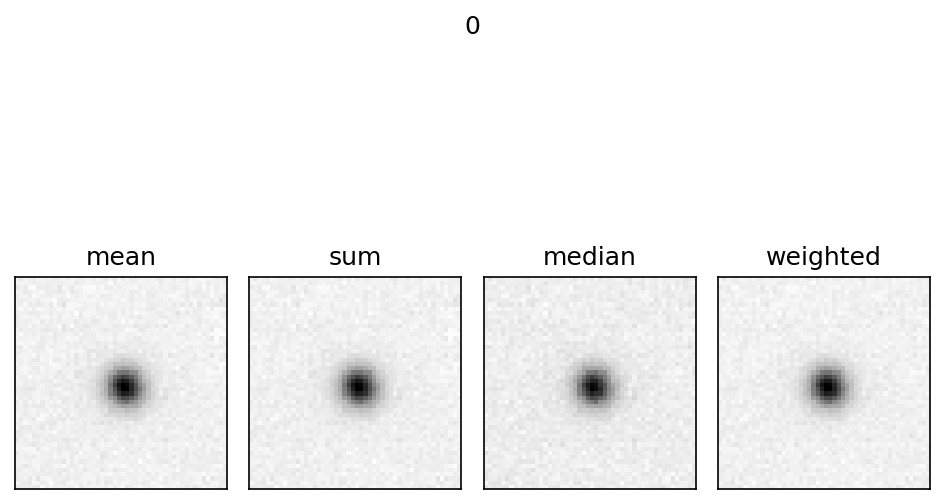

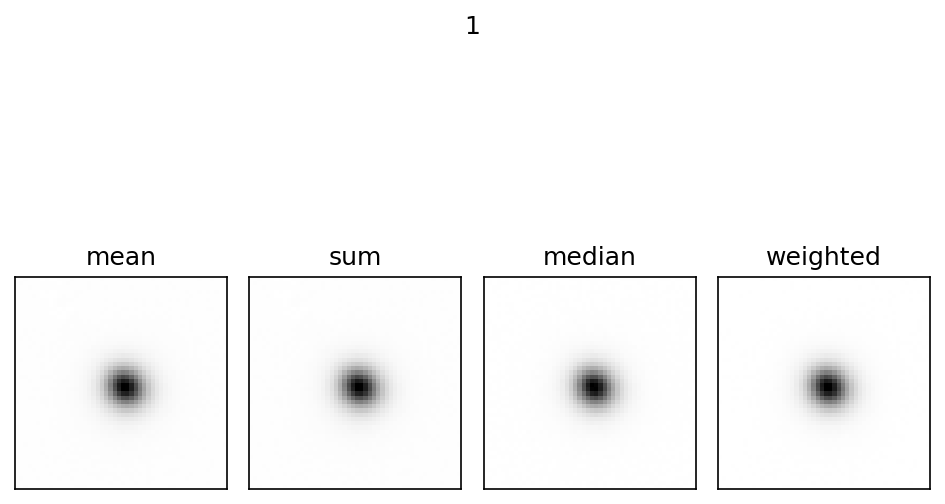

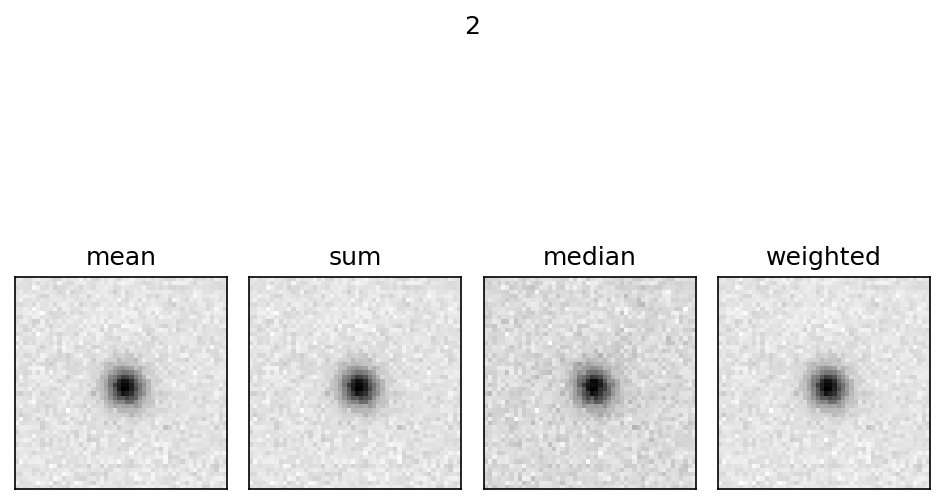

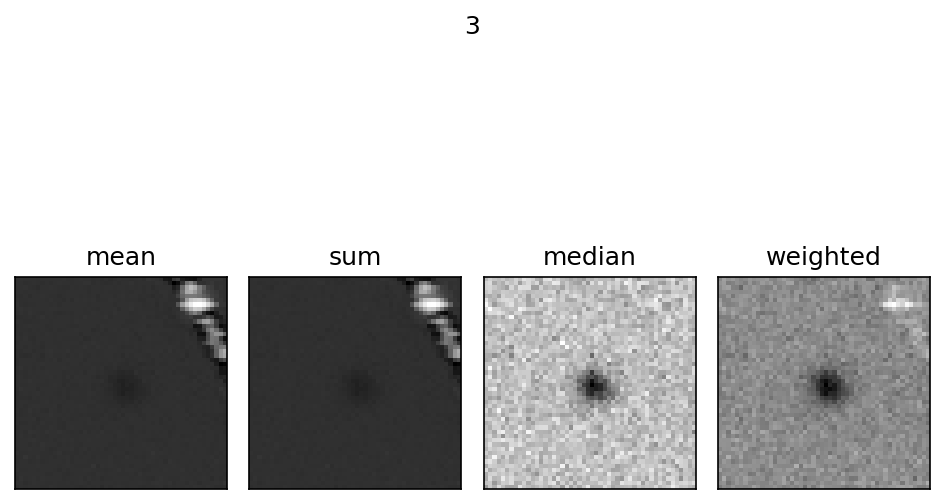

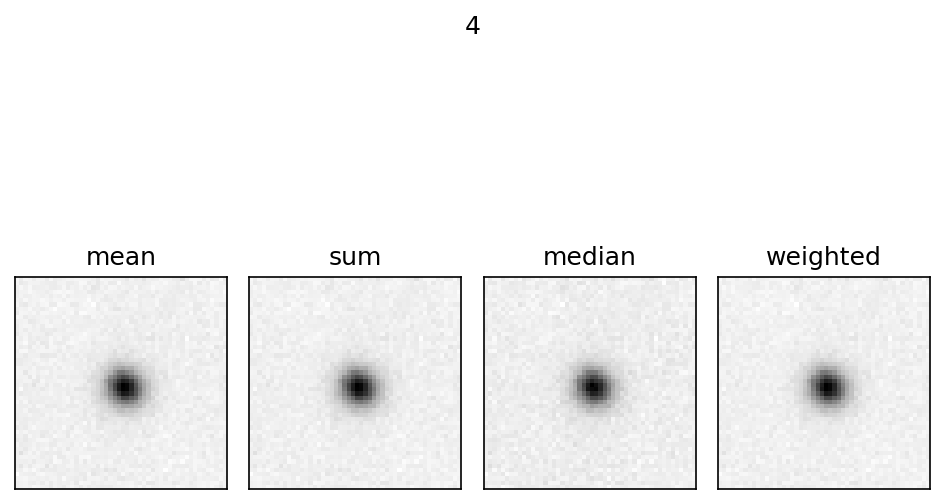

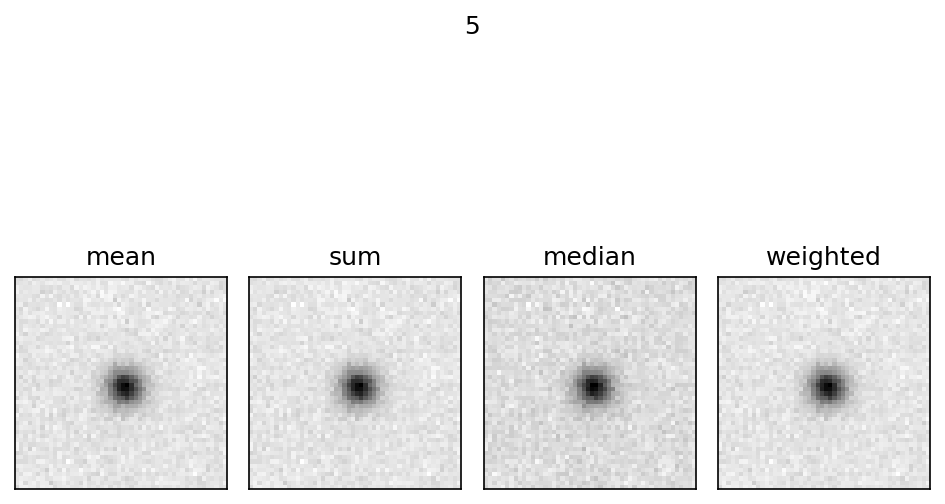

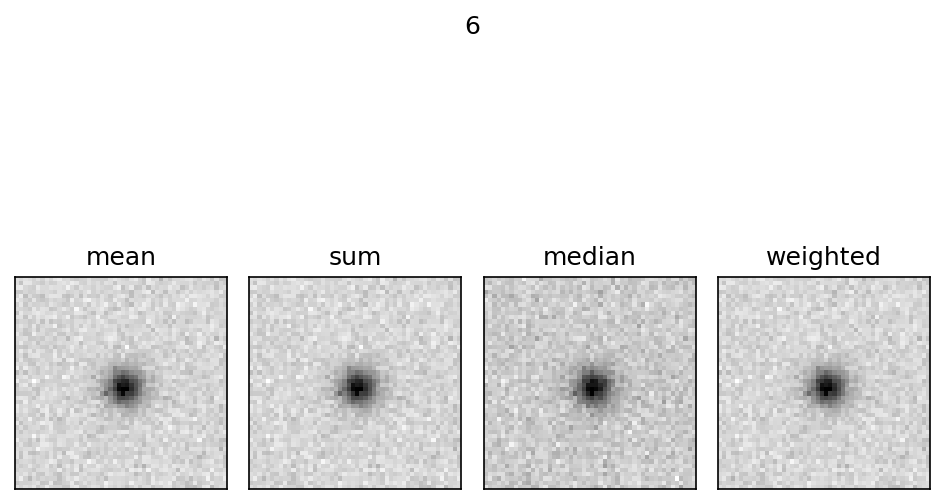

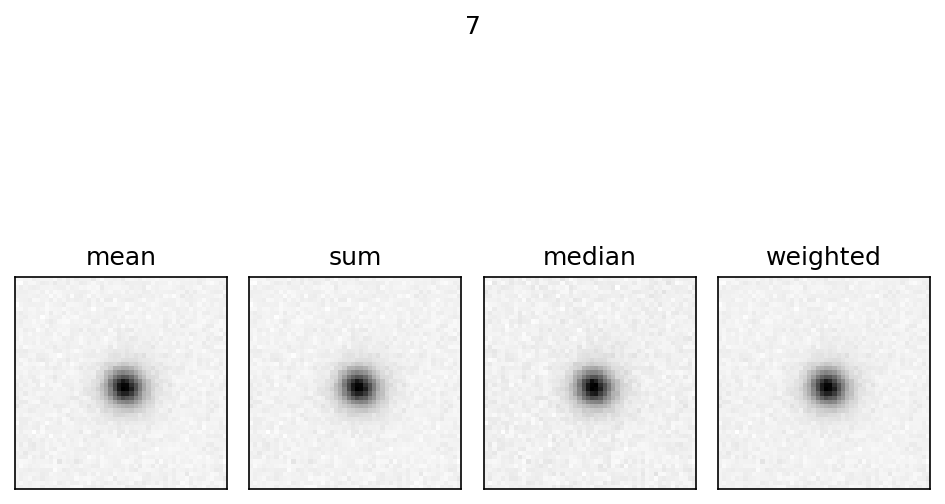

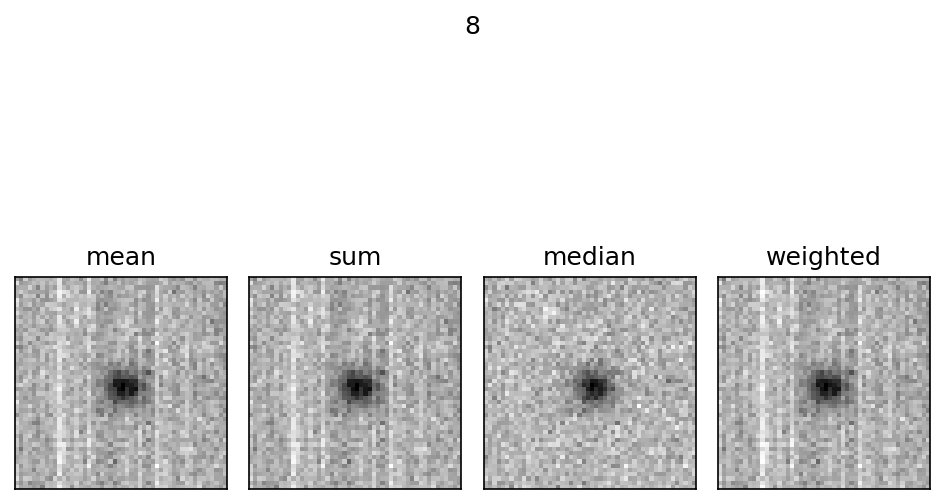

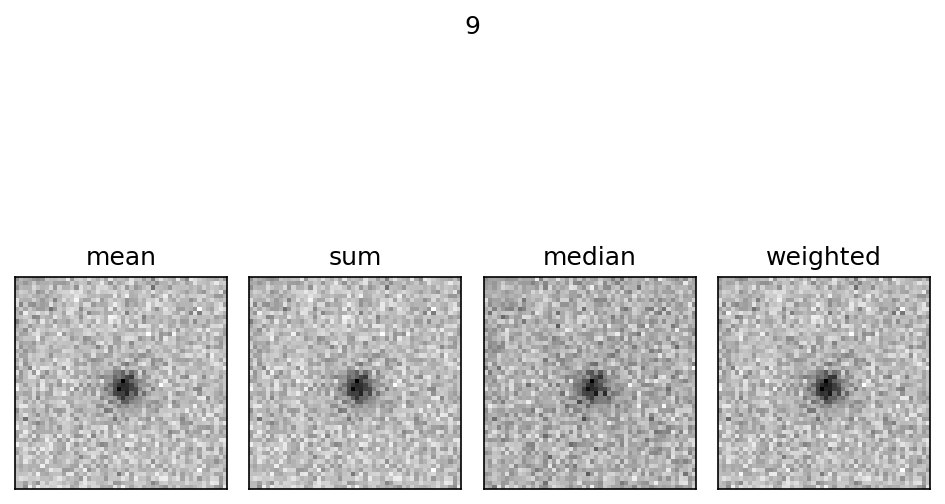

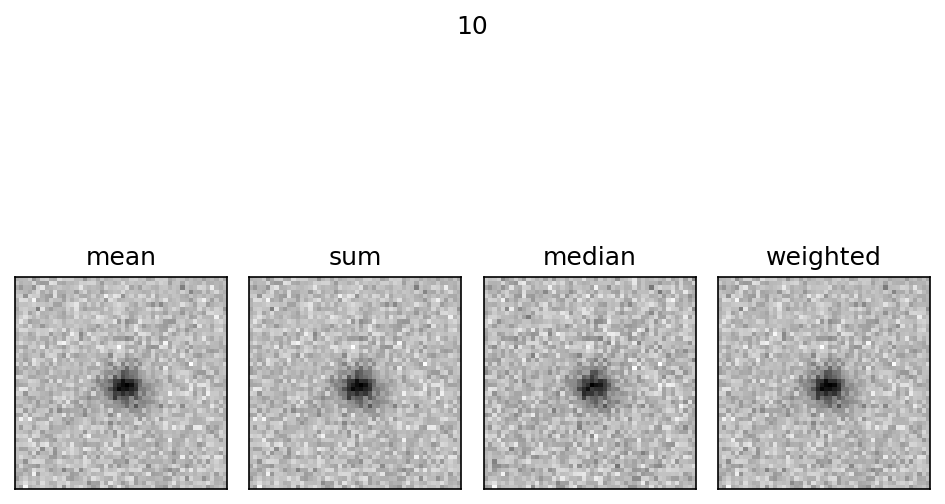

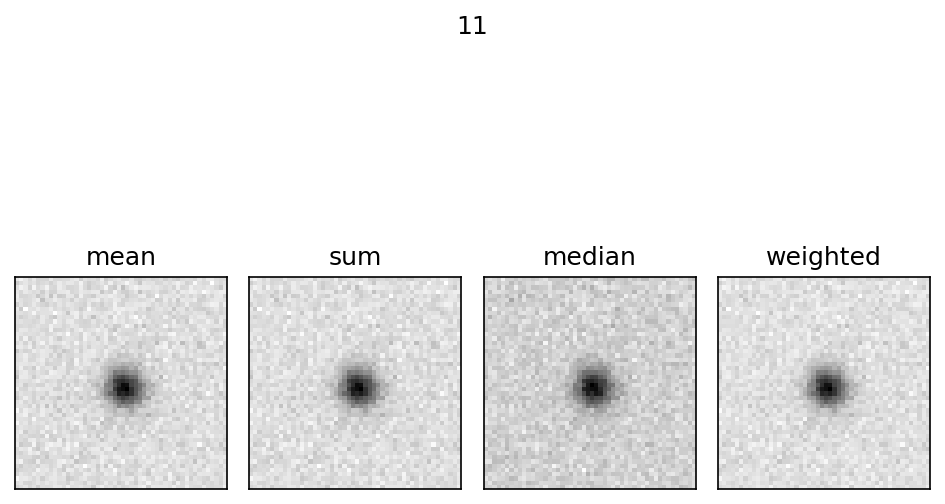

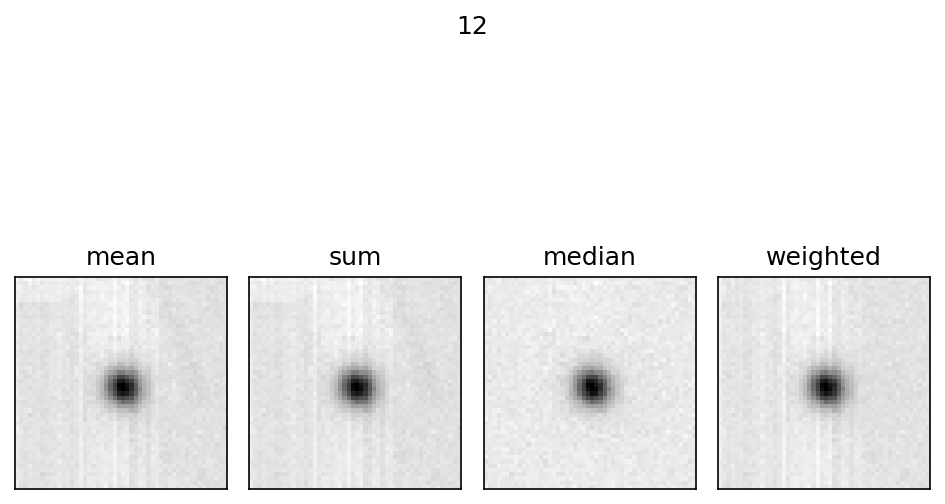

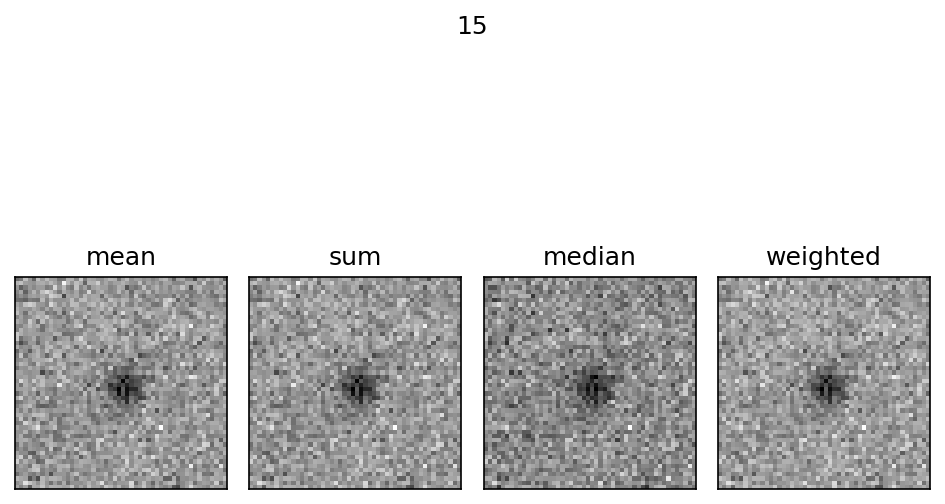

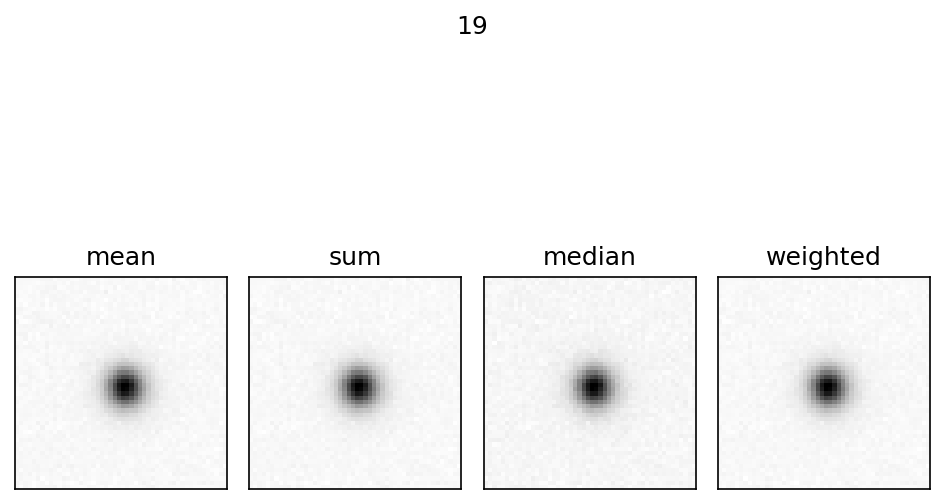

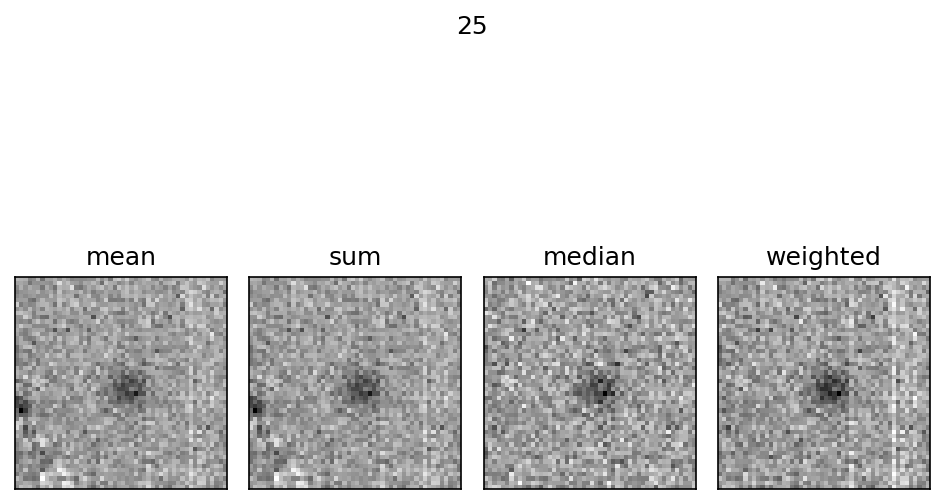

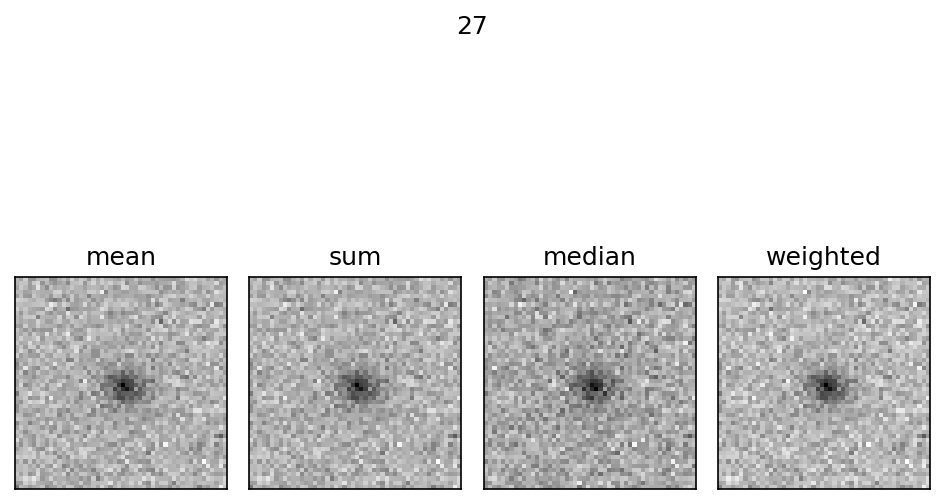

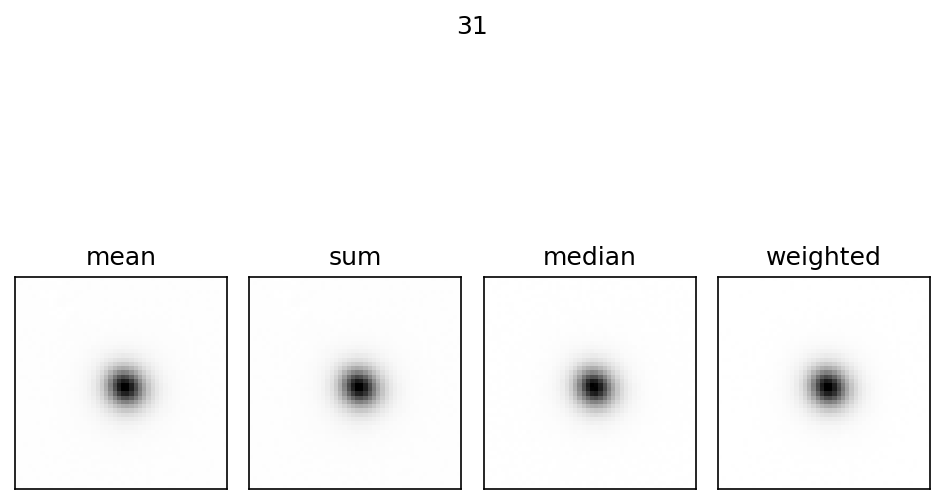

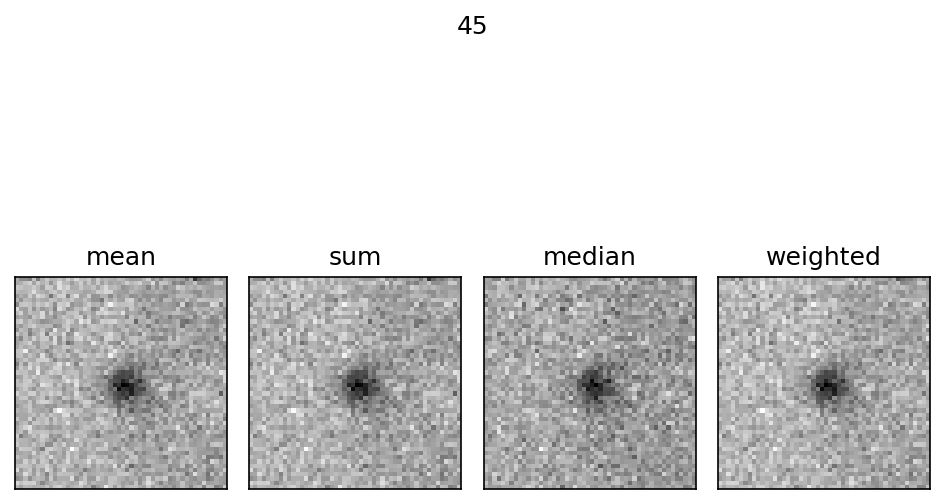

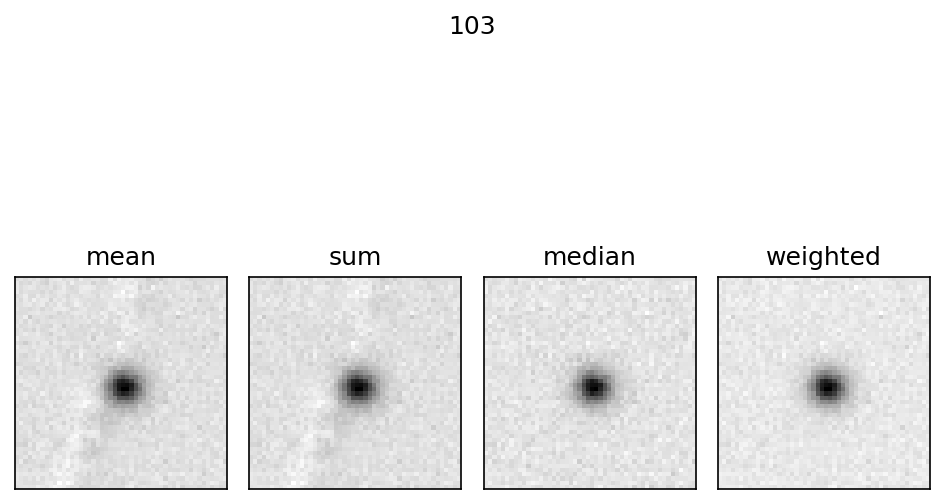

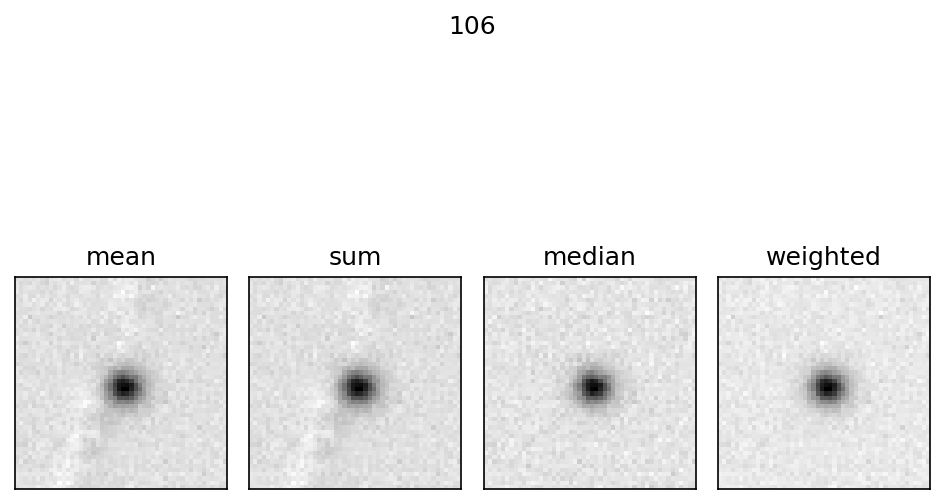

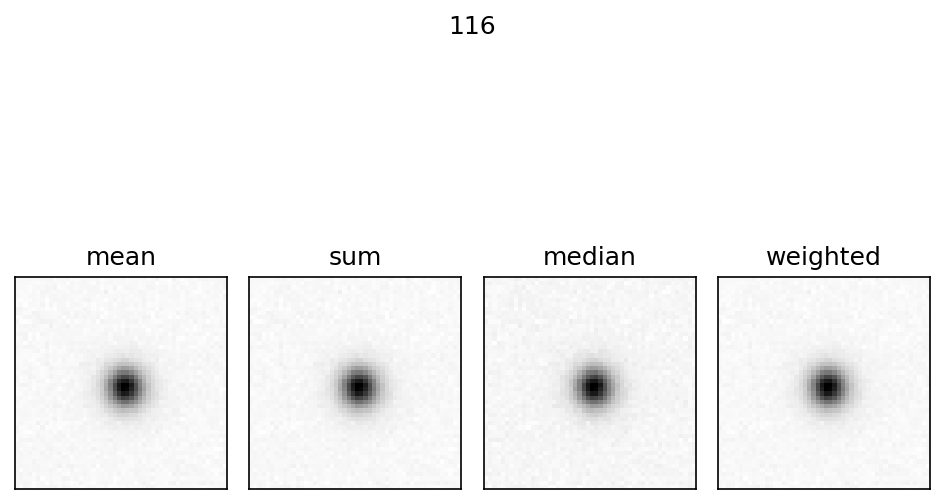

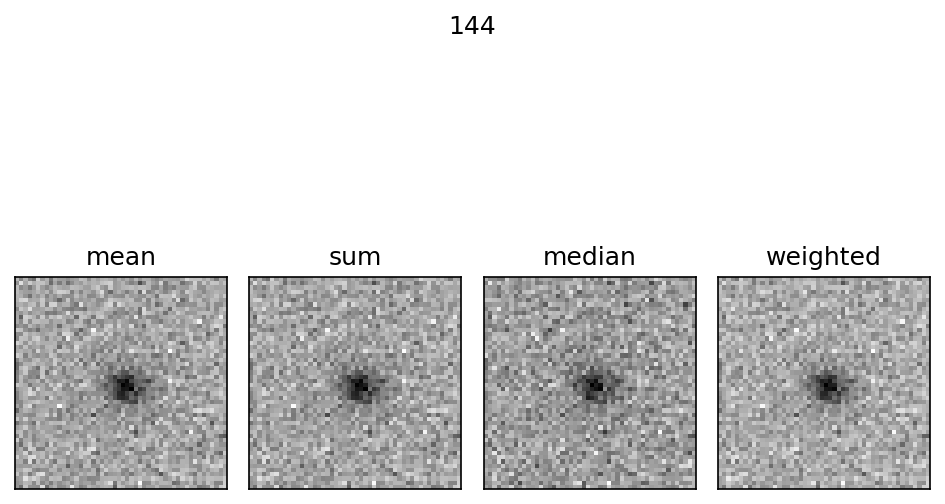

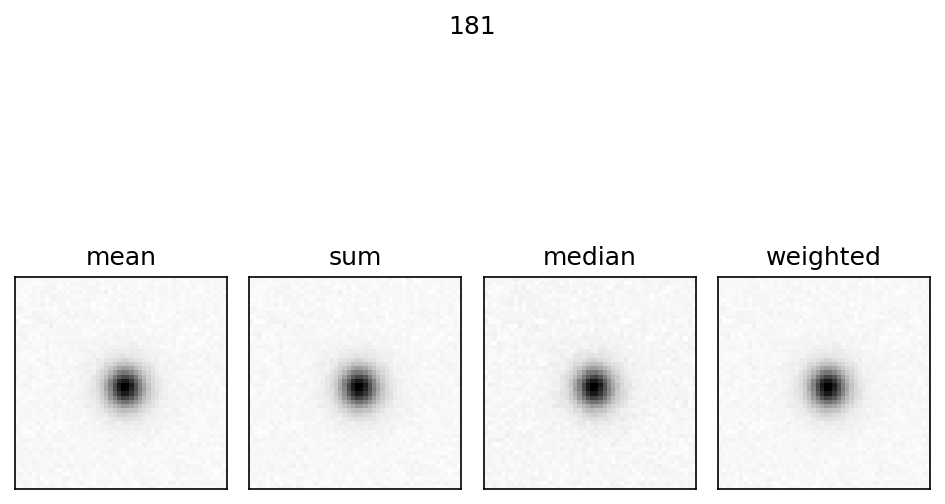

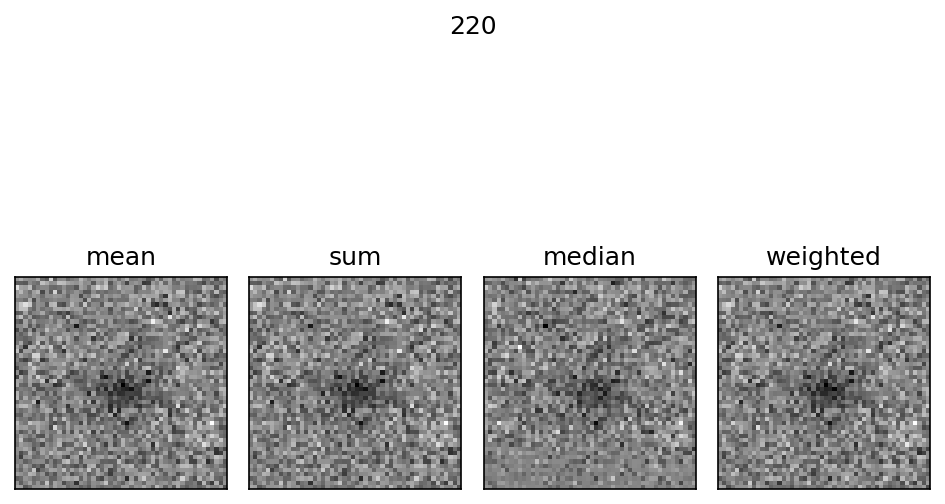

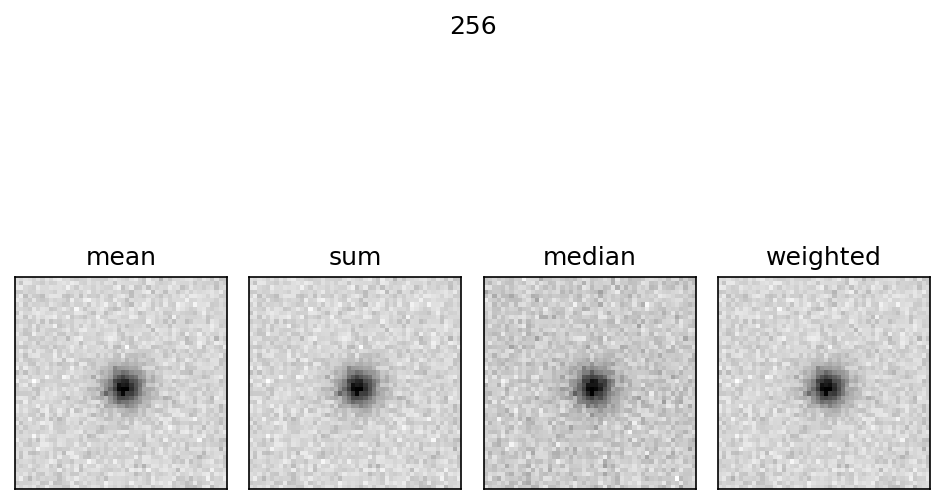

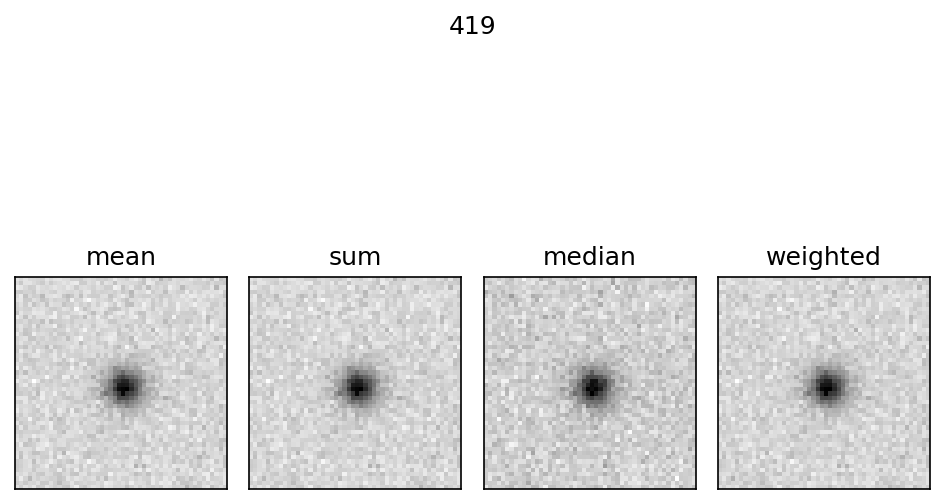

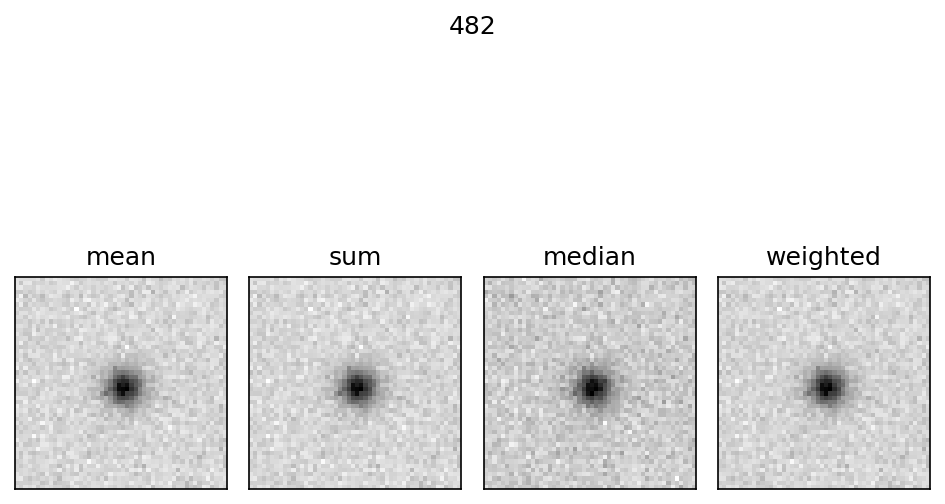

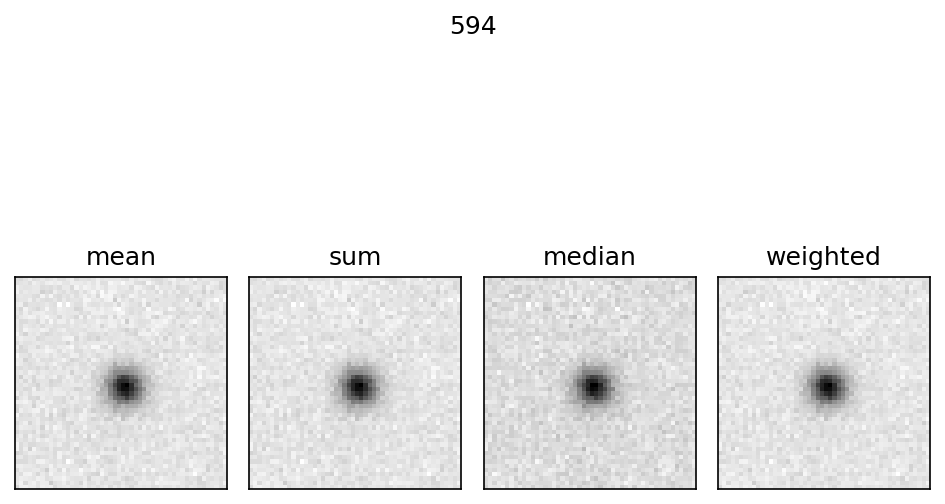

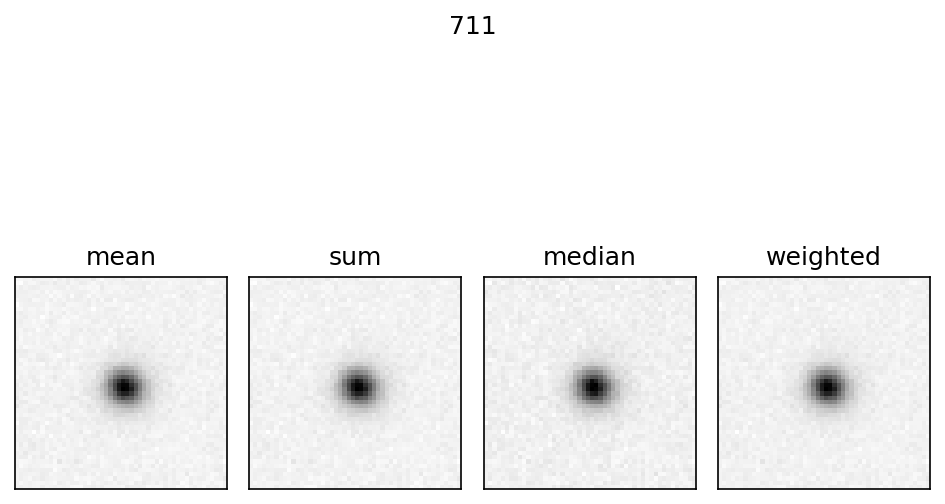

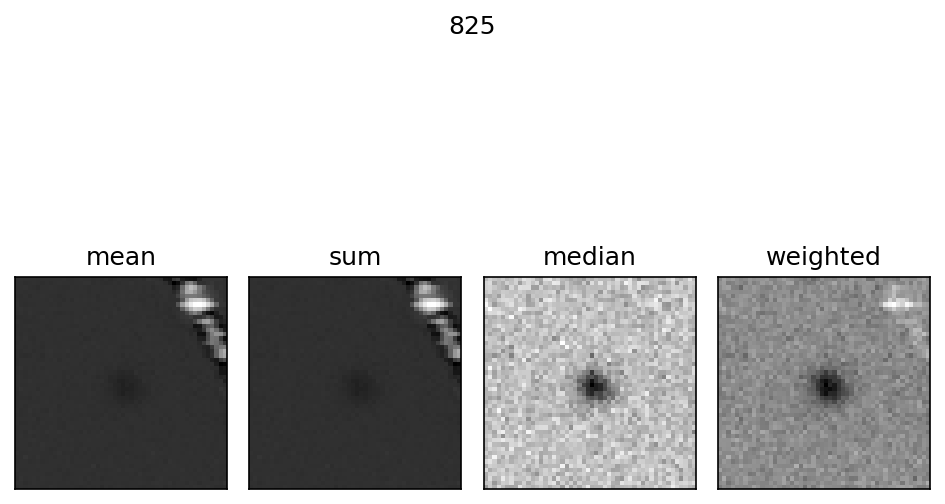

In [65]:
import matplotlib.pyplot as plt
for k in filtered[4]:
    plot_summary_coadds(filtered[4][k].summary)
    fig = plt.gcf()
    fig.suptitle(k)
    fig.tight_layout()
    plt.show()

In [95]:
alphas = []
betas = []
for k in filtered[4]:
    alphas.append(filtered[4][k].line.alpha.value)
    betas.append(filtered[4][k].line.beta.value[0])
    
alphas = np.array(alphas)
betas = np.array(betas)

In [115]:
alphas

array([[ 10998.31625394,  -2459.31353914],
       [  9498.76357015,  -5653.67824763],
       [  9875.65161844,  -3256.85533571],
       [  9917.94754884,  -5573.41626844],
       [  9008.30703506,  -6088.21856042],
       [  9227.31318845,  -3600.83101499],
       [  9983.55058057,  -4132.27406137],
       [  8940.07755229,  -8954.31008056],
       [  9980.26990559,  -4583.74835506],
       [  6432.14895655,  -2408.83479109],
       [  7591.24023312, -10822.64981132],
       [ 12024.73198638,  -4388.53218093],
       [  9661.918822  ,  -3150.95054471],
       [ 10077.61684065,  -3082.98827091],
       [ 13013.4405252 ,   1734.81749306],
       [ 10190.03420848,  -5165.25235796],
       [  9848.76034745,    983.31990968],
       [  9498.76357015,  -5653.67824763],
       [ 12300.94109365,  -2120.65610359],
       [ 17637.29276612,   5625.54476477],
       [ 17637.29276612,   5625.54476477],
       [ 13014.9347888 ,   1734.697422  ],
       [  9834.18270129,    955.99695108],
       [ 13

In [408]:
def match_distance(a):
    d = np.sum(
        np.vstack(
            [
                [np.subtract.outer(a[:, 0], a[:, 0])**2],
                [np.subtract.outer(a[:, 1], a[:, 1])**2]
            ]
        ), 
        axis=0
    )**0.5
    return d
    

def find_matches(distances, threshes):
    distances = np.atleast_3d(distances)
    threshes = np.atleast_1d(threshes)
    for i in range(distances[0].shape[0]):
        masks = [d < t for d, t in zip(distances, threshes)]
        mask = np.logical_and.reduce(masks)
        idx = np.where(mask)[0]
        idx = idx[idx != i]
        if len(idx) > 0:
            m = []
            for j in idx:
                if j not in matches and j not in matched:
                    m.append(j)
                    matched.append(j)
            if len(m) > 0:
                matches[i] = m
    return matches
    
    
# def find_matches_single(a, thresh=1e-1):
#     d = match_distance(a)
#     matches = {}
#     matched = []
#     for i in range(d.shape[0]):
#         idx = np.where(d[i] < thresh)[0]
#         idx = idx[idx != i]
#         if len(idx) > 0:
#             m = []
#             for j in idx:
#                 if j not in matches and j not in matched:
#                     m.append(j)
#                     matched.append(j)
#             if len(m) > 0:
#                 matches[i] = m
#     return matches
    
    
# def find_matches_multiple(arrays, threshes):
#     matches = {}
#     matched = []
#     for i in range(d1.shape[0]):
#         mask1 = d1[i] < origin_thresh
#         mask2 = d2[i] < beta_thresh
#         mask = mask1 & mask2
#         idx = np.where(mask)[0]
#         idx = idx[idx != i]
#         if len(idx) > 0:
#             m = []
#             for j in idx:
#                 if j not in matches and j not in matched:
#                     m.append(j)
#                     matched.append(j)
#             if len(m) > 0:
#                 matches[i] = m
    
    
def quantities(clusters, time_zero):
    origins = []
    alphas = []
    betas = []
    idx_to_keys = {}
    keys_to_idx = {}
    for i, k in enumerate(clusters):
        origins.append(clusters[k].line.predict(time_zero).value[0])
        alphas.append(clusters[k].line.alpha.value)
        betas.append(clusters[k].line.beta.value[0])
        idx_to_keys[i] = k
        keys_to_idx[k] = i
    
    origins = np.array(origins)
    alphas = np.array(alphas)
    betas = np.array(betas)

    return origins, alphas, betas, idx_to_keys, keys_to_idx
    
def find_matches(distances, threshes):
    distances = np.atleast_3d(distances)
    threshes = np.atleast_1d(threshes)
    matches = {}
    matched = []
    
    print(distances.shape, threshes.shape)
    for i in range(distances[-1].shape[0]):
        masks = []
        for j, t in enumerate(threshes):
            masks.append(distances[i, :, j] < t)
            
        mask = np.logical_and.reduce(masks)
        idx = np.where(mask)[0]
        idx = idx[idx != i]
        if len(idx) > 0:
            m = []
            for j in idx:
                if j not in matches and j not in matched:
                    m.append(j)
                    matched.append(j)
            if len(m) > 0:
                matches[i] = m
    
    return matches    

def deduplicate(clusters, time_zero, origin_thresh, beta_thresh):
    origins, alphas, betas, idx_to_keys, keys_to_idx = quantities(clusters, time_zero)
    
    matches = find_matches(
        np.array([match_distance(origins), match_distance(betas)]).T, 
        [origin_thresh, beta_thresh]
    )
    dedup = {k: clusters[k] for k in clusters}

    for k in clusters:
        if keys_to_idx[k] in matches:
            for j in matches[keys_to_idx[k]]:
                if idx_to_keys[j] in dedup:
                    dedup.pop(idx_to_keys[j])
    return dedup

In [417]:
time_zero = times_for(exposures).min()
time_max = times_for(exposures).max()
dedup = deduplicate(
    filtered[4], 
    time_zero, 
    (5 * u.arcsec).to(u.deg).value, 
    ((1 * u.arcsec)/(time_max - time_zero)).to(u.deg/u.day).value 
)
len(dedup)

(31, 31, 2) (2,)


20

In [411]:
list(dedup.keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 19, 25, 27, 45, 103, 220]

In [9]:
from salad.analysis.plot import plot_cluster, plot_result

In [441]:
t = times_for(exposures)

In [10]:
from astropy.coordinates import SkyCoord

def plot_line(line, x, **kwargs):
    y = line.predict(x)
    coord = (SkyCoord(y[:, 0], y[:, 1]))
    plt.plot(coord.ra, coord.dec, **kwargs)


In [481]:
filtered[4][0].cutouts[845908].mask.getMaskPlaneDict()

{'BAD': 0,
 'CLIPPED': 9,
 'CR': 3,
 'CROSSTALK': 10,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'FAKE': 11,
 'INEXACT_PSF': 12,
 'INJECTED': 13,
 'INJECTED_TEMPLATE': 14,
 'INTRP': 2,
 'NOT_DEBLENDED': 15,
 'NO_DATA': 8,
 'REJECTED': 16,
 'SAT': 1,
 'SENSOR_EDGE': 17,
 'STREAK': 18,
 'SUSPECT': 7,
 'UNMASKEDNAN': 19}

In [483]:
# [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 19, 25, 27, 45, 103, 220]

In [503]:
args

NameError: name 'args' is not defined

In [502]:
# we do this many gather + refine steps
dx = 10
while dx != 1:
    dx /= 2
    dx = max(dx, 1)
    print(dx)
print(dx)

5.0
2.5
1.25
1
1


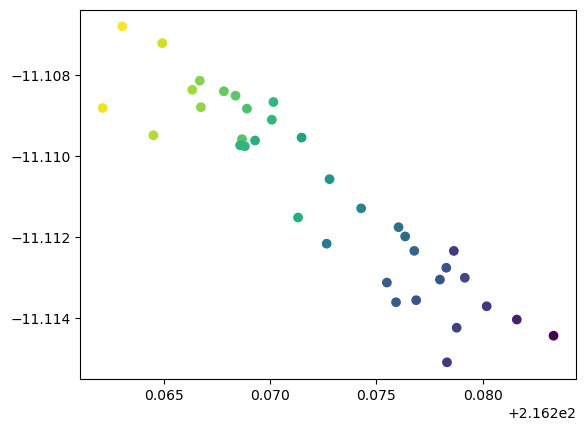

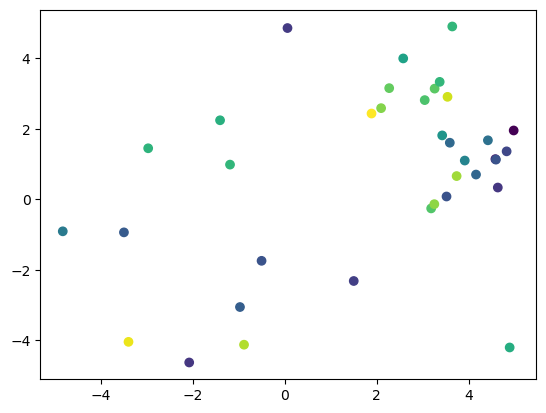

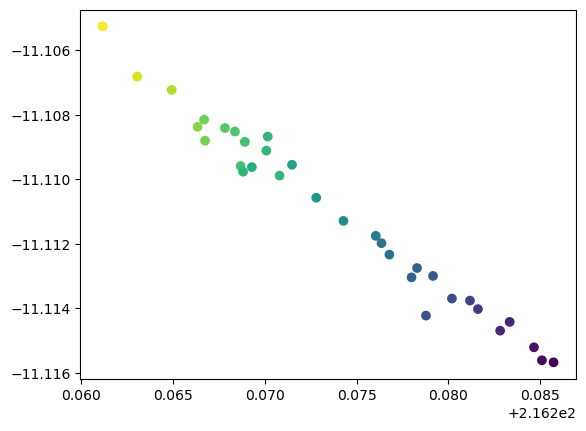

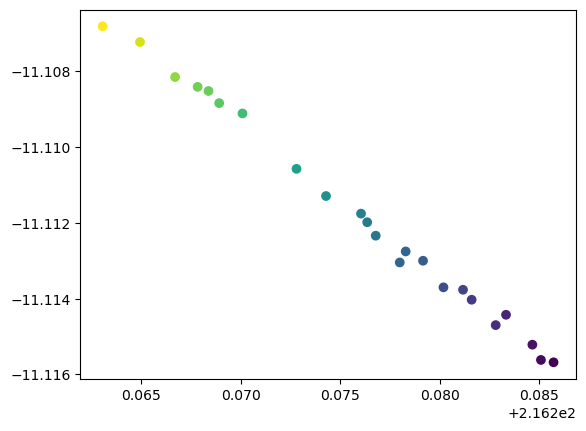

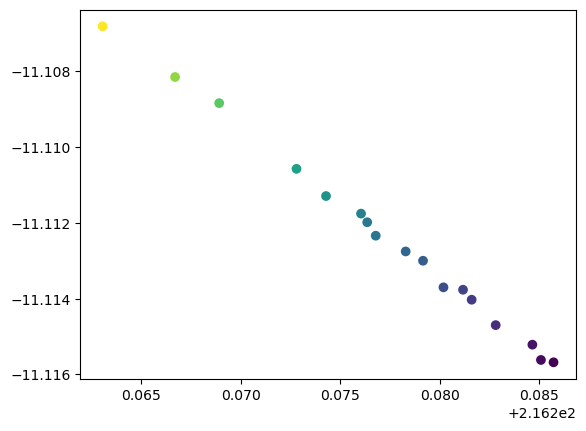

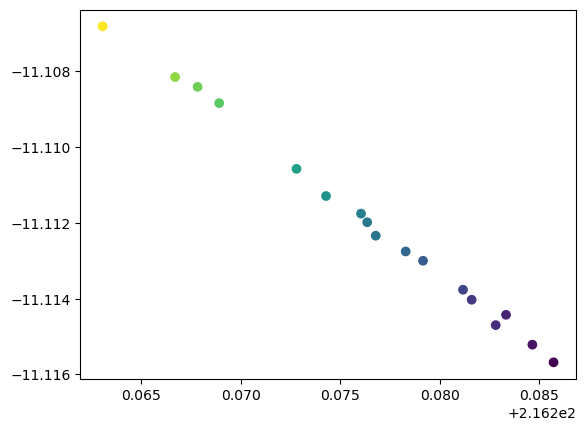

In [15]:
import matplotlib.pyplot as plt
import astropy.units as u

i = 220
plot_cluster(clusters[i], c=clusters[i].points[:, 2])
# plot_line(
#     clusters[i].line, 
#     t,
#     color="k"
# )
plt.show()

y = clusters[i].line.predict(clusters[i].points[:, 2]*u.day)
plt.scatter(
    (clusters[i].points[:, 0] - y[:, 0].value)*3600, 
    (clusters[i].points[:, 1] - y[:, 1].value)*3600,
    c=clusters[i].points[:, 2],
)
plt.show()

for j in range(1, 5):
    plot_cluster(
        gathered[j][i], 
        c=gathered[j][i].points[:, 2]
    )
#     plot_line(
#         gathered[j][i].line, 
#         t,
#         color="k"
#     )
    plt.show()
# plot_cluster(gathered[2][i])
# plt.show()
# plot_cluster(gathered[3][i])
# plt.show()
# plot_cluster(gathered[4][i])
# plt.show()

In [382]:
match_distance(origins)

(31, 31)

In [399]:
time_zero = times_for(exposures).min()
origins, alphas, betas, idx_to_keys, keys_to_idx = quantities(clusters, time_zero)

distances = np.array(
    [
        match_distance(origins), 
        match_distance(betas)
    ]
).T
threshes = [
    (5 * u.arcsec).to(u.deg).value,
    (1 * u.arcsec / dt).to(u.deg/u.day).value    
]
find_matches(distances, threshes)

{1: [17],
 3: [30],
 5: [28],
 6: [25, 26, 27],
 7: [29],
 14: [21, 23],
 16: [22],
 19: [20]}

In [284]:
(10 / 3600) * (24/4)

0.016666666666666666

In [292]:
(1 / 3600) / (4/24) # 10 arcsec in 4 hours

0.0016666666666666668

In [ ]:
# two trajectories are the same if their origins are within 1 arcsec of each other 
# and their velocities diverge by no more 1 arcsec in the timespan of the data

In [328]:
import astropy.units as u
dt = times_for(exposures).max() - times_for(exposures).min()

In [391]:
origins, alphas, betas, idx_to_keys, keys_to_idx = quantities(filtered[4], times_for(exposures).min())

a = origins
d1 = np.sum(
    np.vstack(
        [
            [np.subtract.outer(a[:, 0], a[:, 0])**2],
            [np.subtract.outer(a[:, 1], a[:, 1])**2]
        ]
    ), 
    axis=0
)**0.5

a = betas
d2 = np.sum(
    np.vstack(
        [
            [np.subtract.outer(a[:, 0], a[:, 0])**2],
            [np.subtract.outer(a[:, 1], a[:, 1])**2]
        ]
    ), 
    axis=0
)**0.5

origin_thresh = (5 * u.arcsec).to(u.deg).value
beta_thresh = (1 * u.arcsec / dt).to(u.deg/u.day).value

matches = {}
matched = []
for i in range(d1.shape[0]):
    mask1 = d1[i] < origin_thresh
    mask2 = d2[i] < beta_thresh
    mask = mask1 & mask2
    idx = np.where(mask)[0]
    idx = idx[idx != i]
    if len(idx) > 0:
        m = []
        for j in idx:
            if j not in matches and j not in matched:
                m.append(j)
                matched.append(j)
        if len(m) > 0:
            matches[i] = m

clusters = filtered[4]
dedup = {k: clusters[k] for k in clusters}

for k in clusters:
    if keys_to_idx[k] in matches:
        for j in matches[keys_to_idx[k]]:
            if idx_to_keys[j] in dedup:
                dedup.pop(idx_to_keys[j])

len(dedup), matches

(20,
 {1: [17],
  3: [30],
  5: [28],
  6: [25, 26, 27],
  7: [29],
  14: [21, 23],
  16: [22],
  19: [20]})

In [337]:
find_matches(
    origins, 
    thresh=5/3600
)

{1: [17],
 3: [30],
 5: [28],
 6: [25, 26, 27],
 7: [29],
 14: [21, 23],
 16: [22],
 19: [20]}

In [339]:
find_matches(
    betas, 
    thresh=(1 * u.arcsec / dt).to(u.deg/u.day).value
)

{1: [17],
 3: [30],
 5: [28],
 6: [25, 26, 27],
 7: [29],
 14: [21, 23],
 16: [22],
 19: [20]}

In [504]:
c = deduplicate(
    filtered[4], 
    alpha_thresh=10, 
    beta_thresh=(1 * u.arcsec / dt)
) # 1 arcsec in 4 hours)
c

TypeError: deduplicate() got an unexpected keyword argument 'alpha_thresh'

In [303]:
len(c)

20

In [297]:
list(filtered[4].keys())[16], list(filtered[4].keys())[22]

(27, 144)

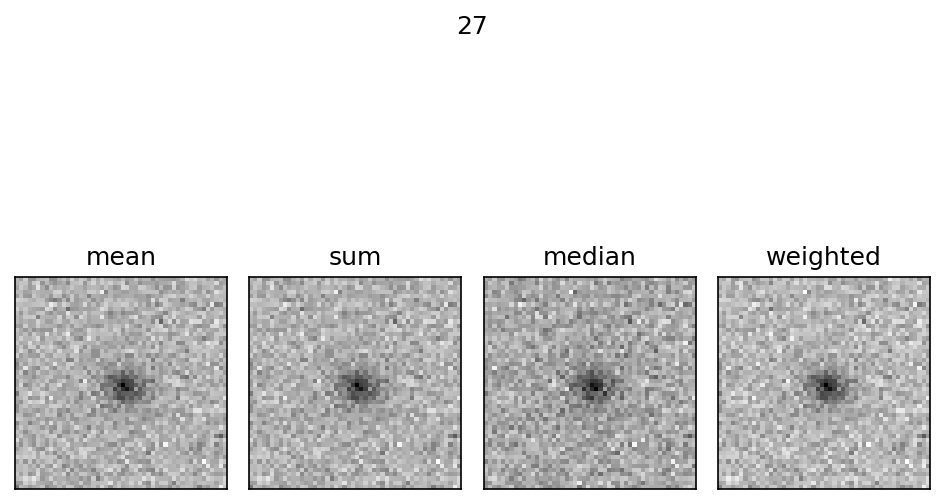

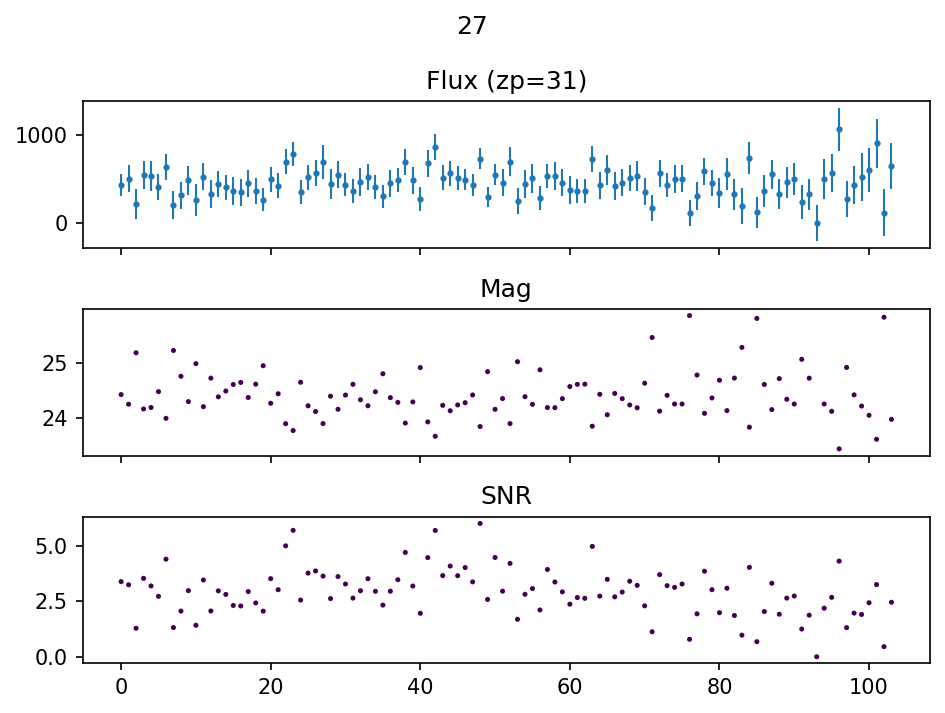

In [298]:
c = filtered[4]
k = 27
plot_summary_coadds(c[k].summary)
fig = plt.gcf()
fig.suptitle(k)
fig.tight_layout()
plt.show()
plot_summary_light_curve(c[k].summary)
fig = plt.gcf()
fig.suptitle(k)
fig.tight_layout()    
plt.show()

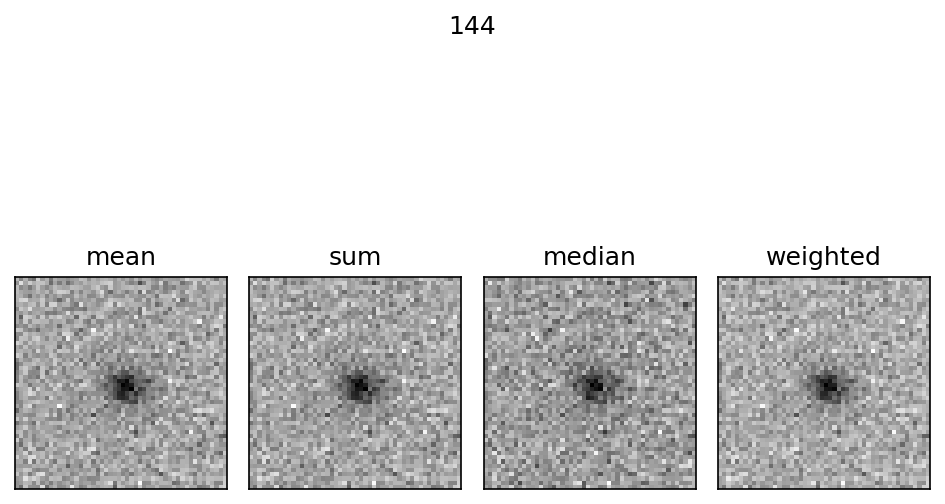

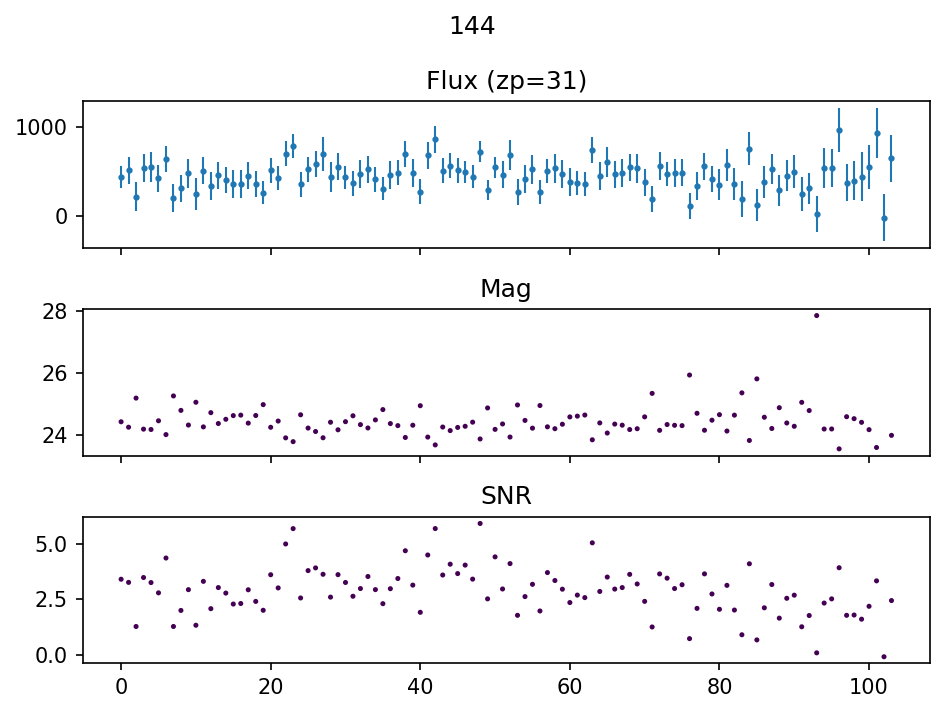

In [299]:
c = filtered[4]
k = 144
plot_summary_coadds(c[k].summary)
fig = plt.gcf()
fig.suptitle(k)
fig.tight_layout()
plt.show()
plot_summary_light_curve(c[k].summary)
fig = plt.gcf()
fig.suptitle(k)
fig.tight_layout()    
plt.show()

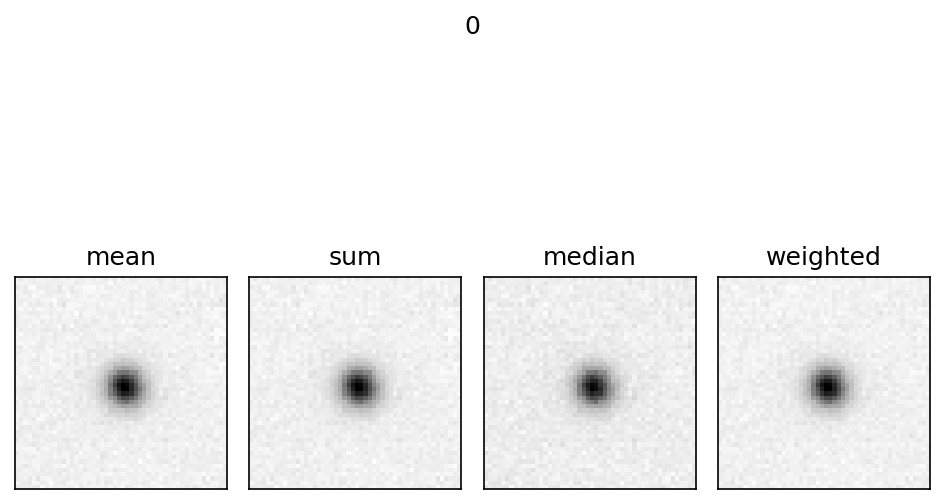

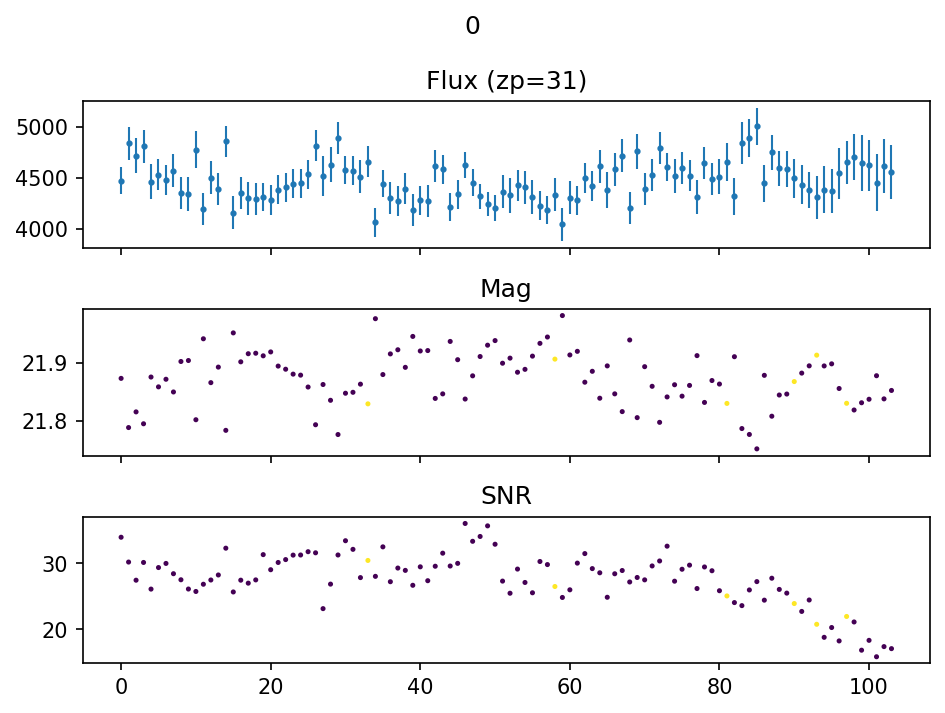

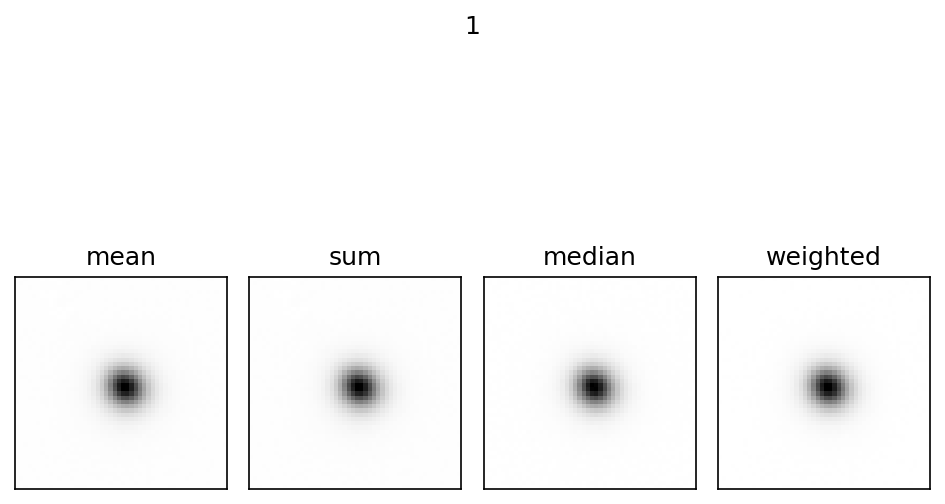

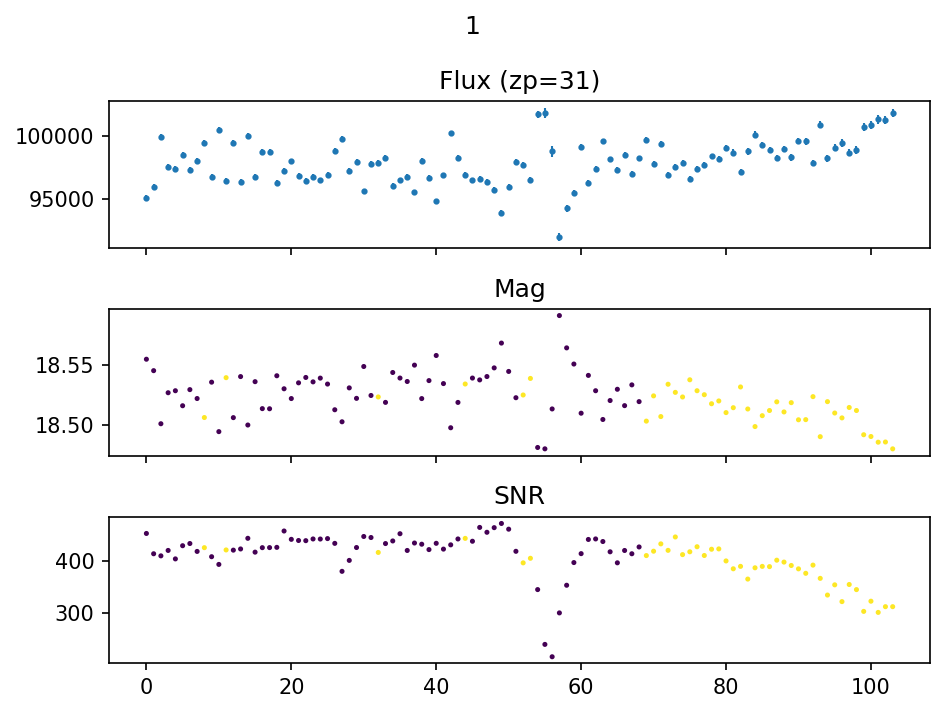

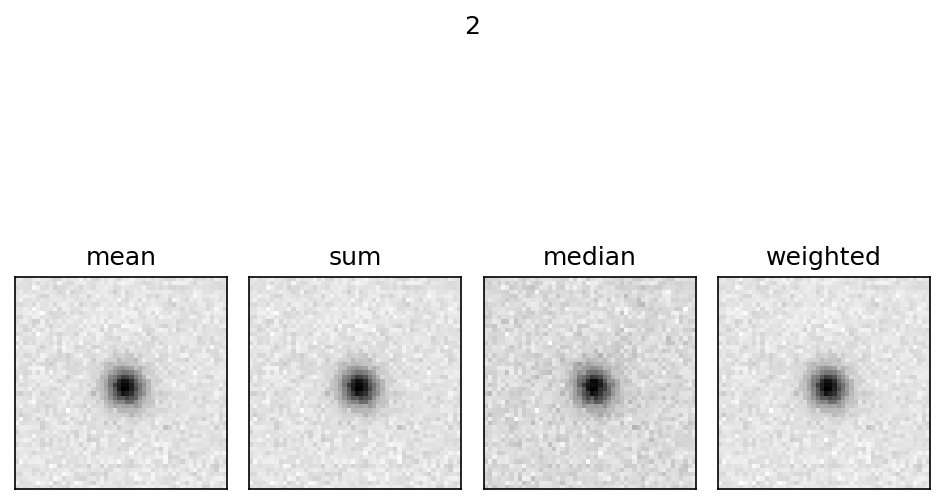

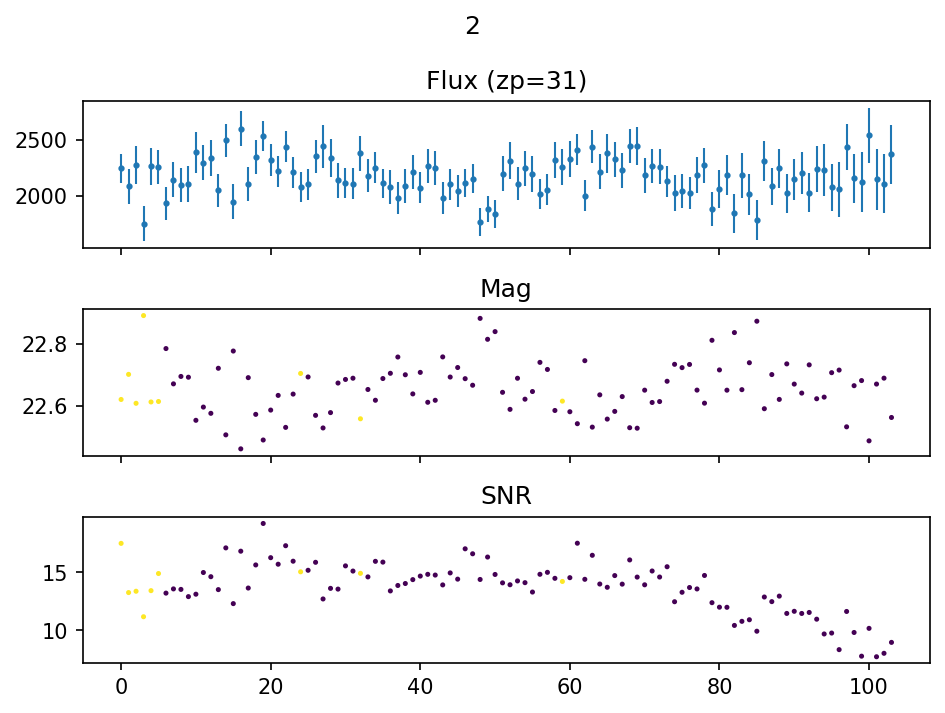

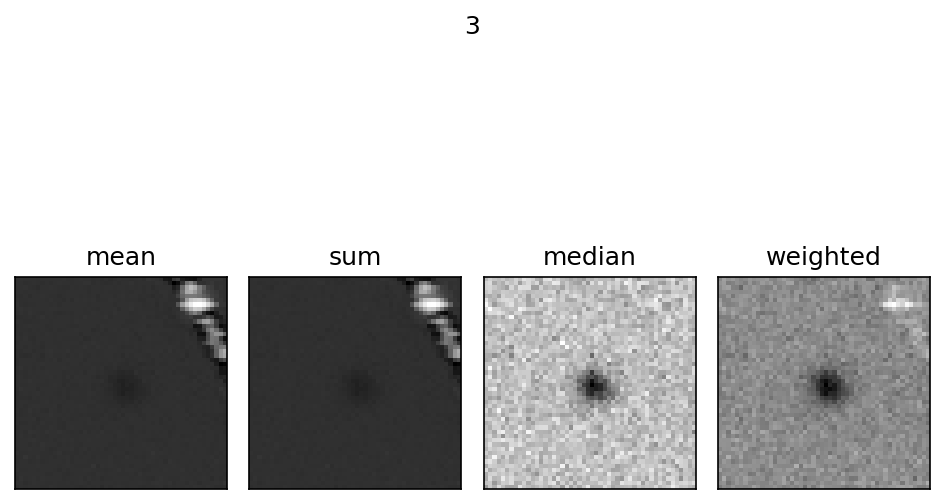

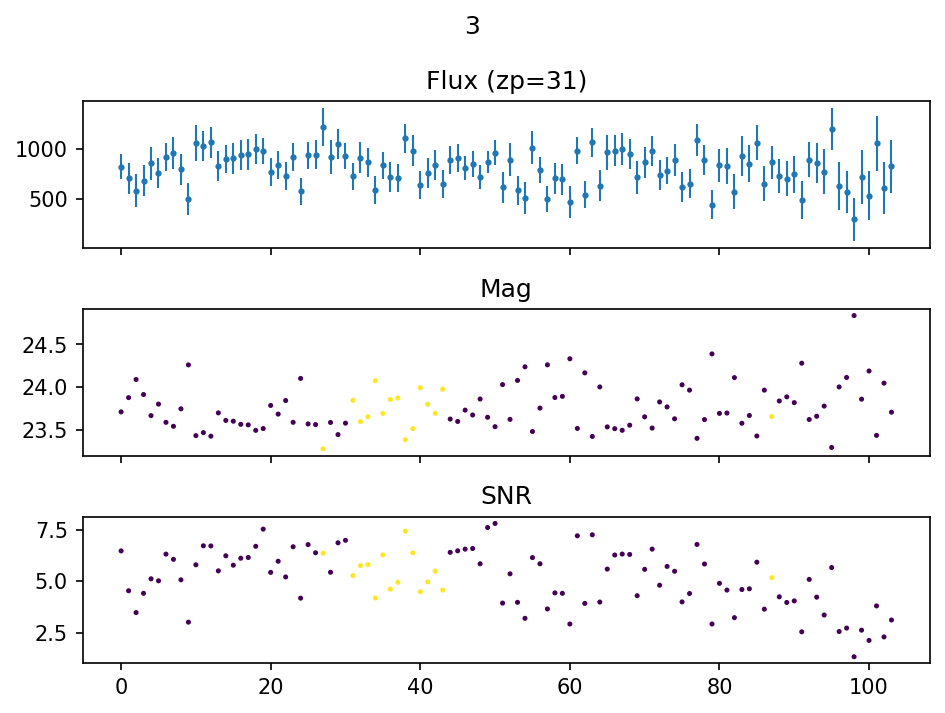

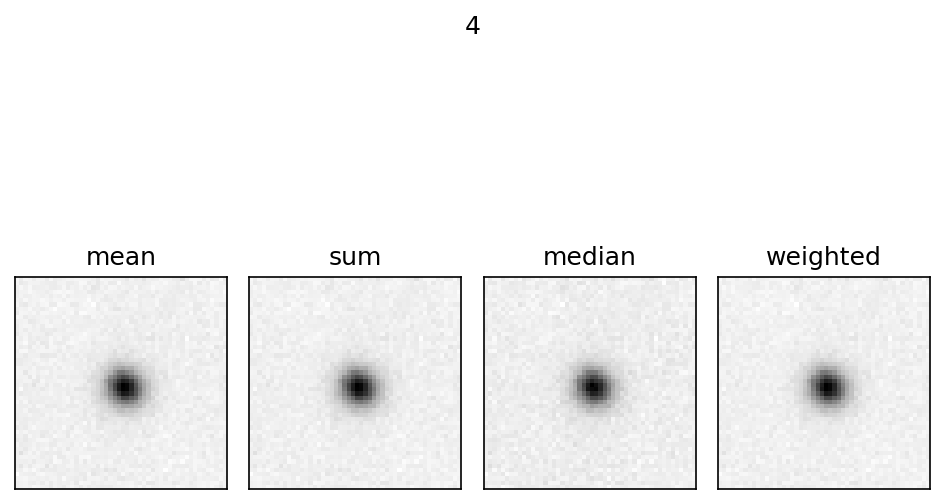

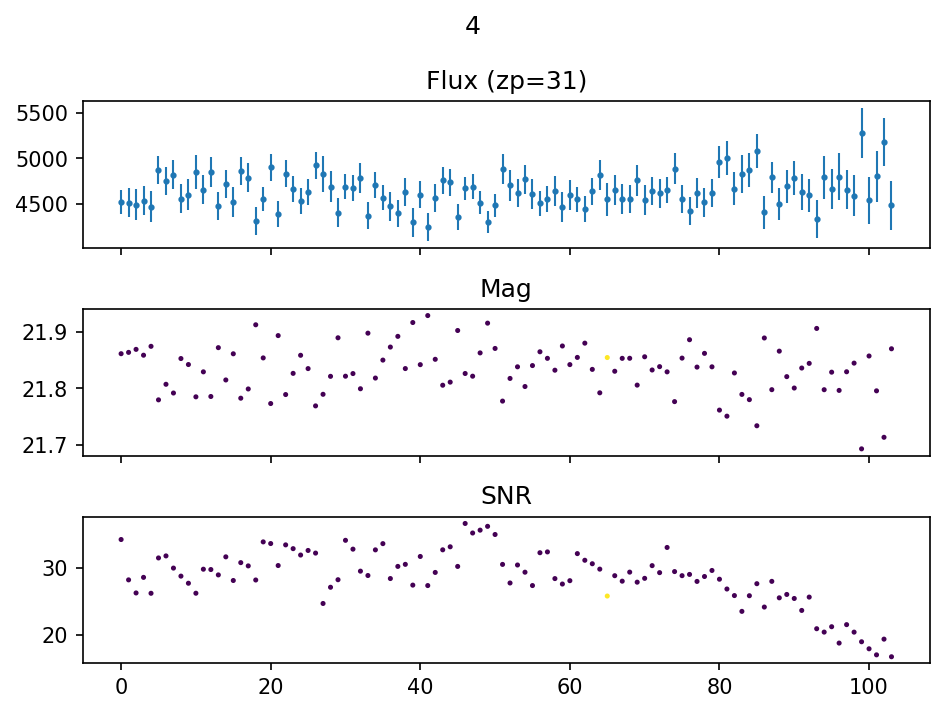

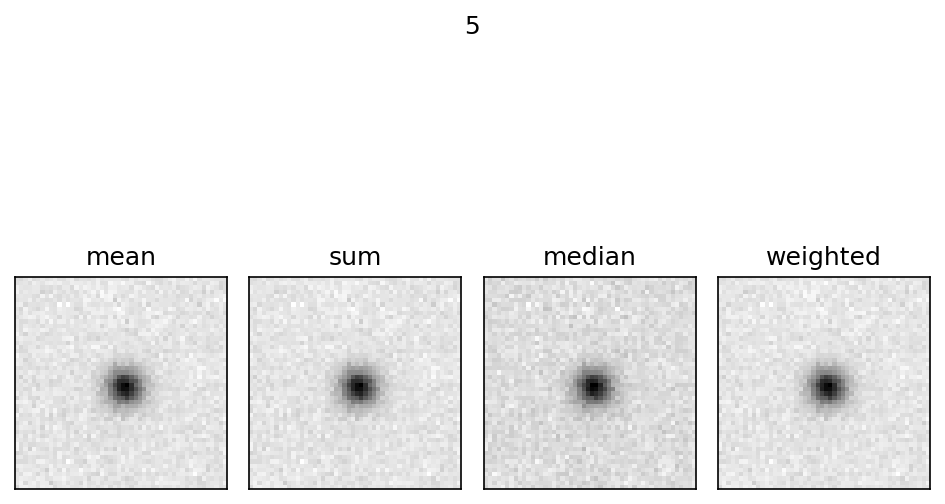

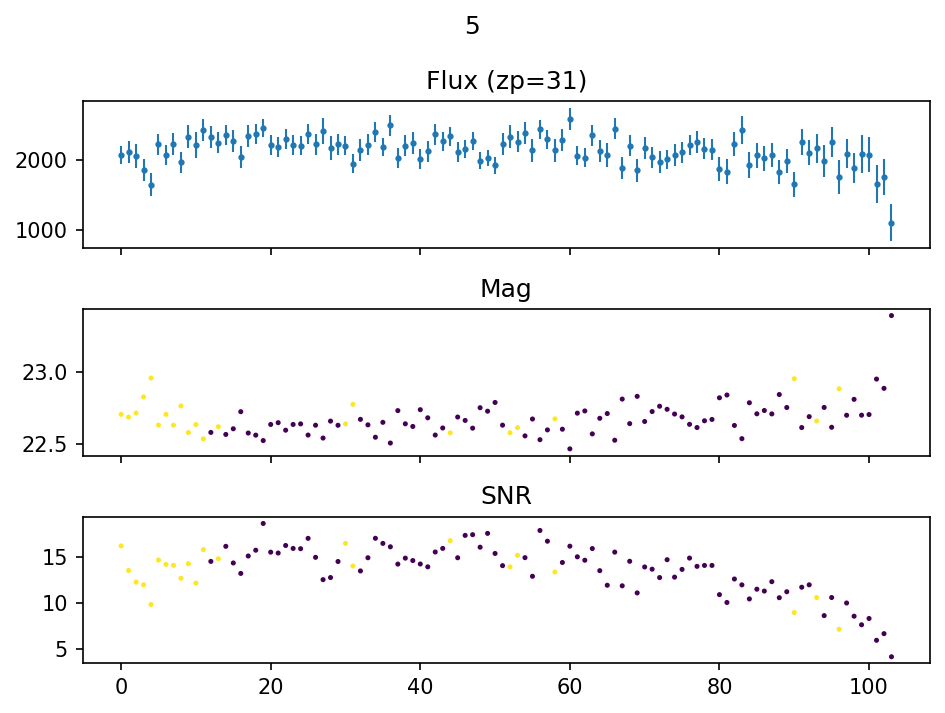

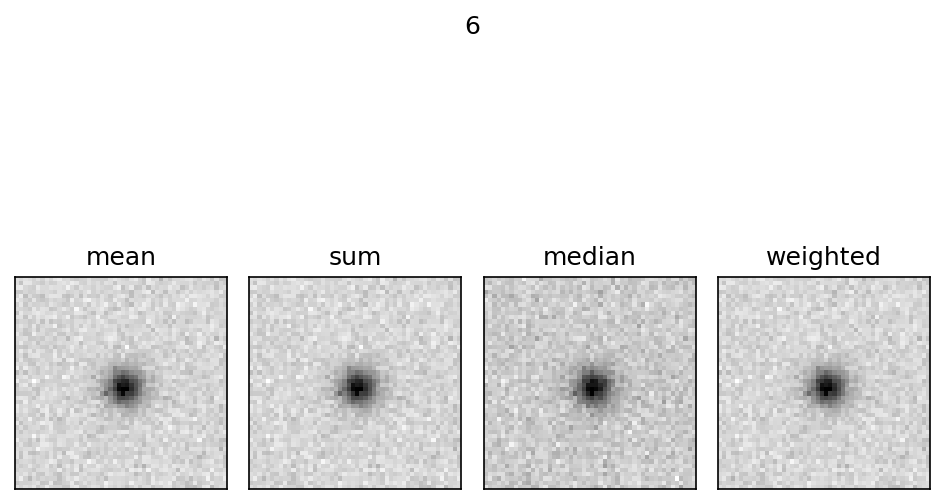

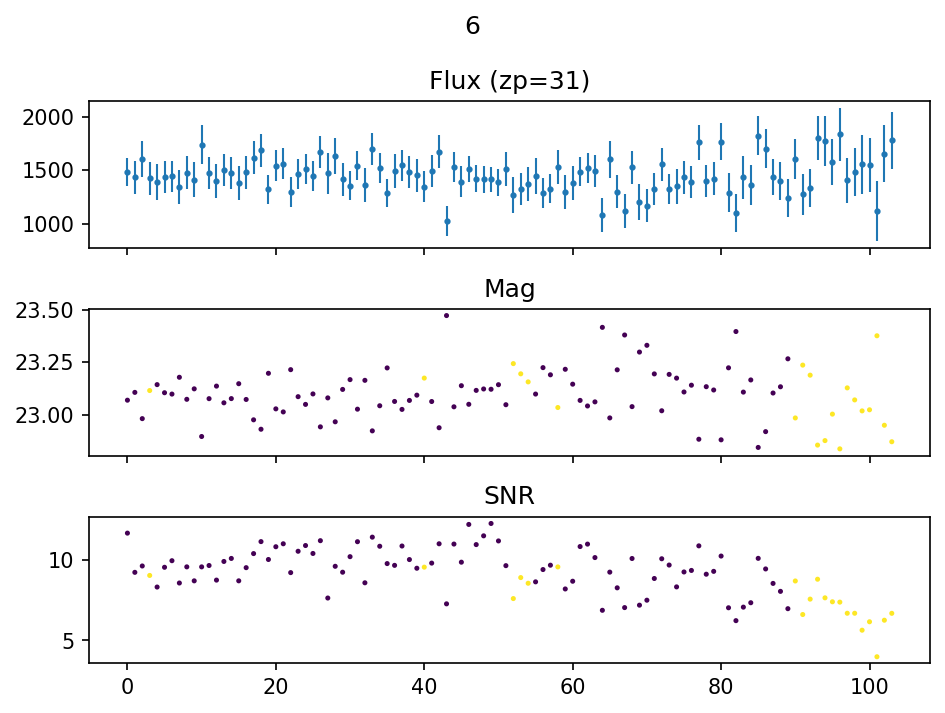

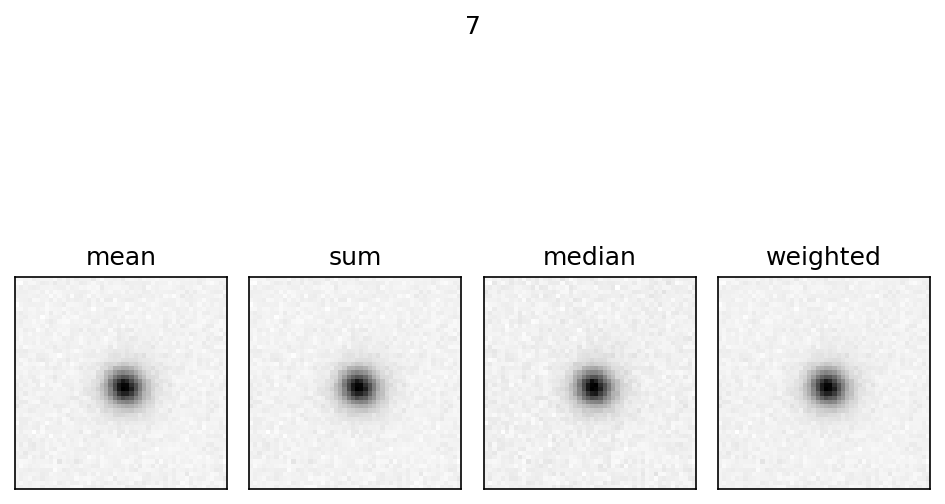

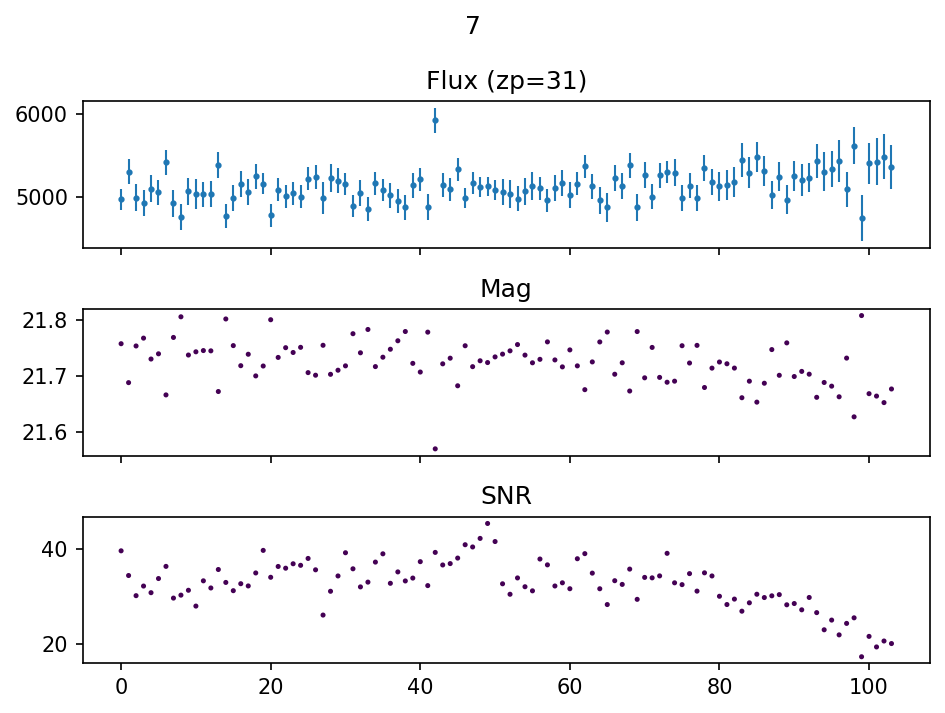

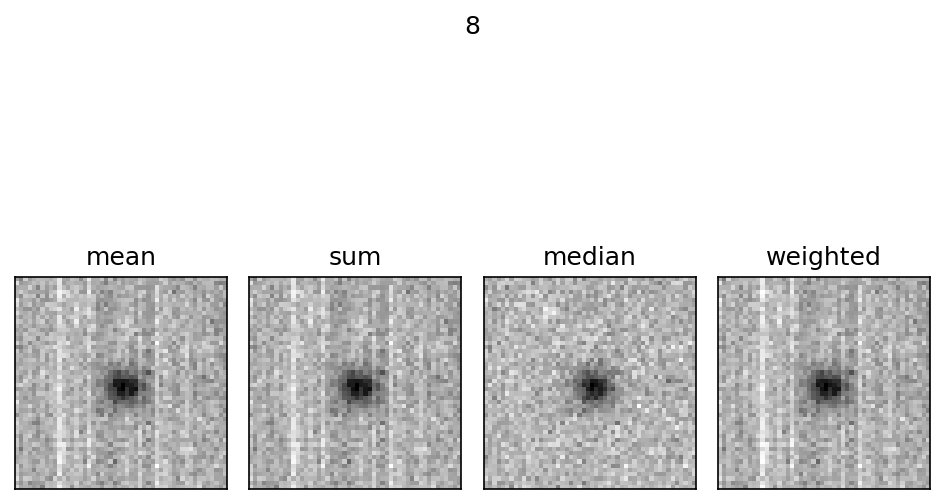

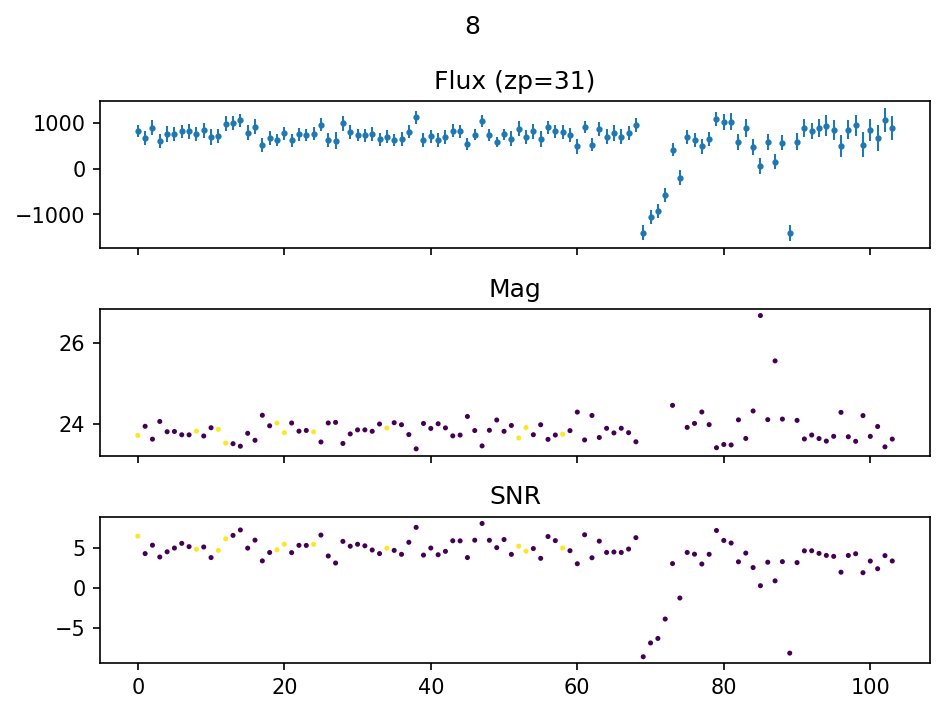

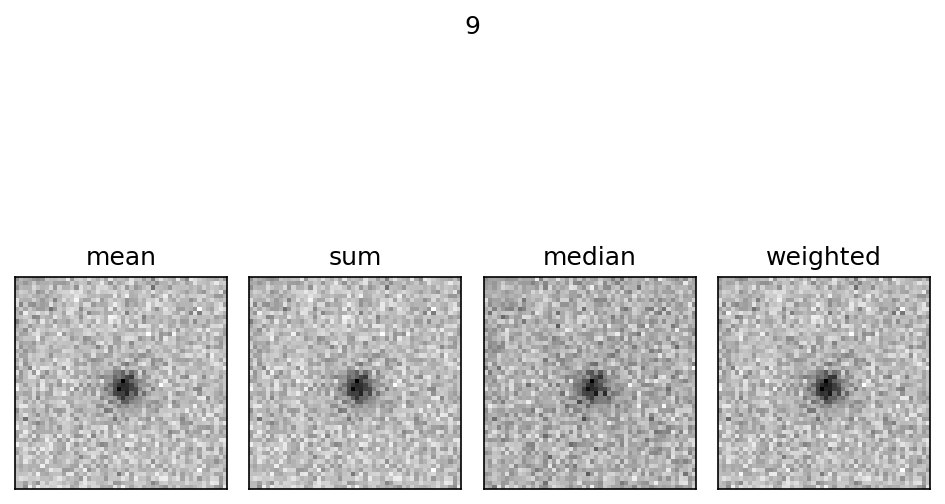

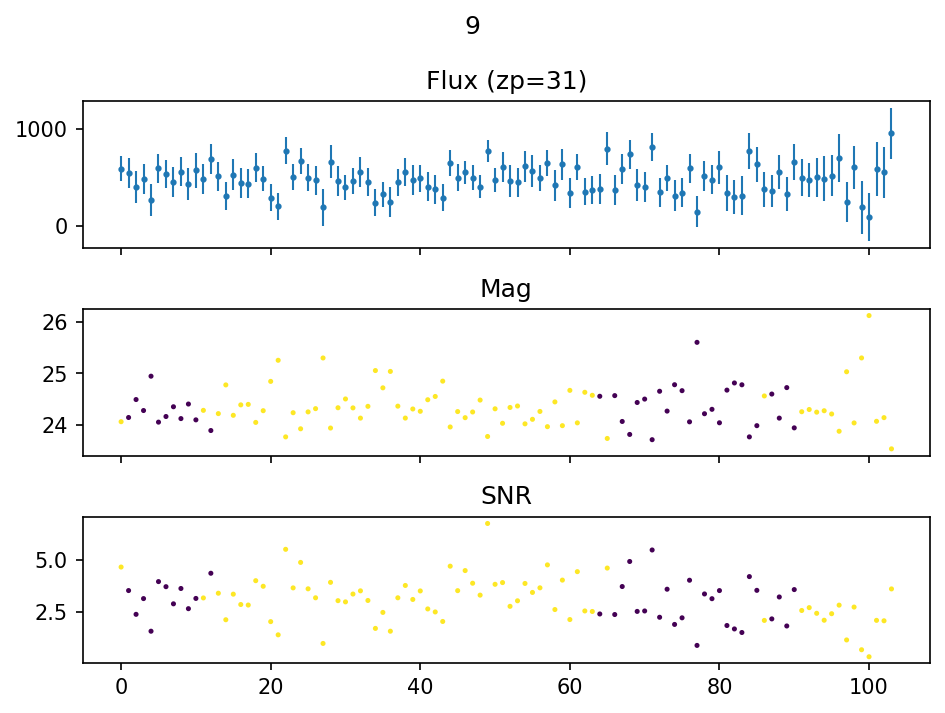

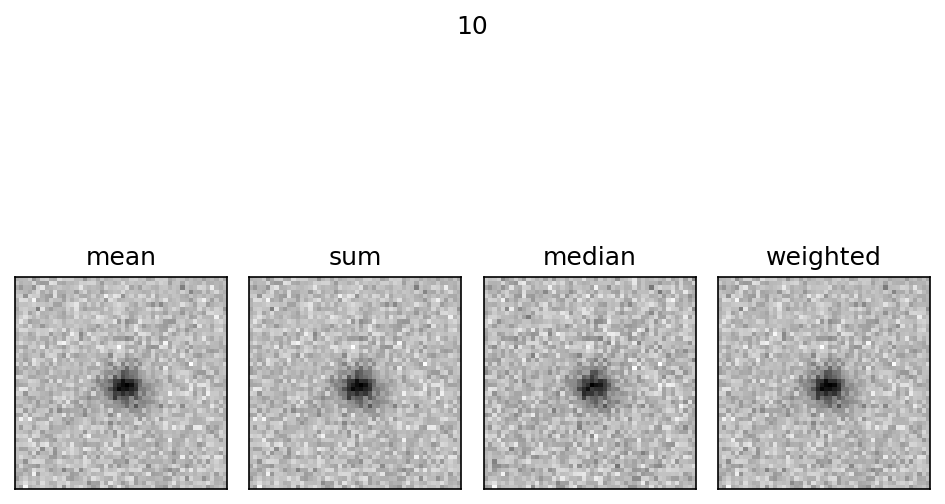

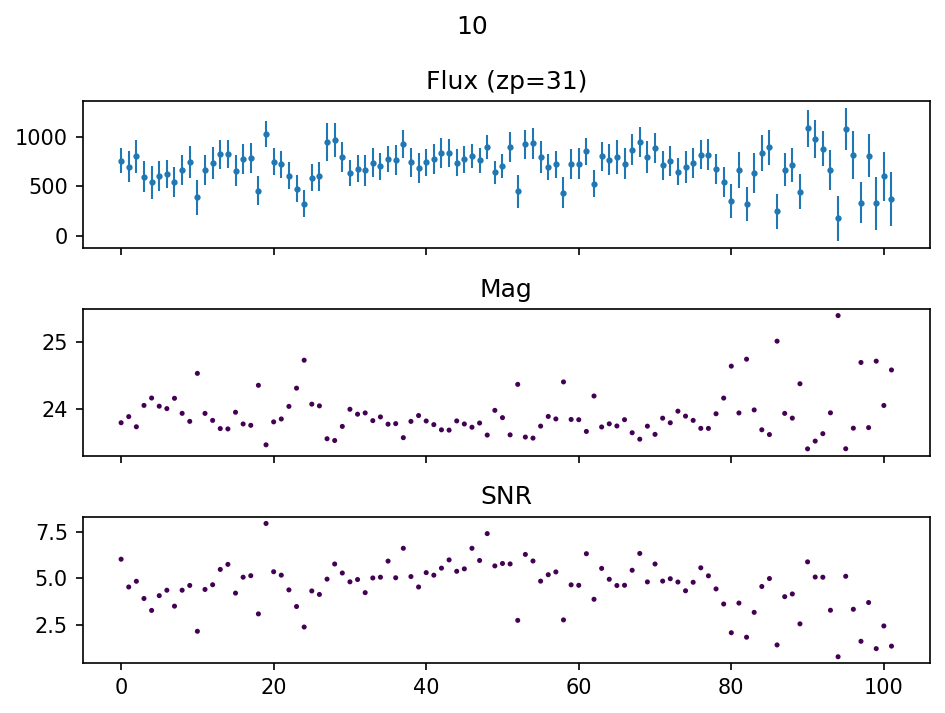

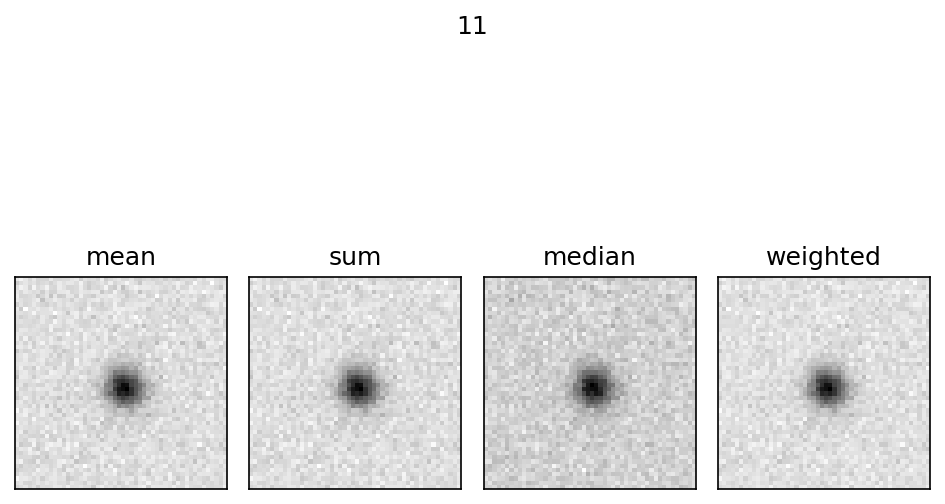

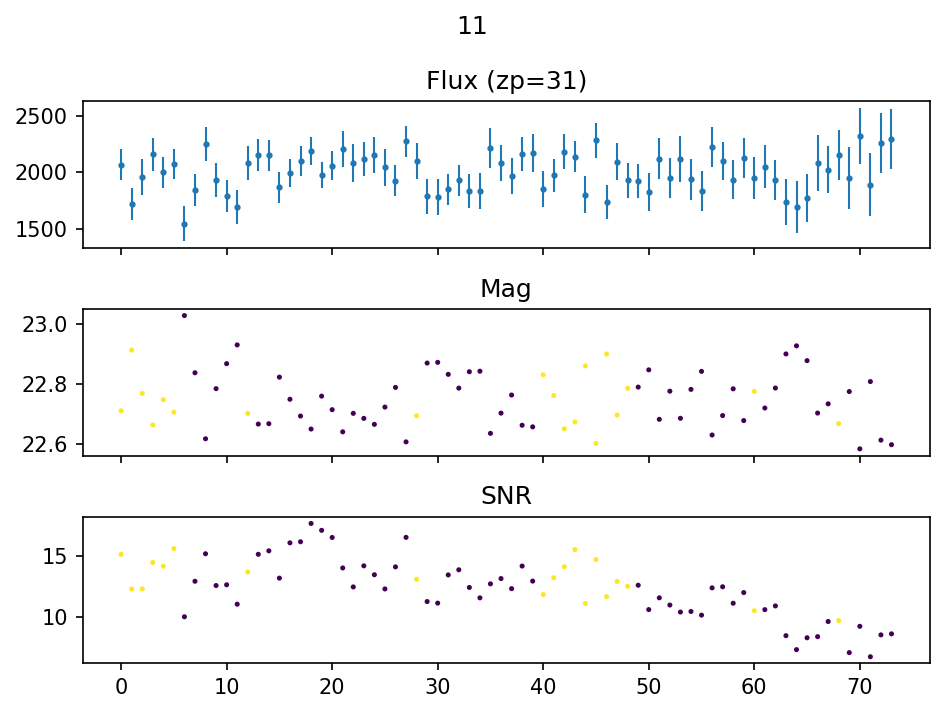

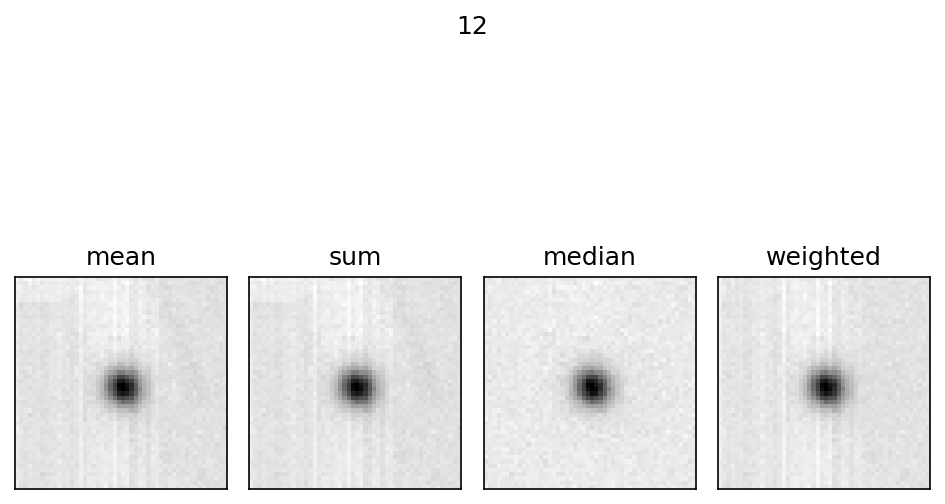

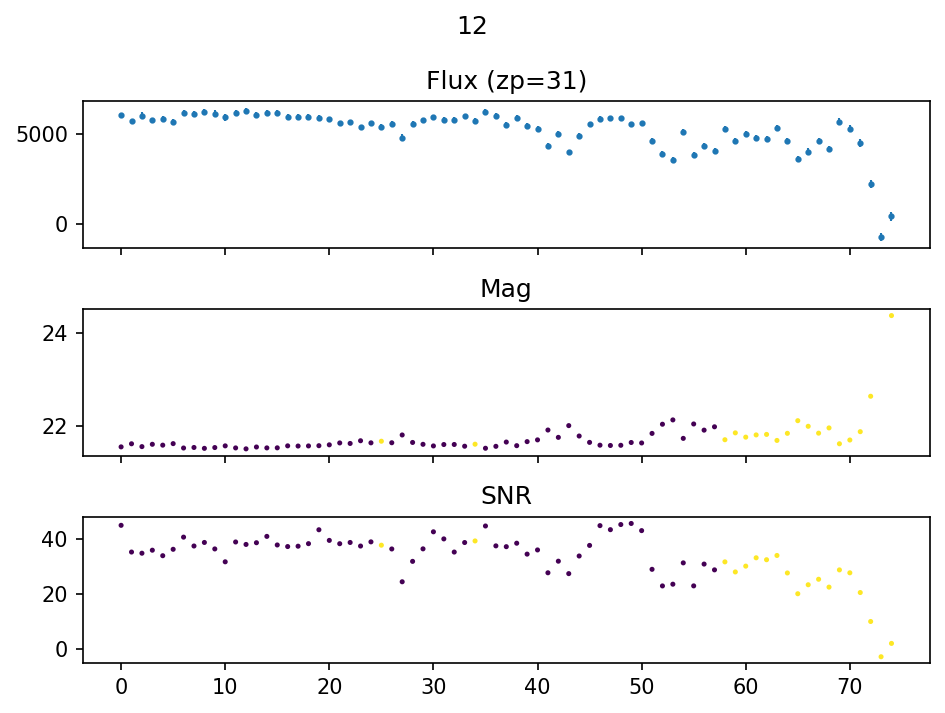

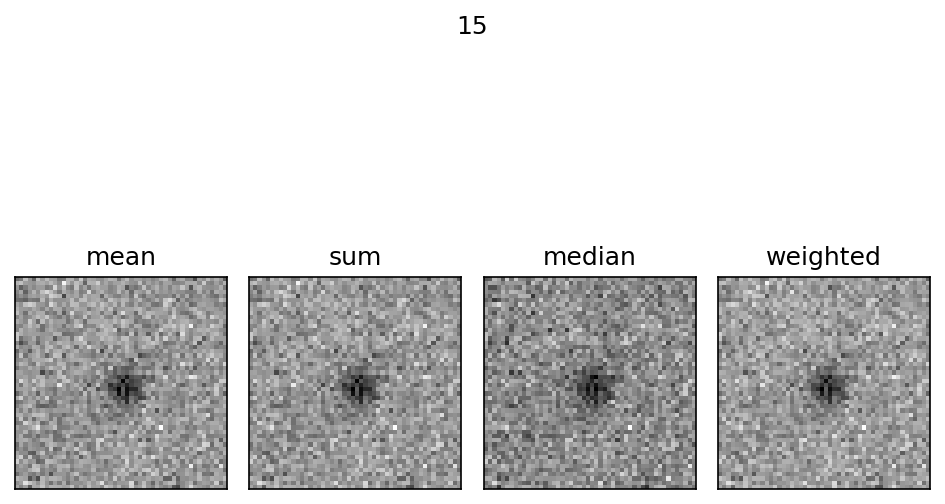

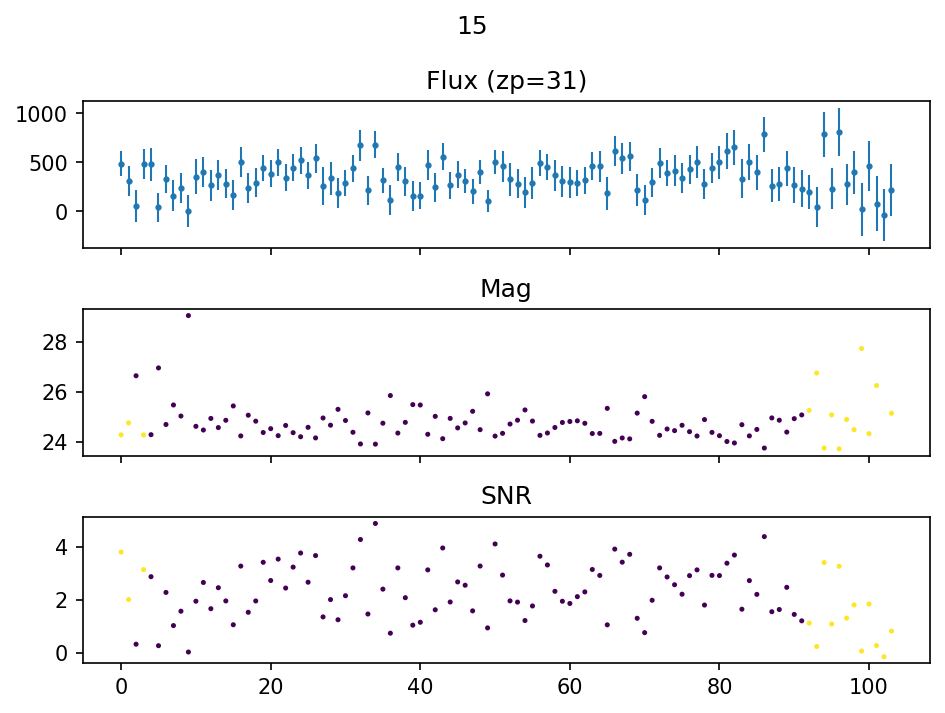

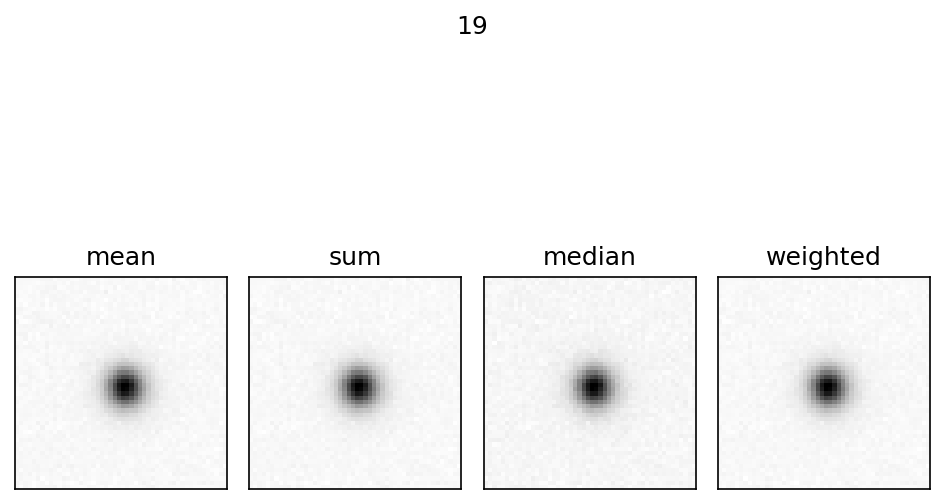

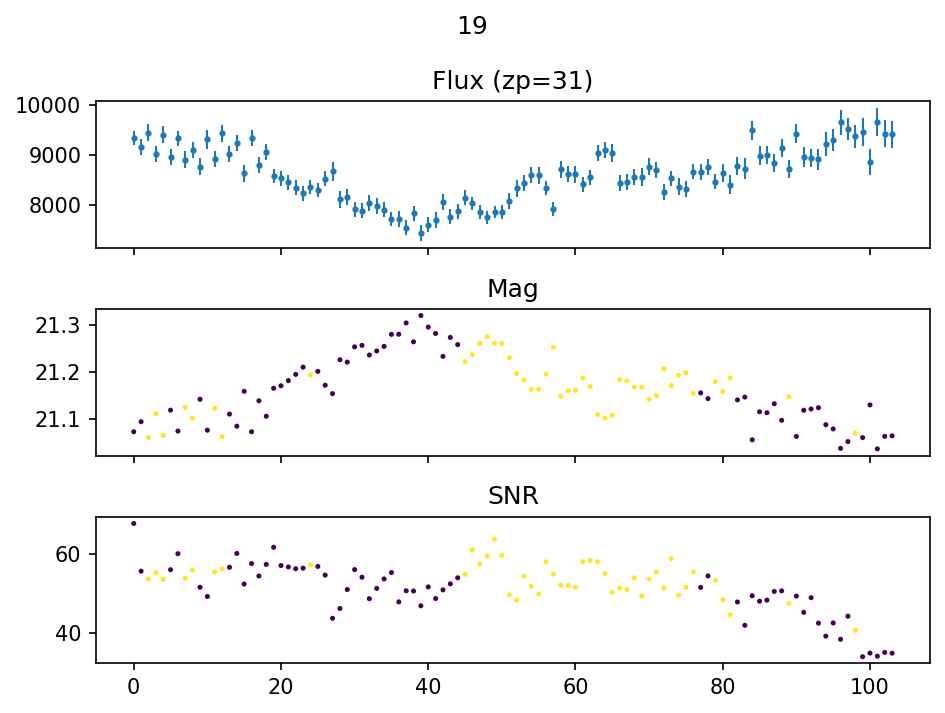

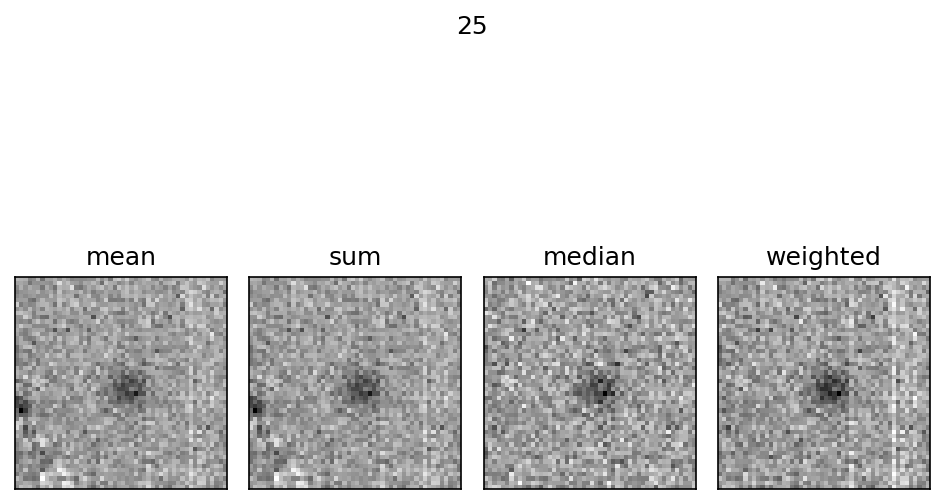

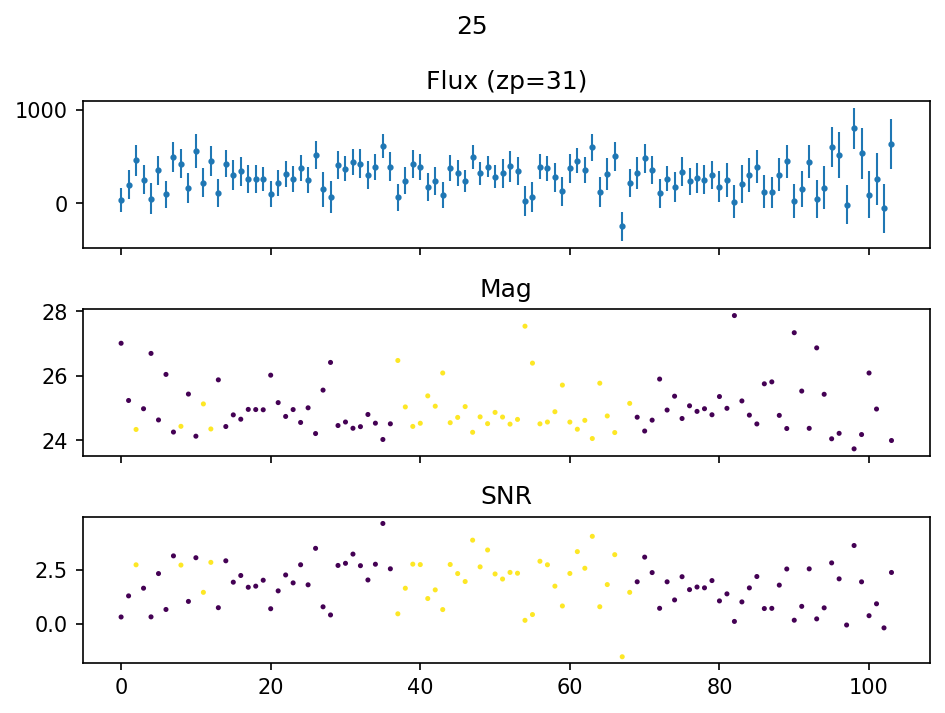

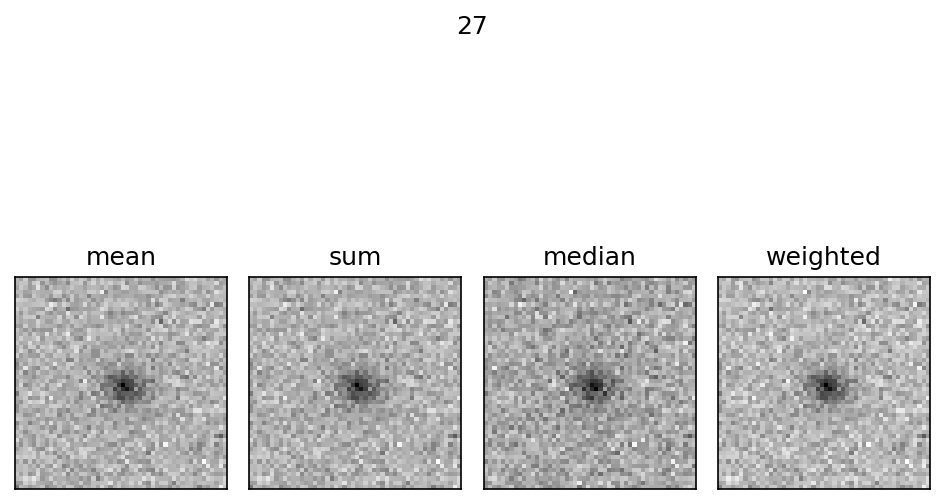

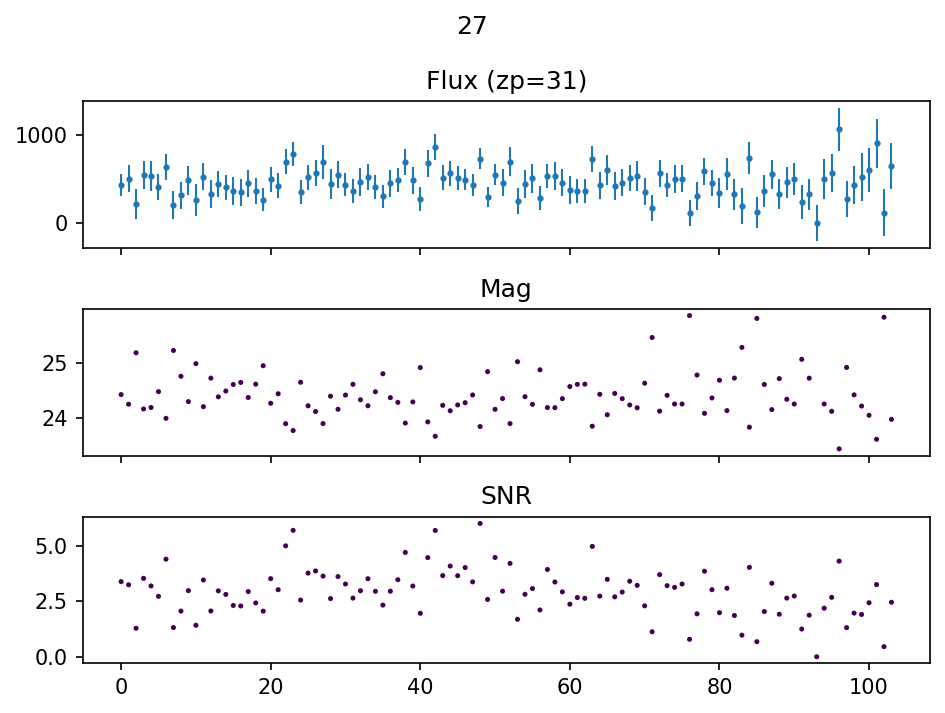

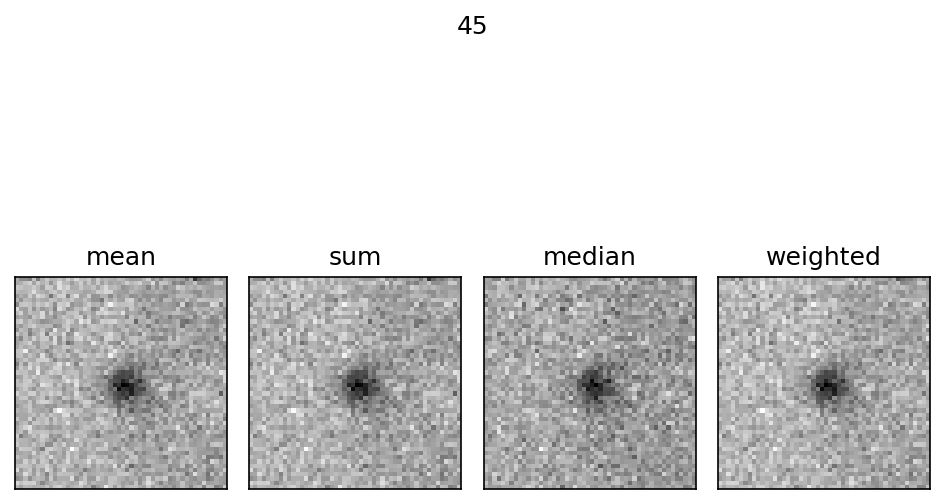

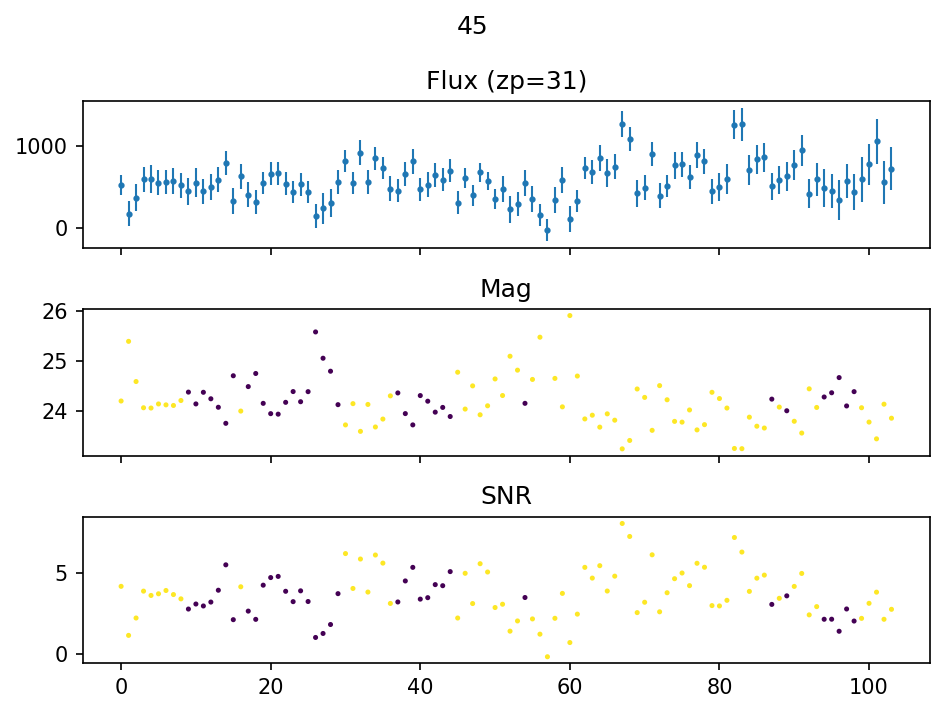

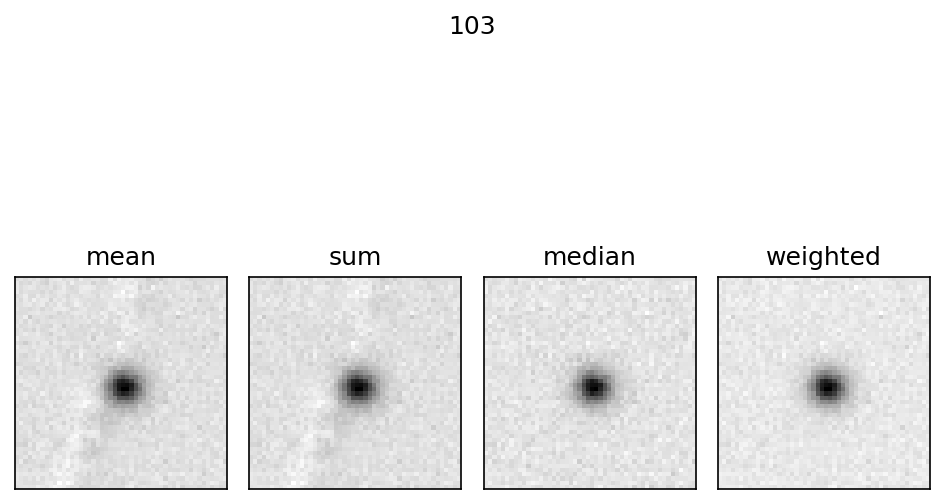

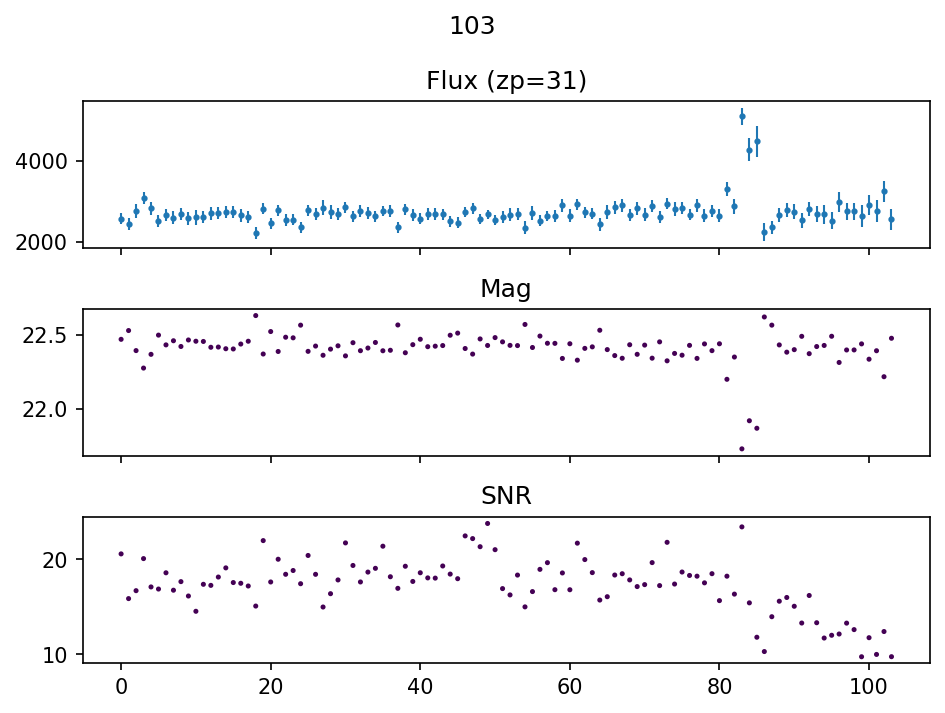

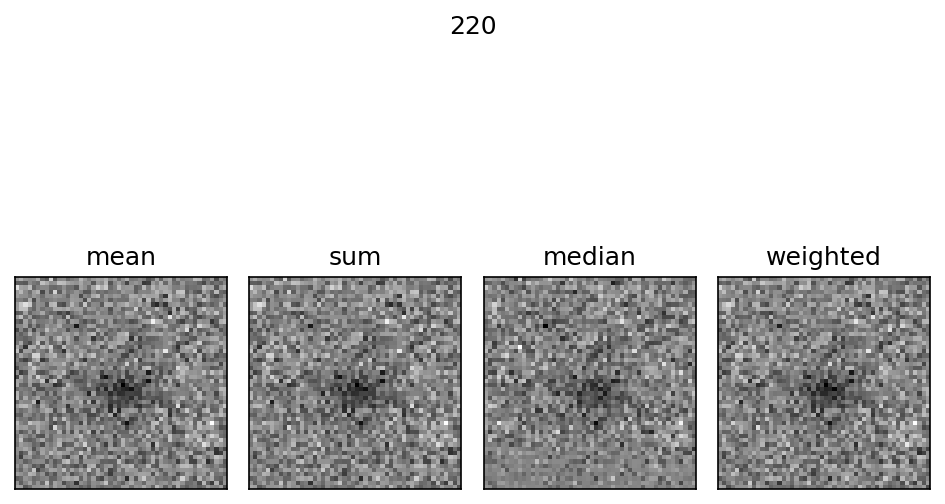

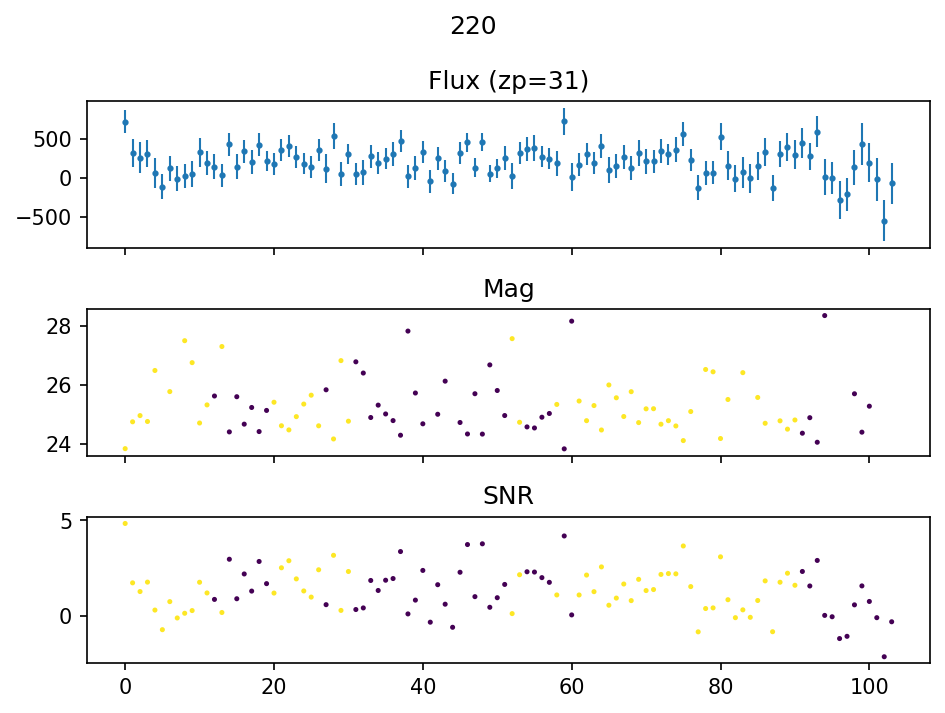

In [305]:
for k in c:
    plot_summary_coadds(c[k].summary)
    fig = plt.gcf()
    fig.suptitle(k)
    fig.tight_layout()
    plt.show()
    plot_summary_light_curve(c[k].summary)
    fig = plt.gcf()
    fig.suptitle(k)
    fig.tight_layout()    
    plt.show()

In [266]:
list(filtered[4].keys())[25]

256

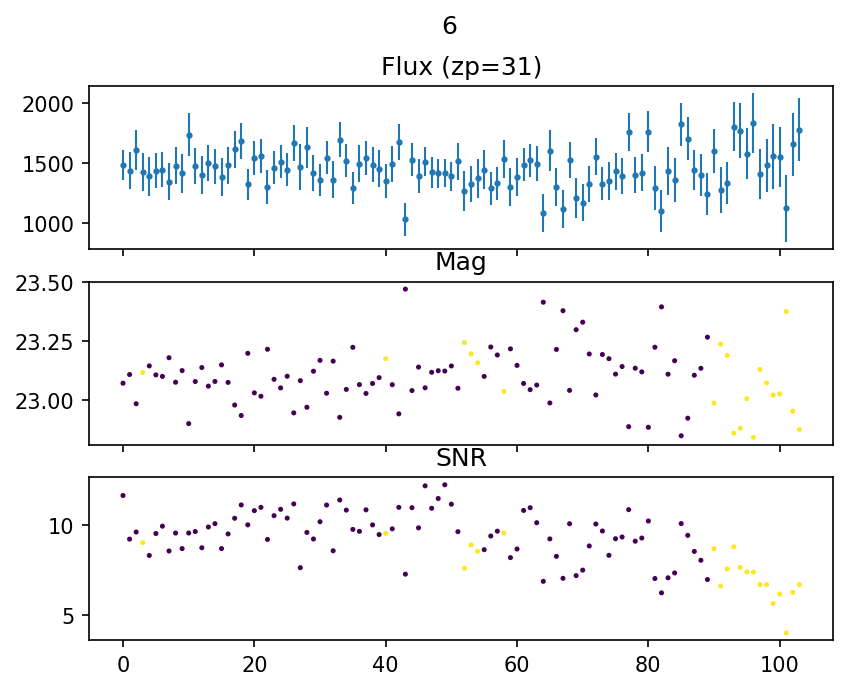

In [268]:
i = 6
plot_summary_light_curve(filtered[4][i].summary)
fig = plt.gcf()
fig.suptitle(i)
plt.show()

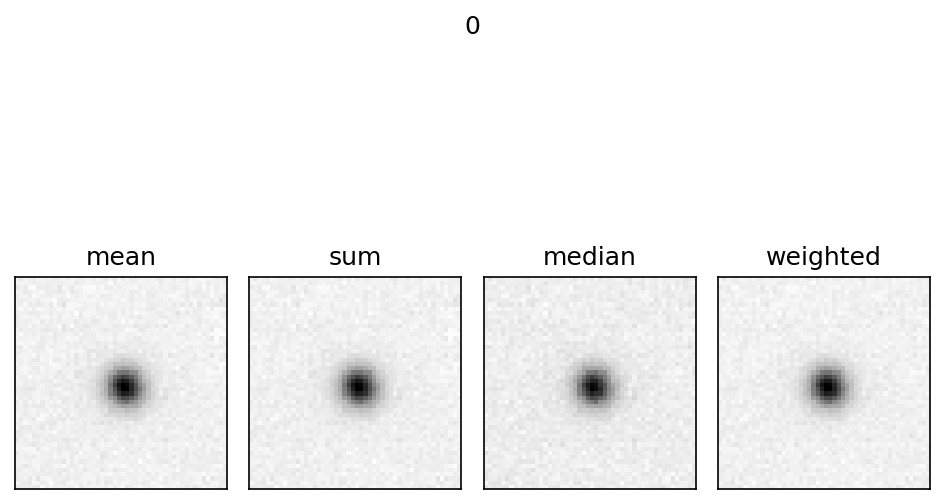

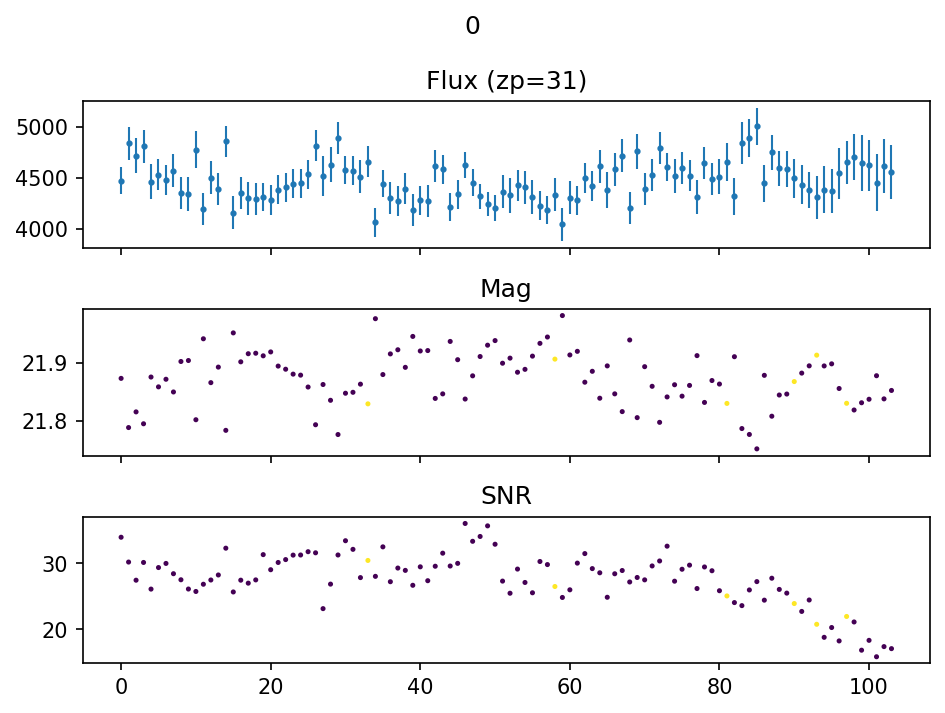

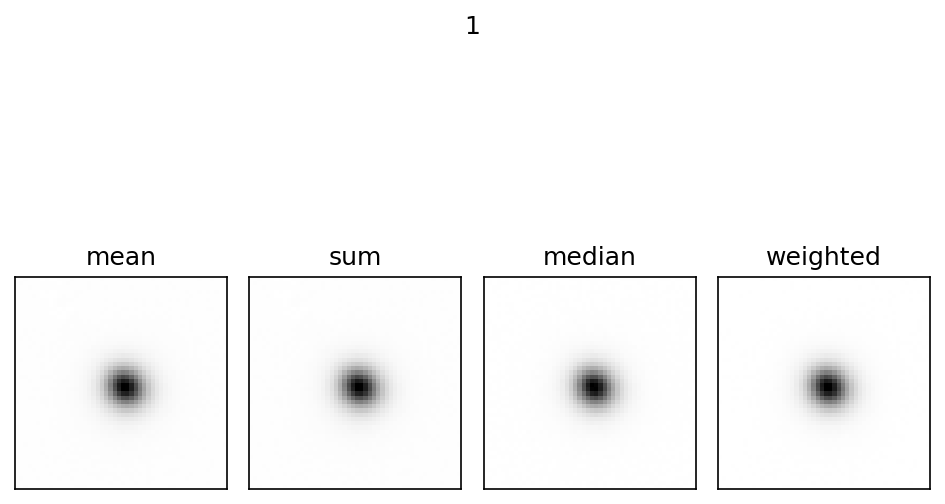

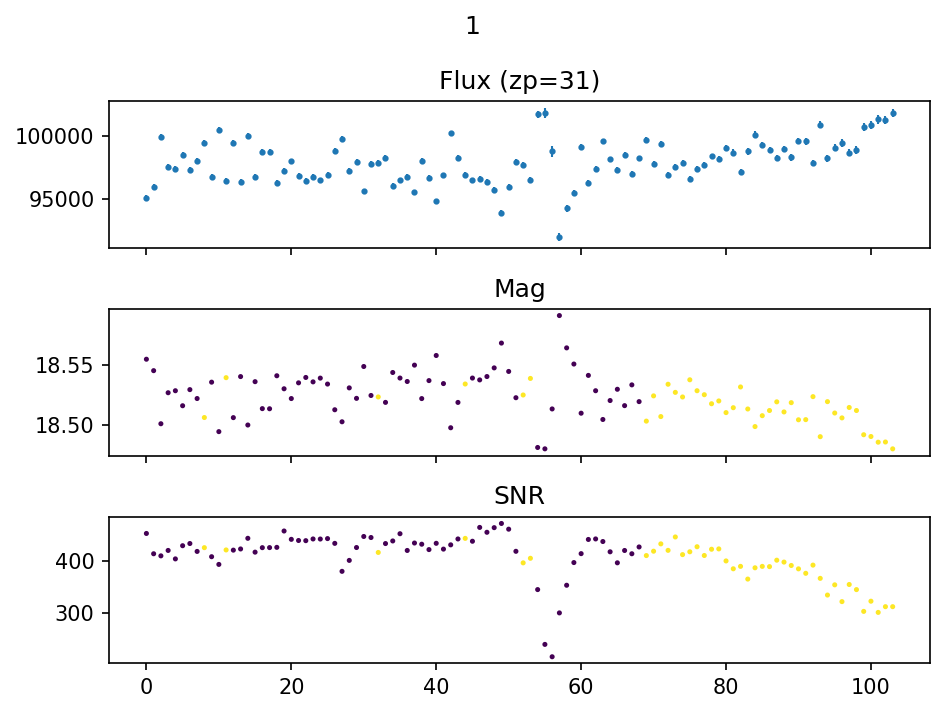

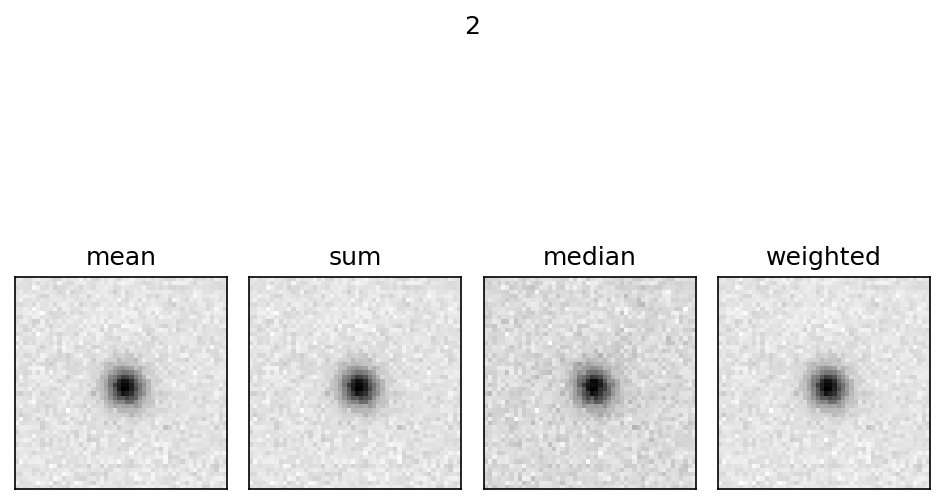

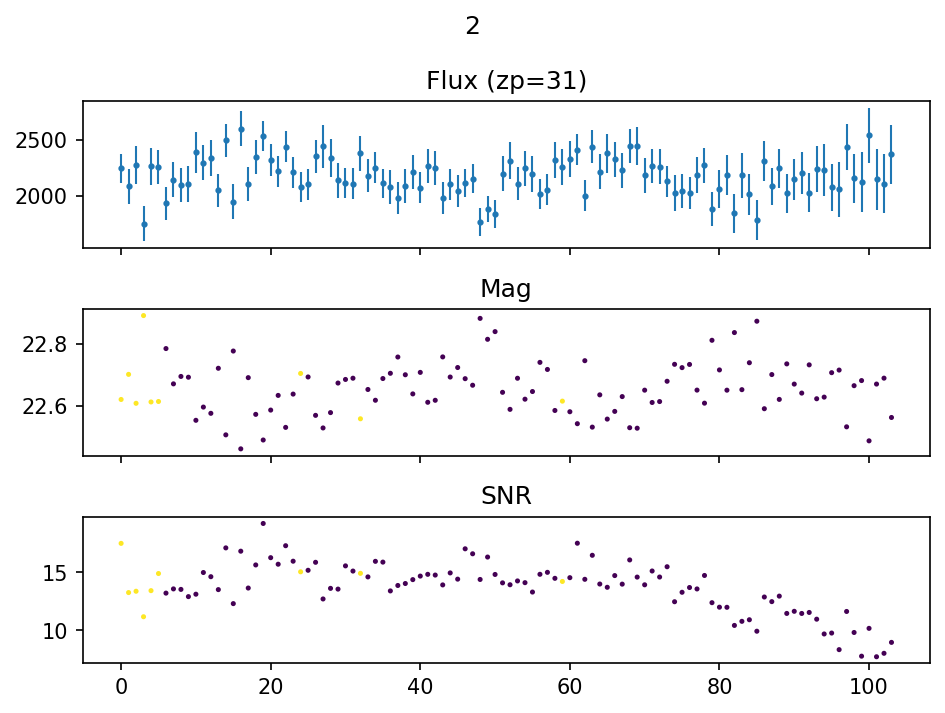

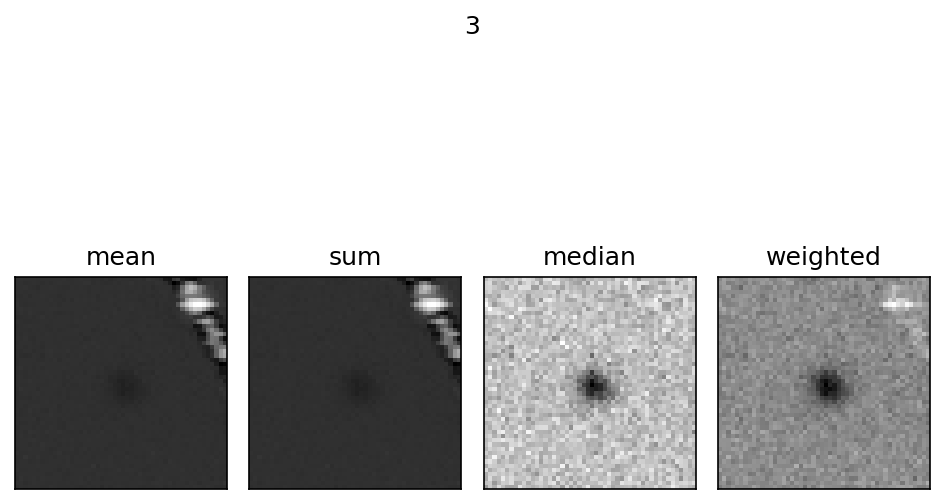

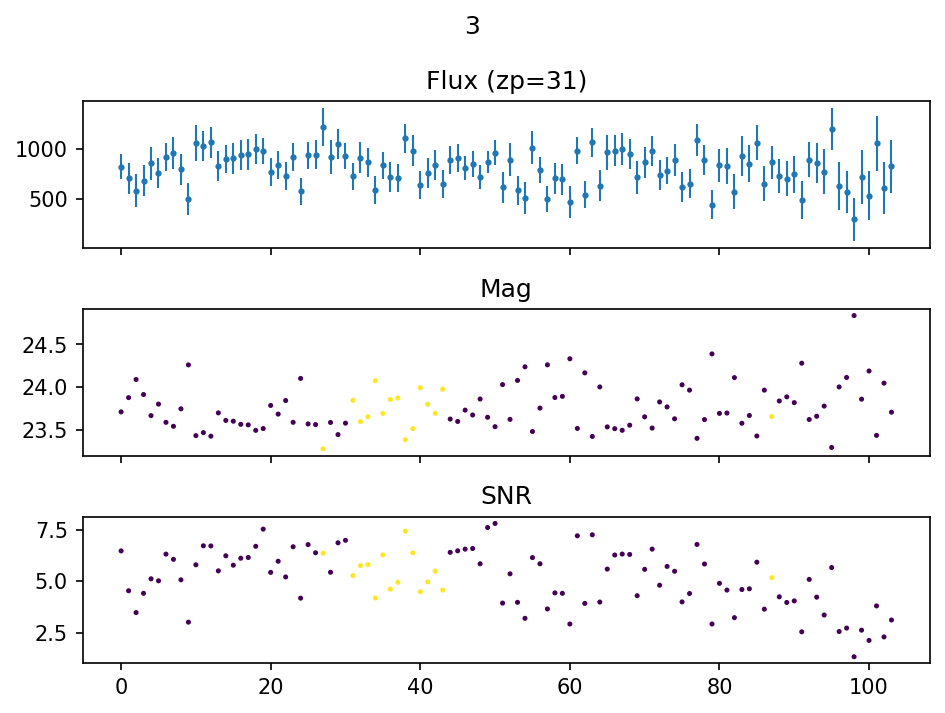

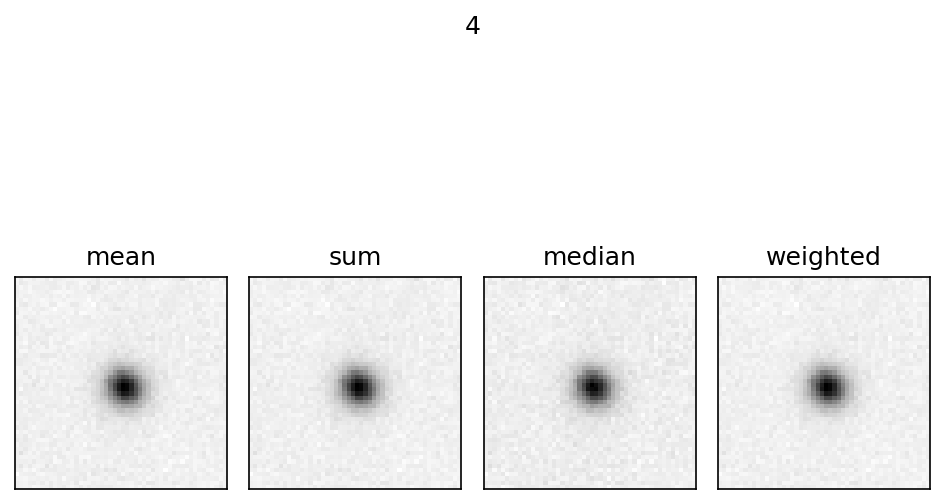

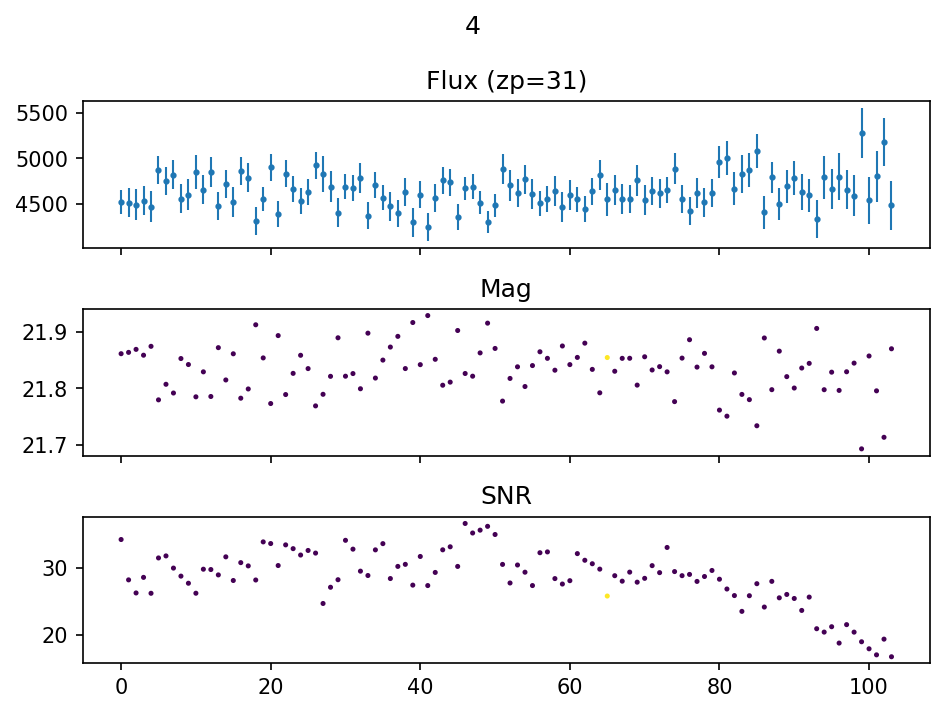

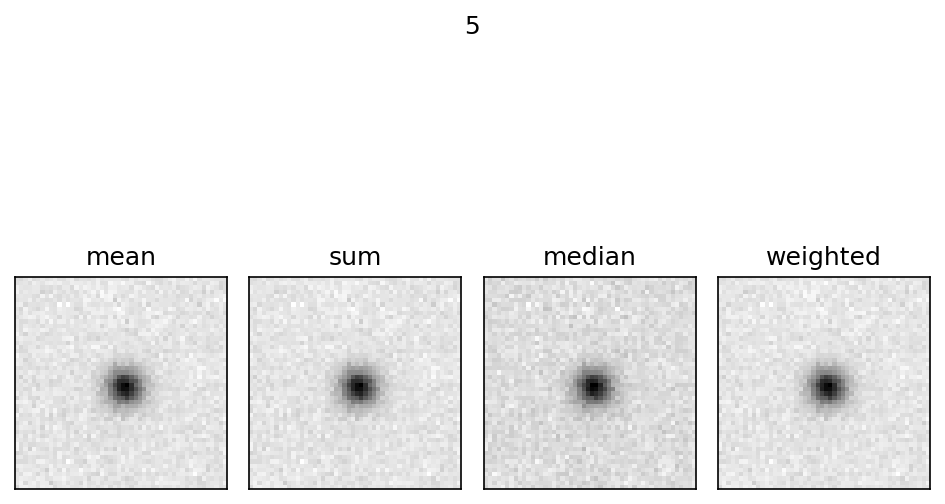

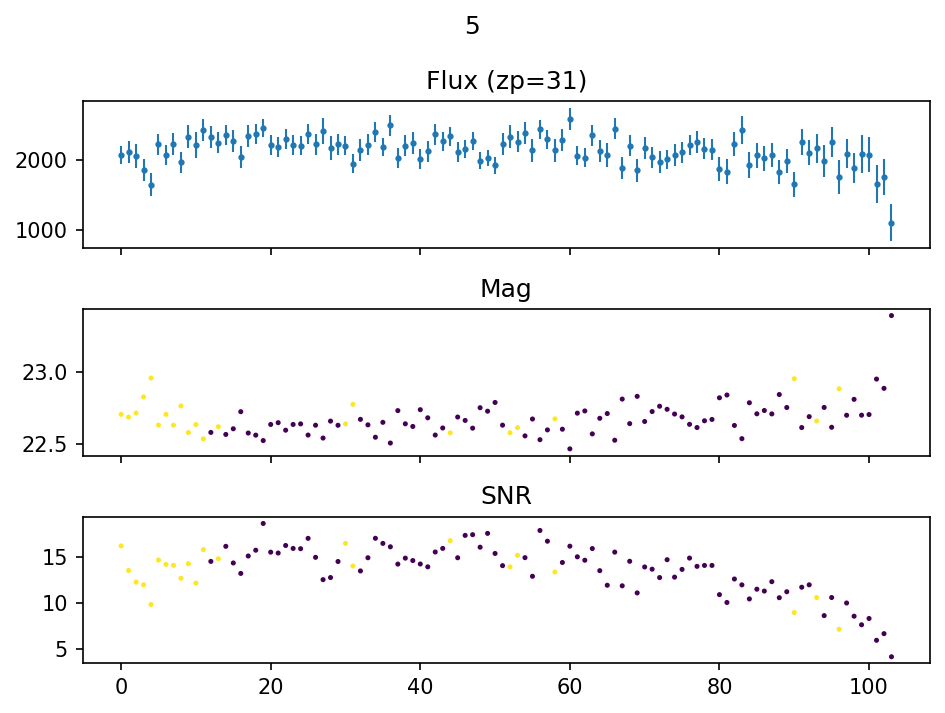

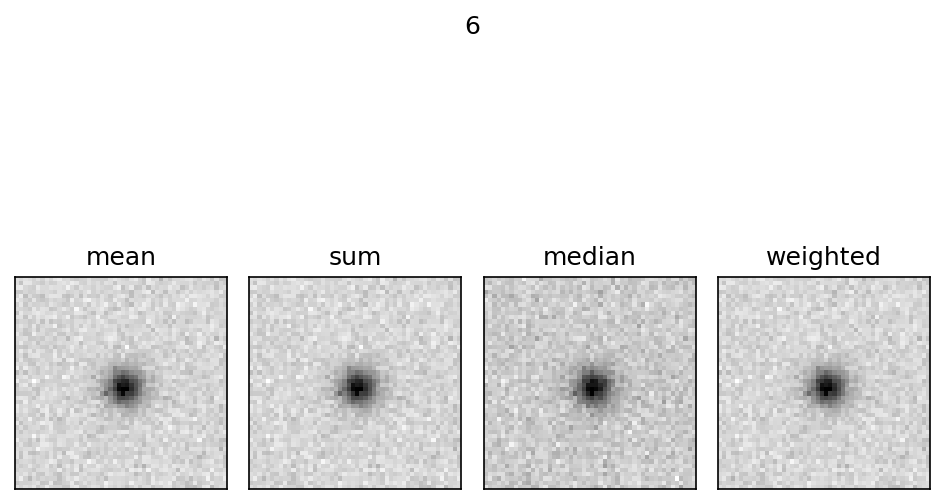

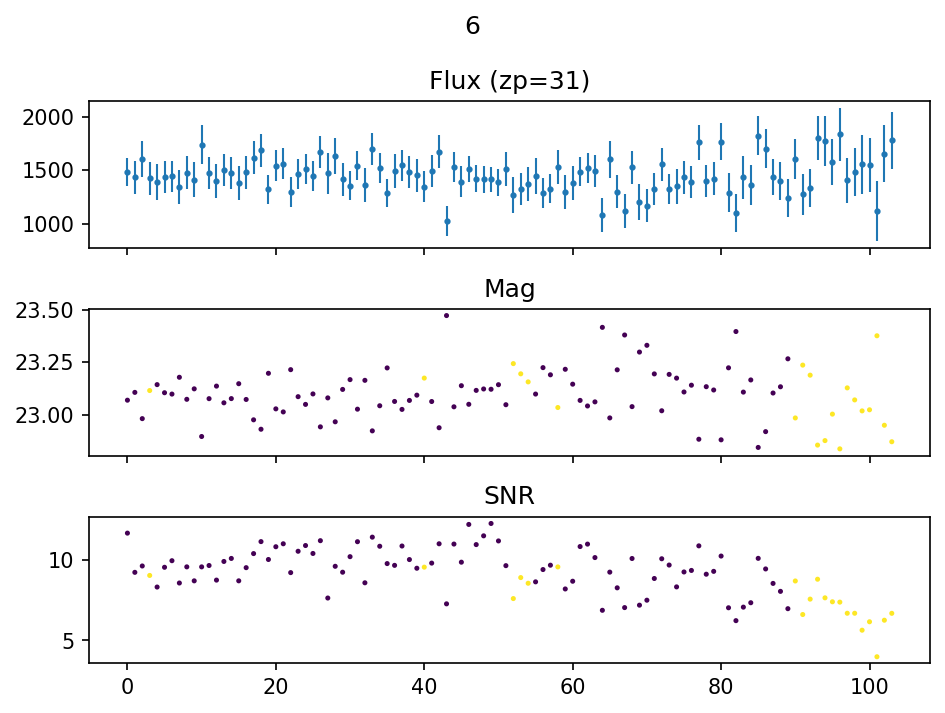

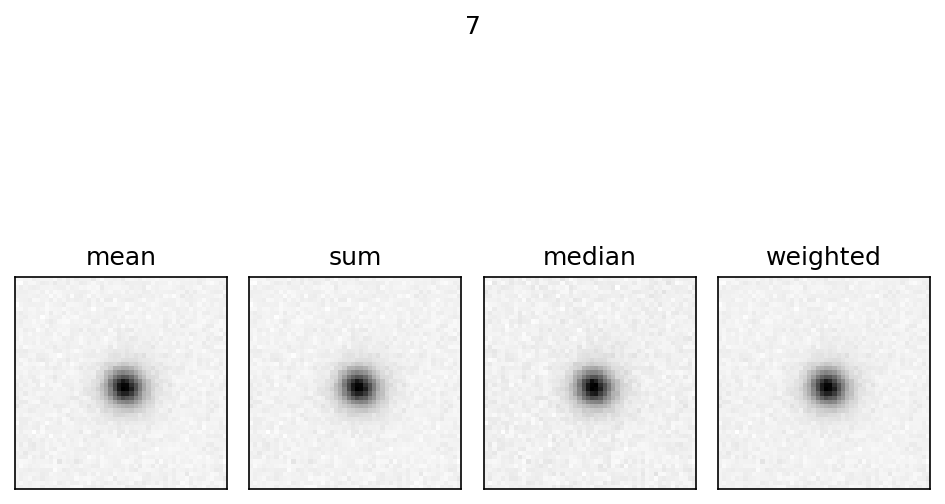

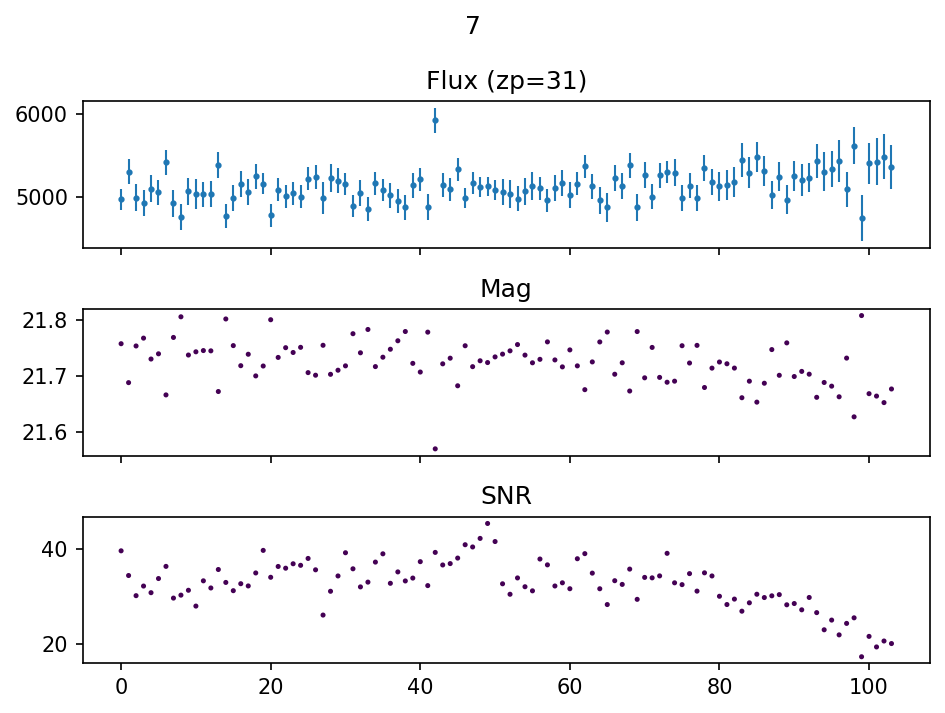

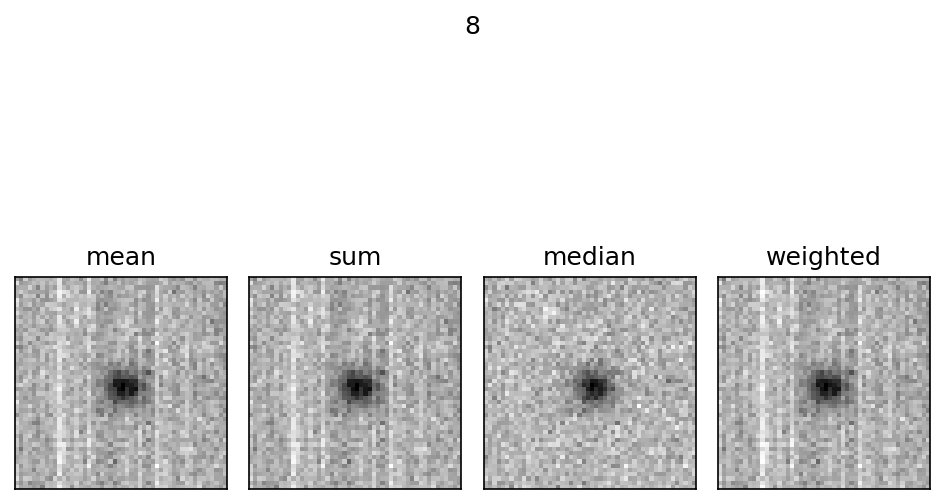

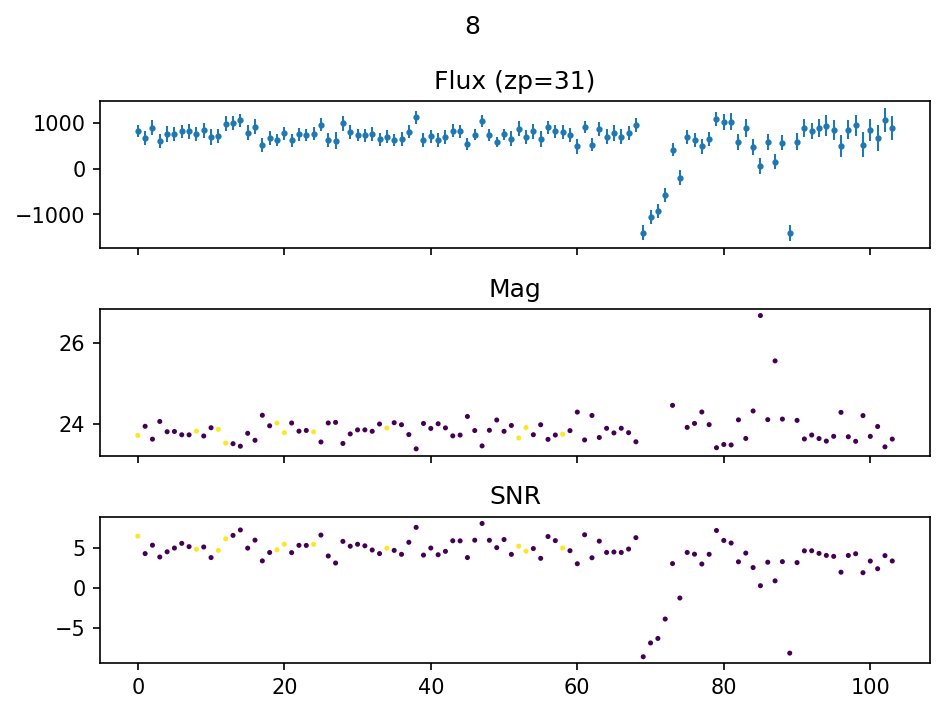

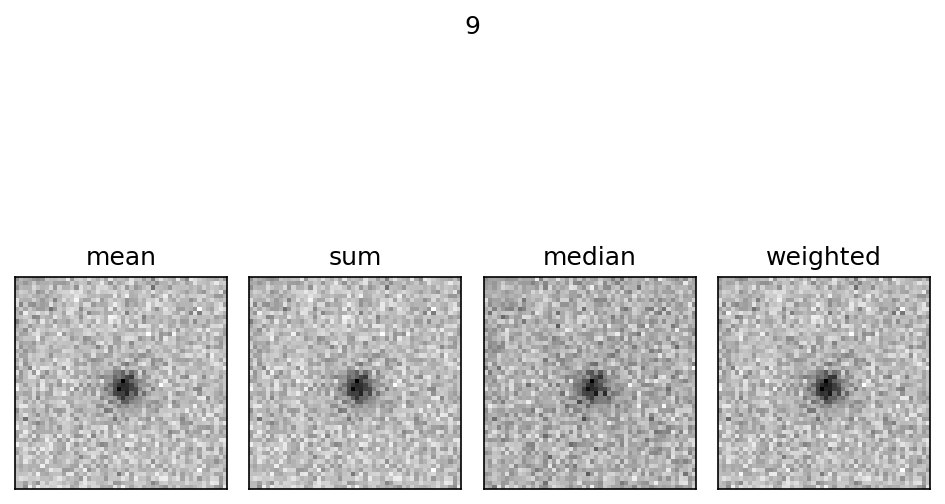

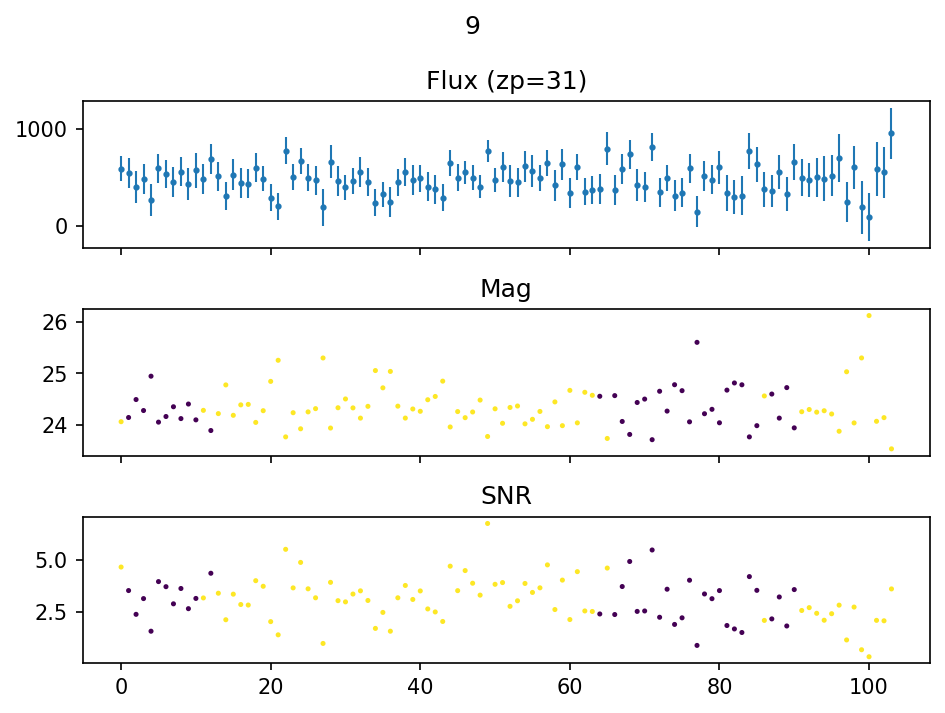

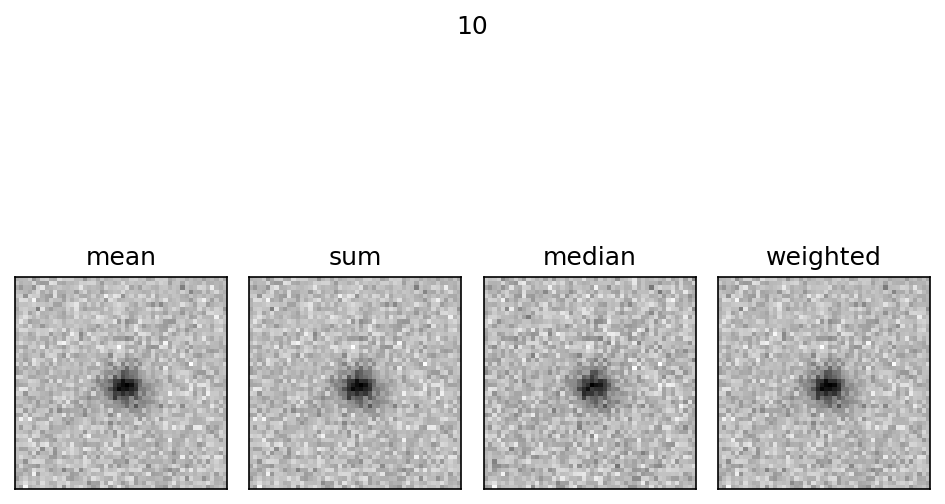

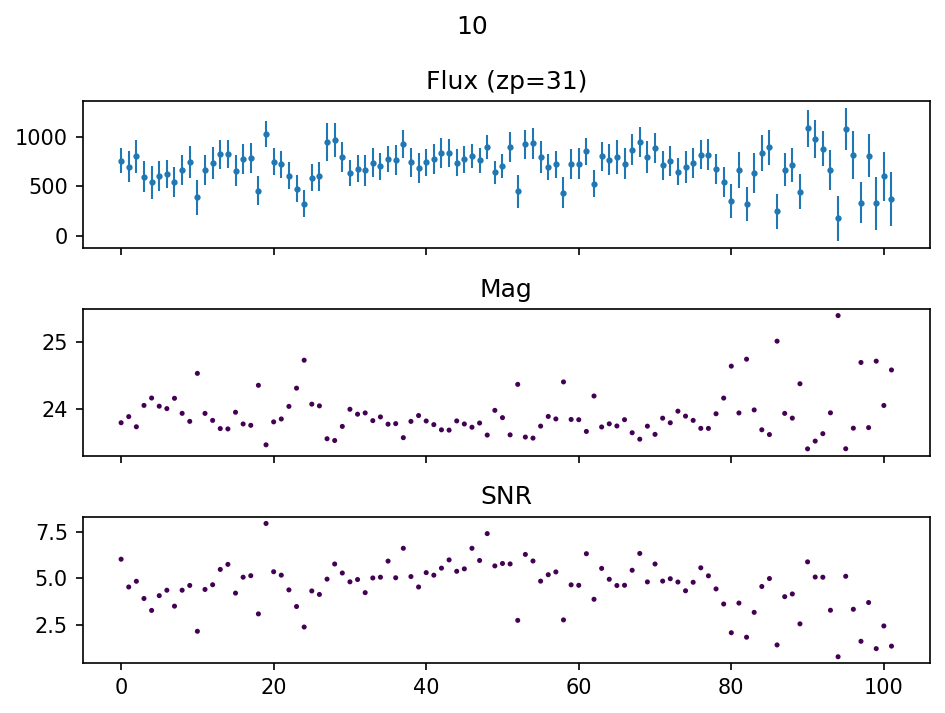

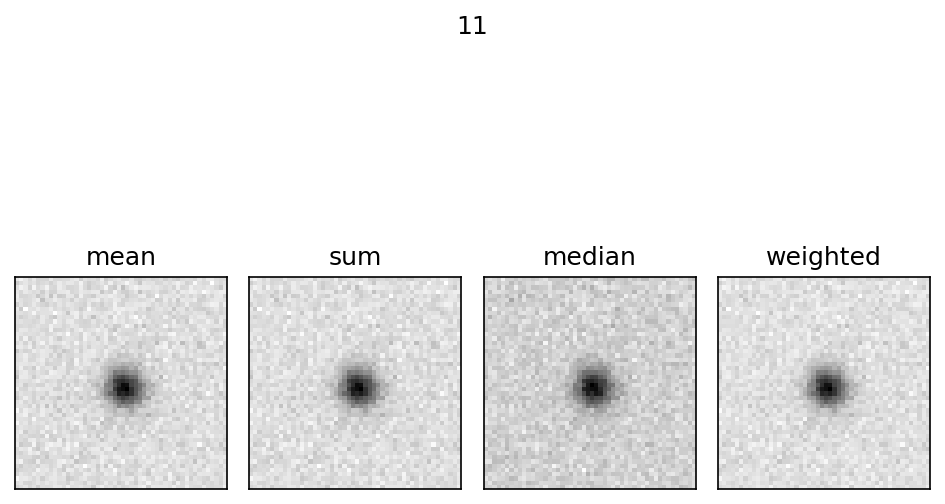

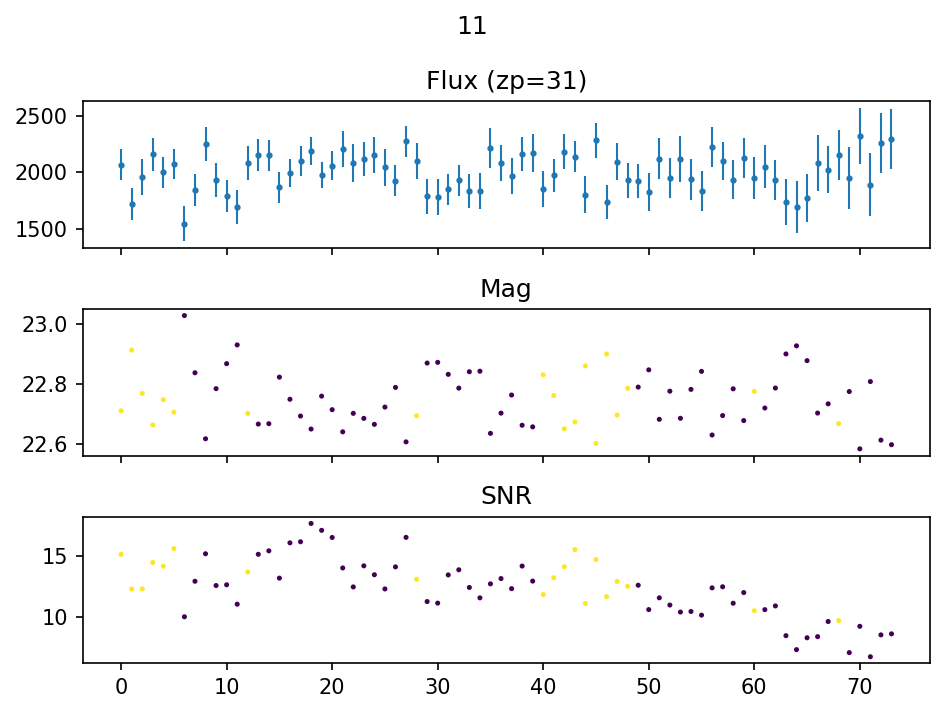

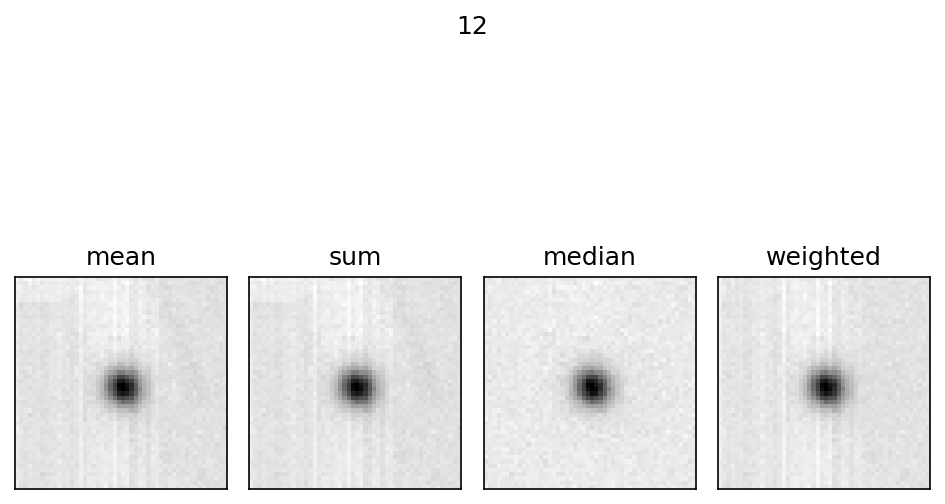

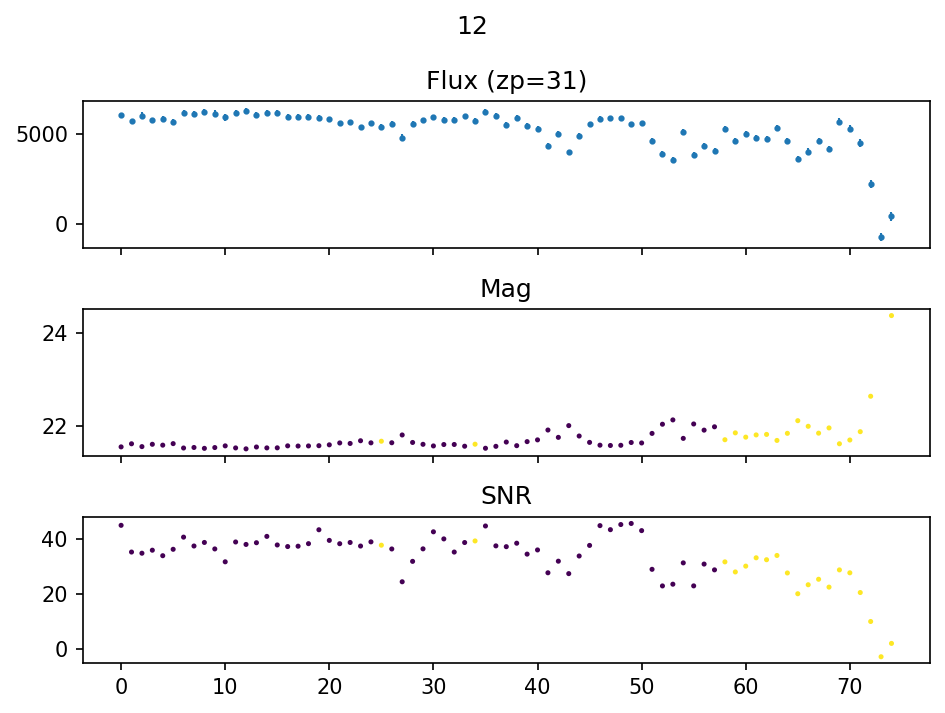

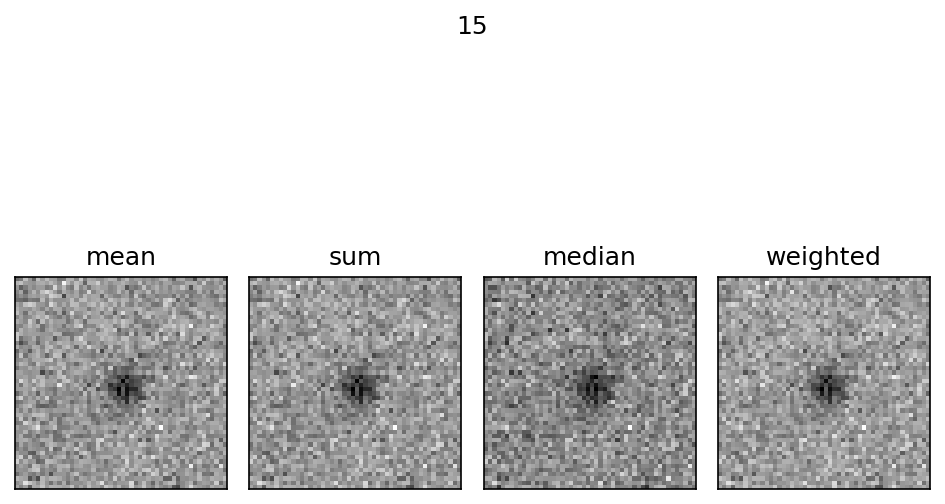

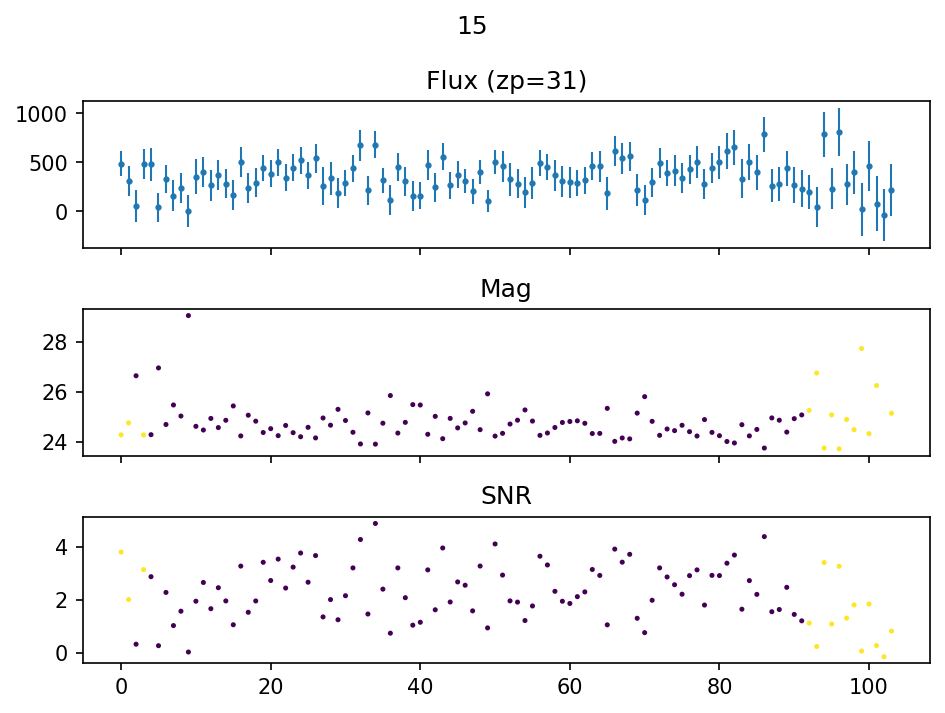

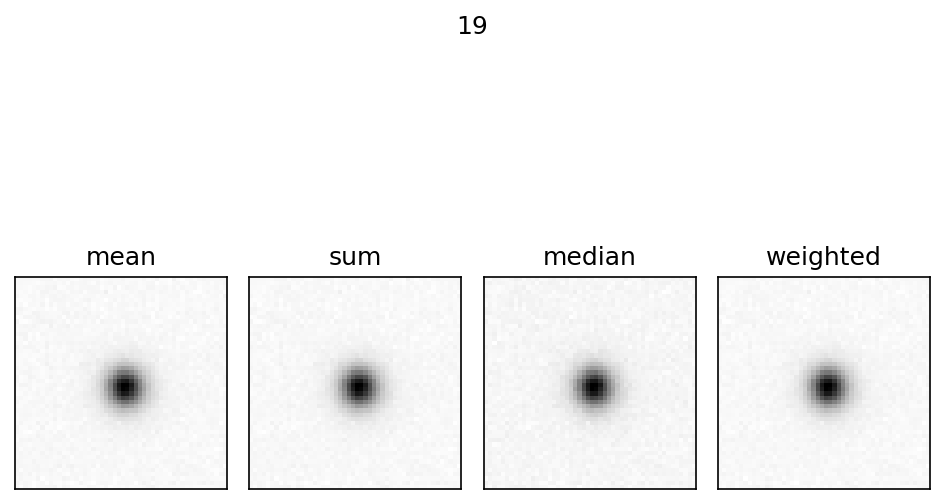

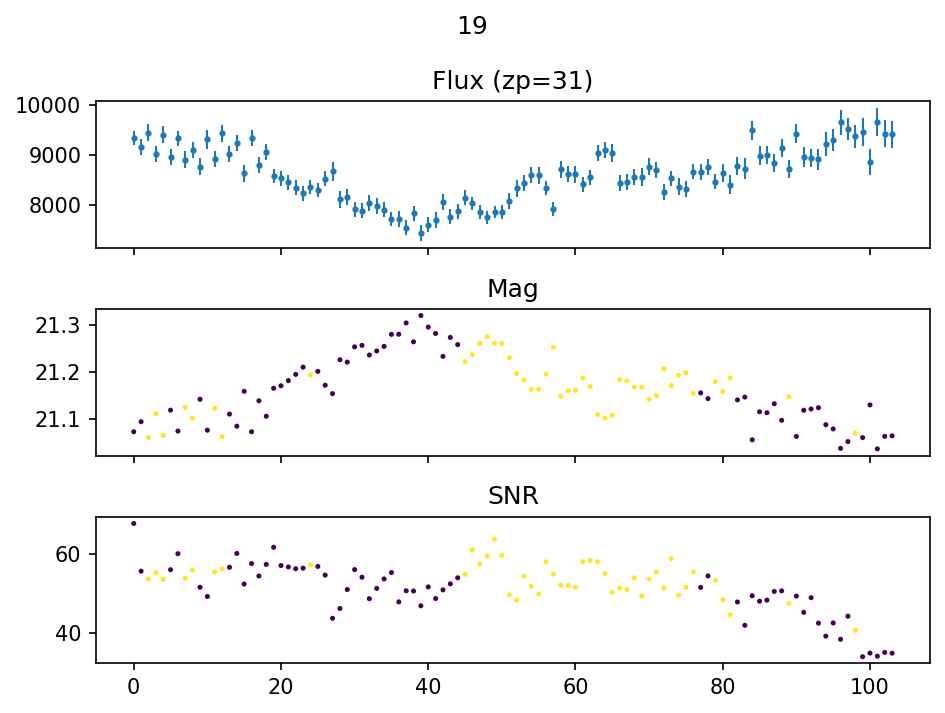

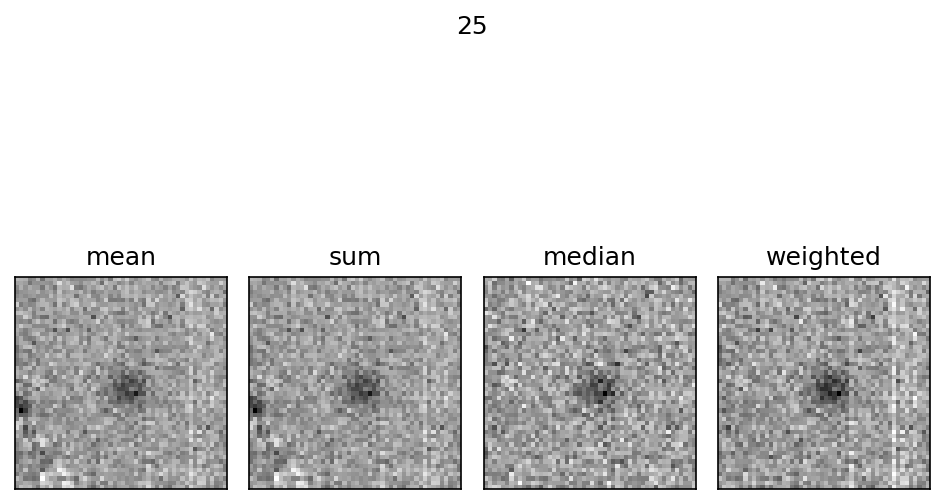

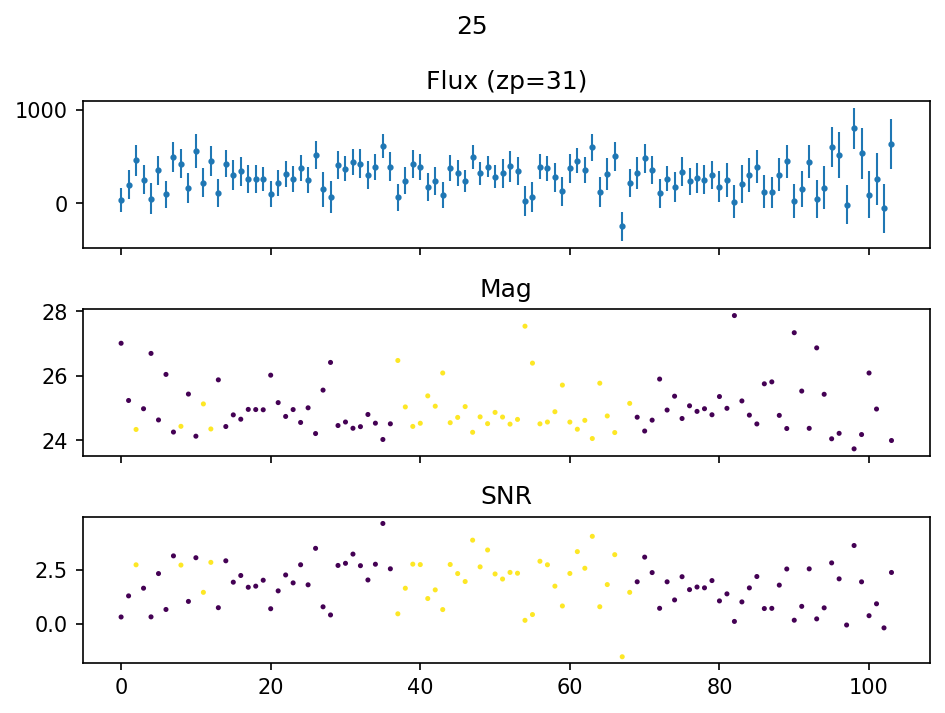

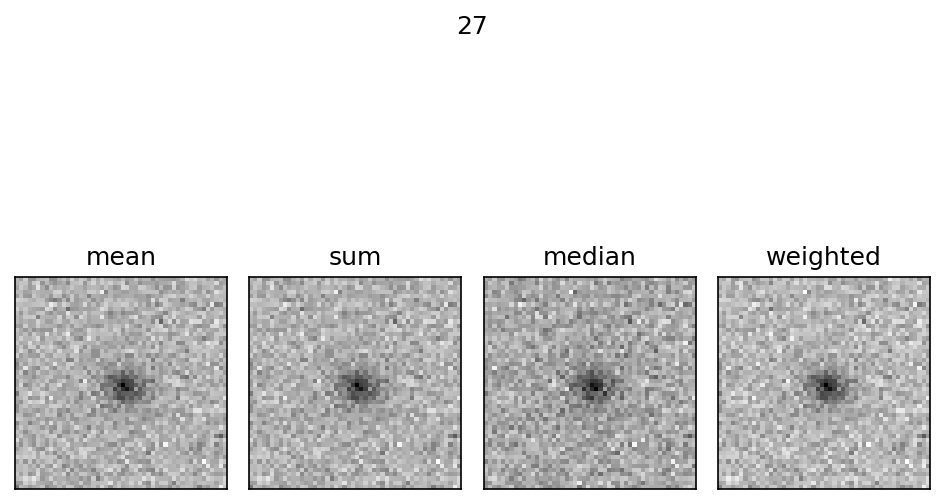

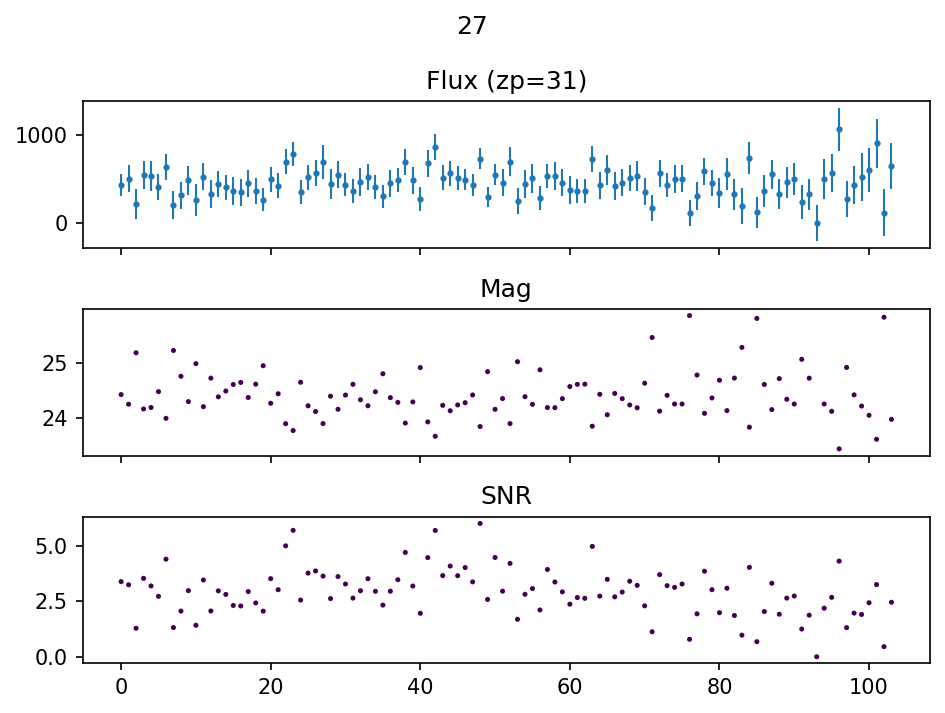

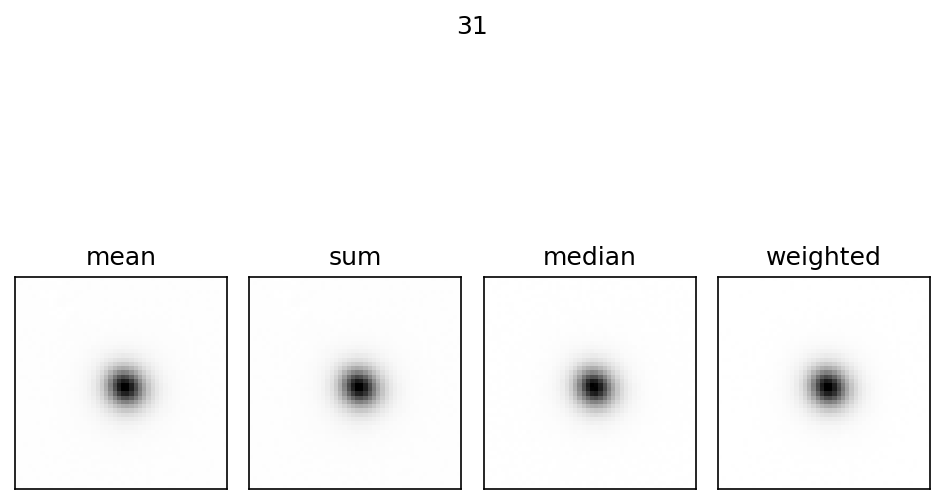

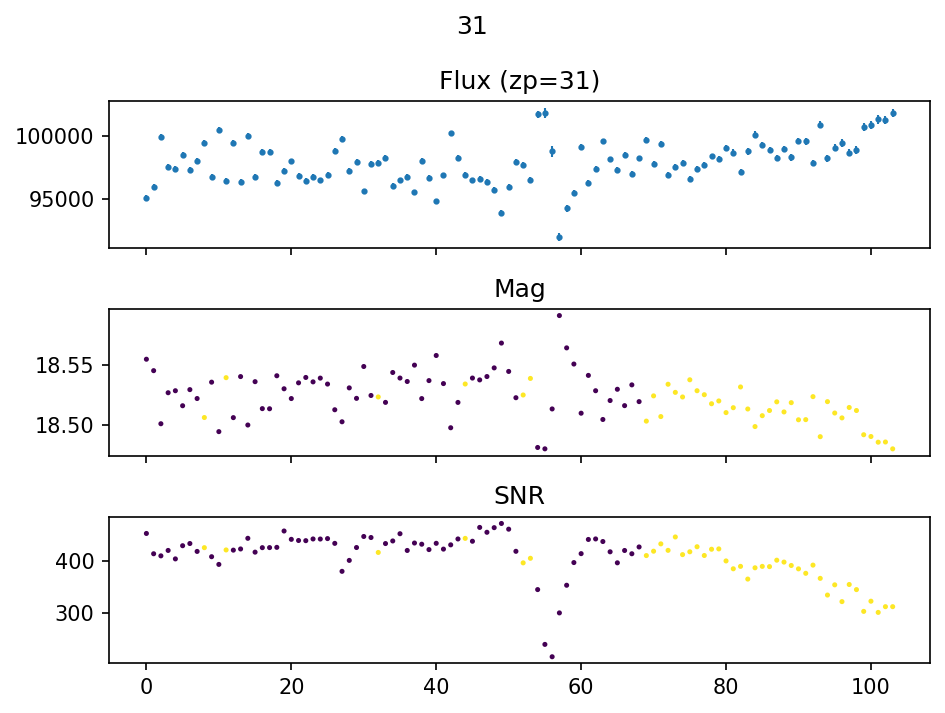

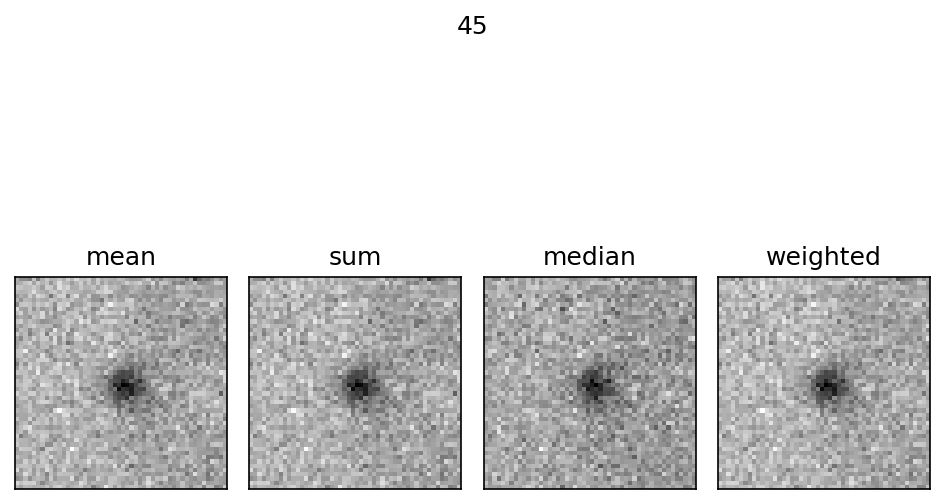

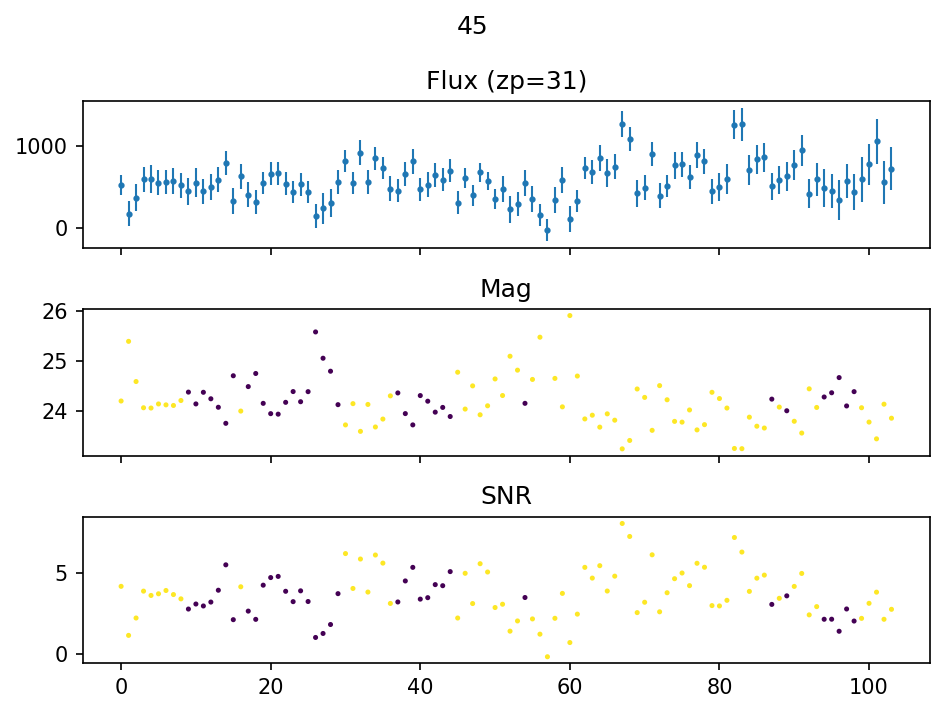

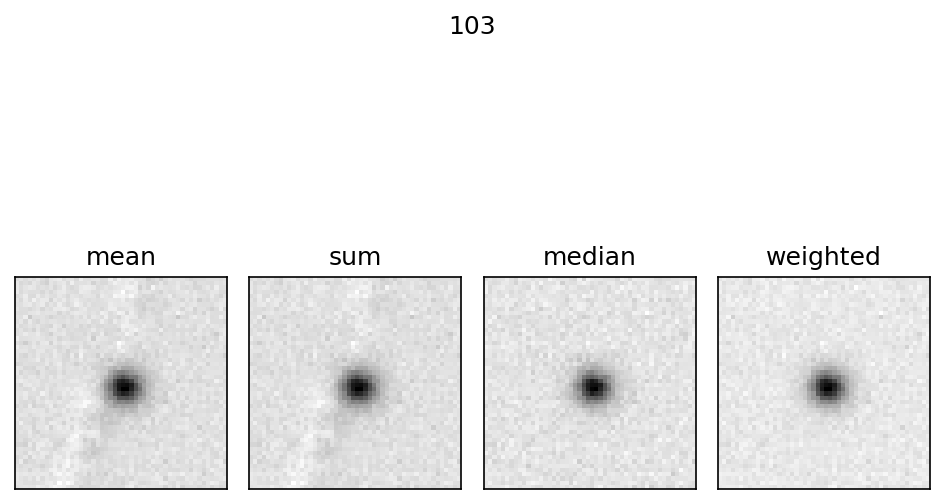

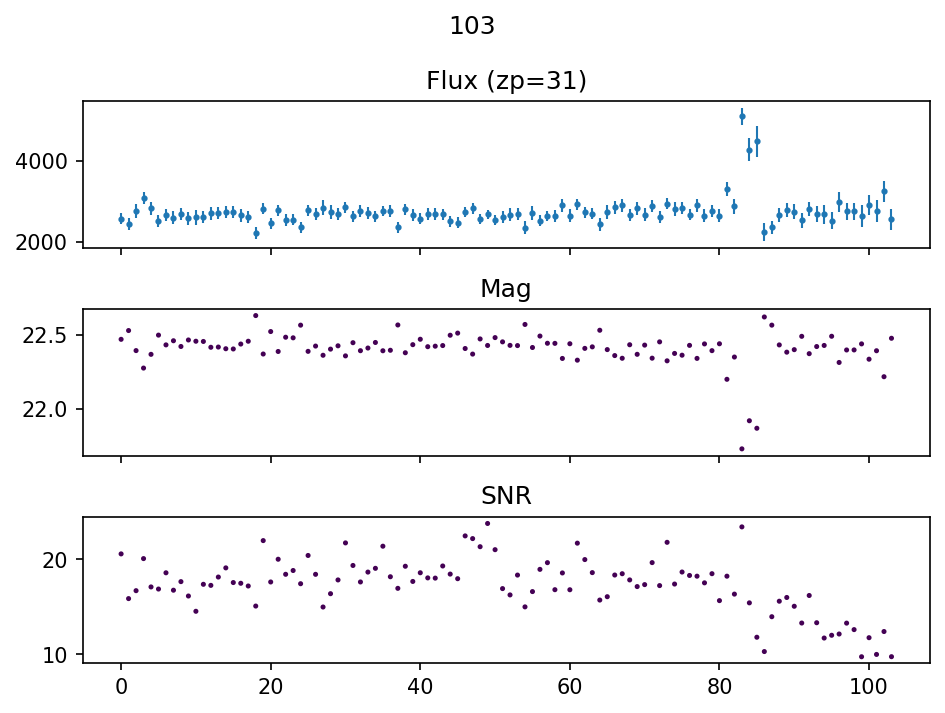

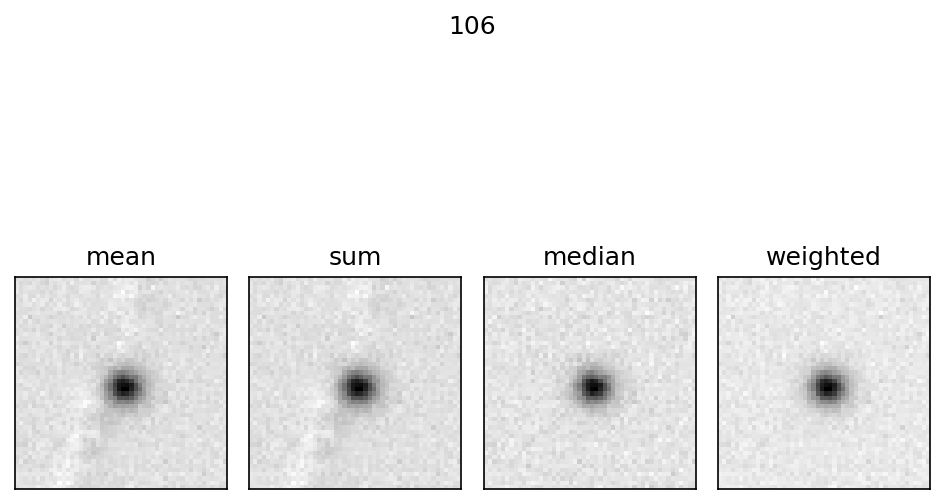

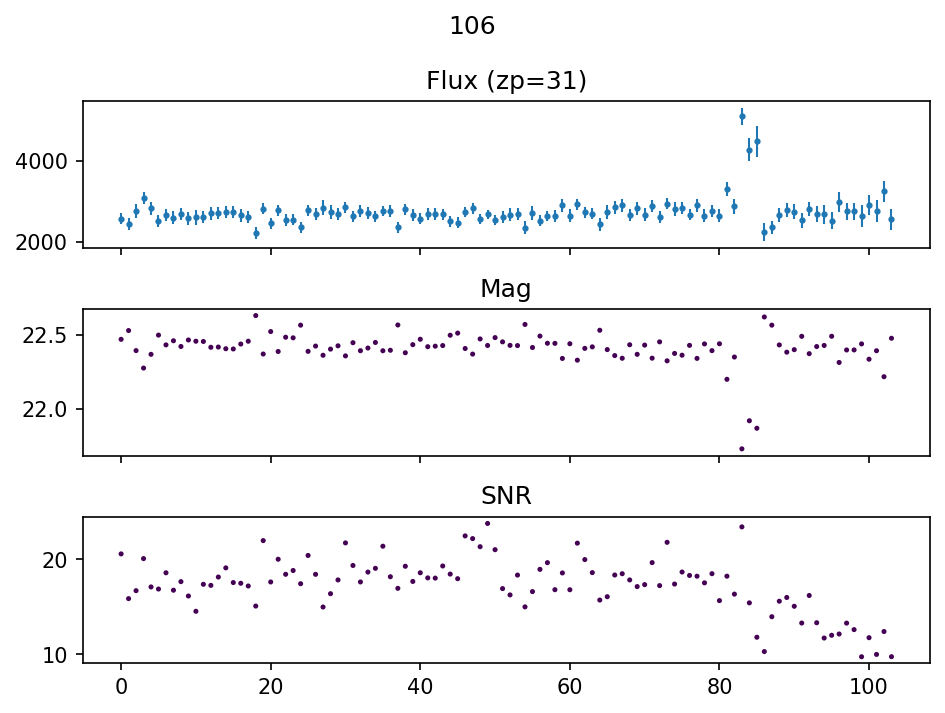

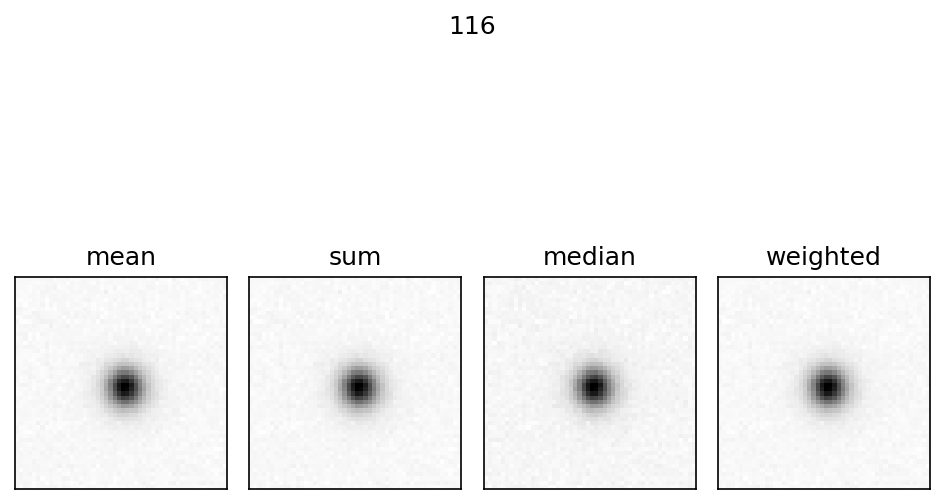

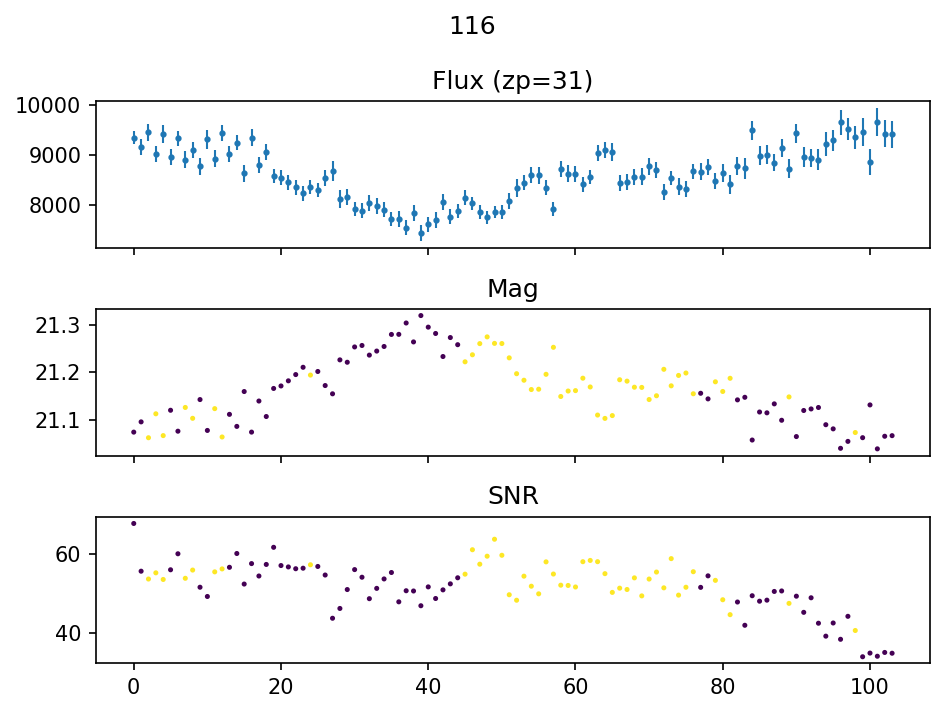

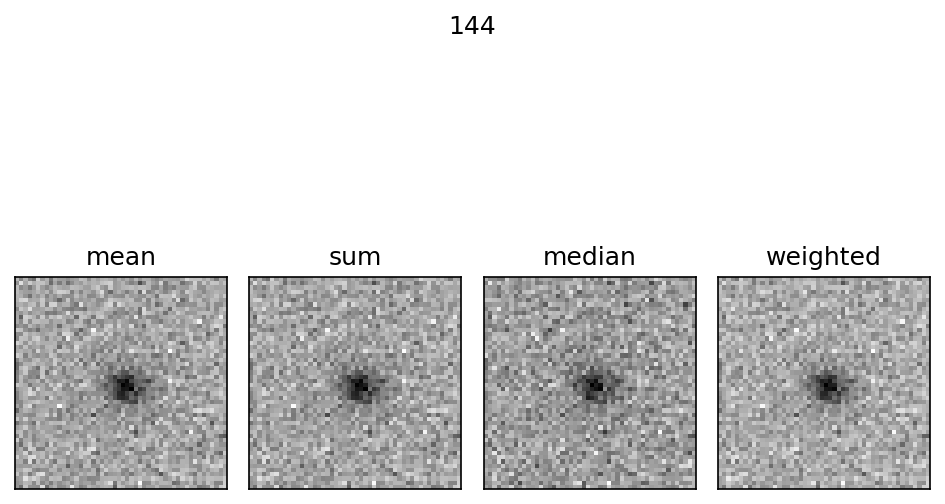

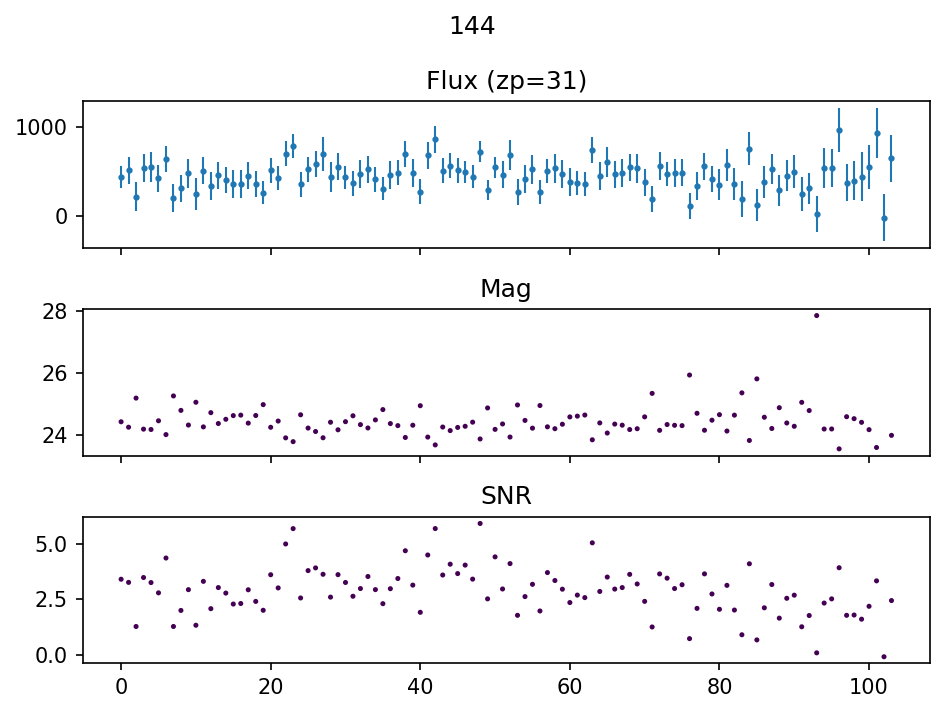

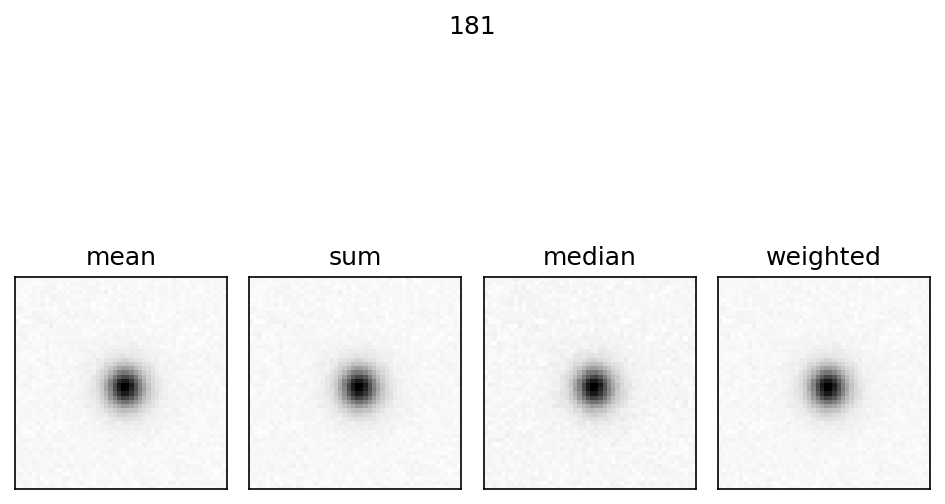

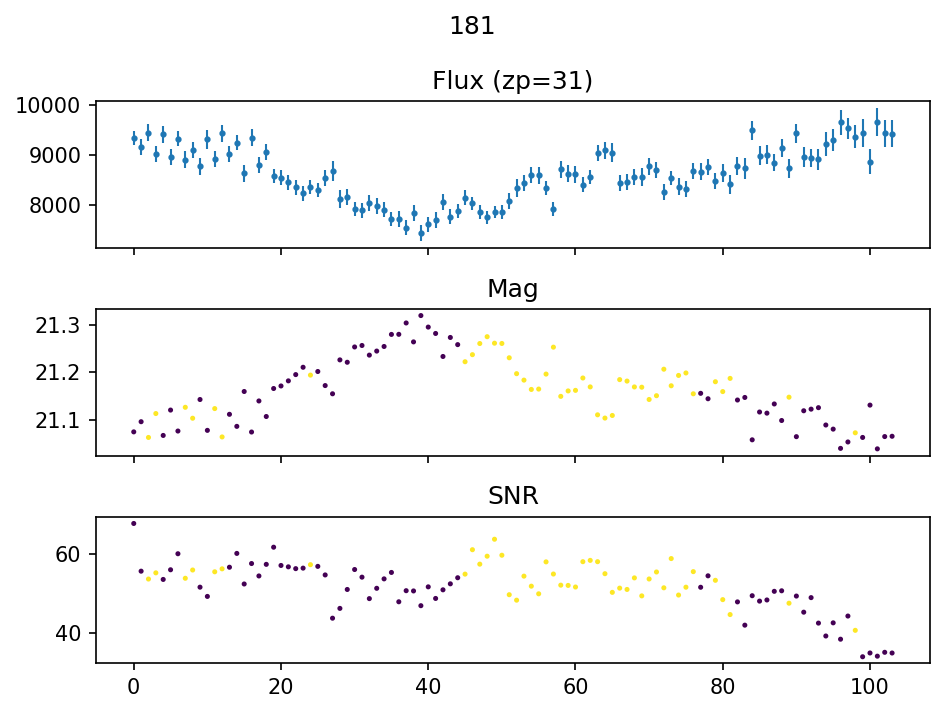

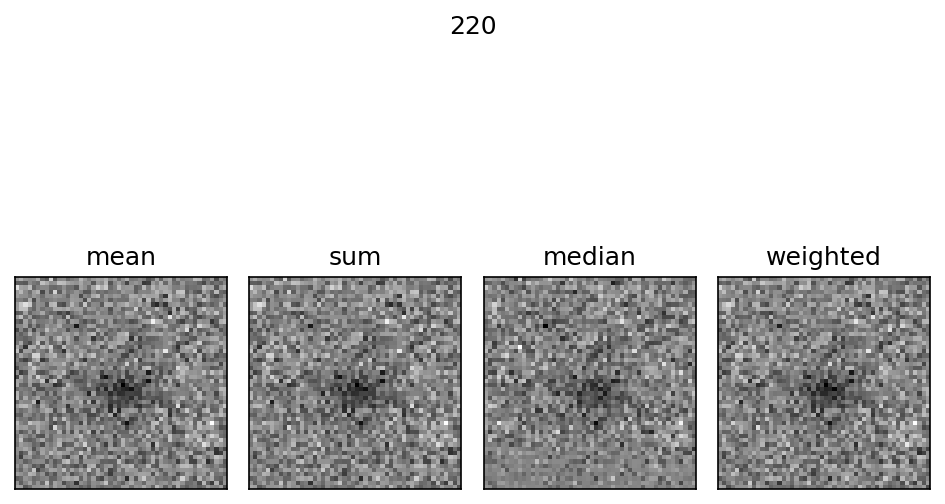

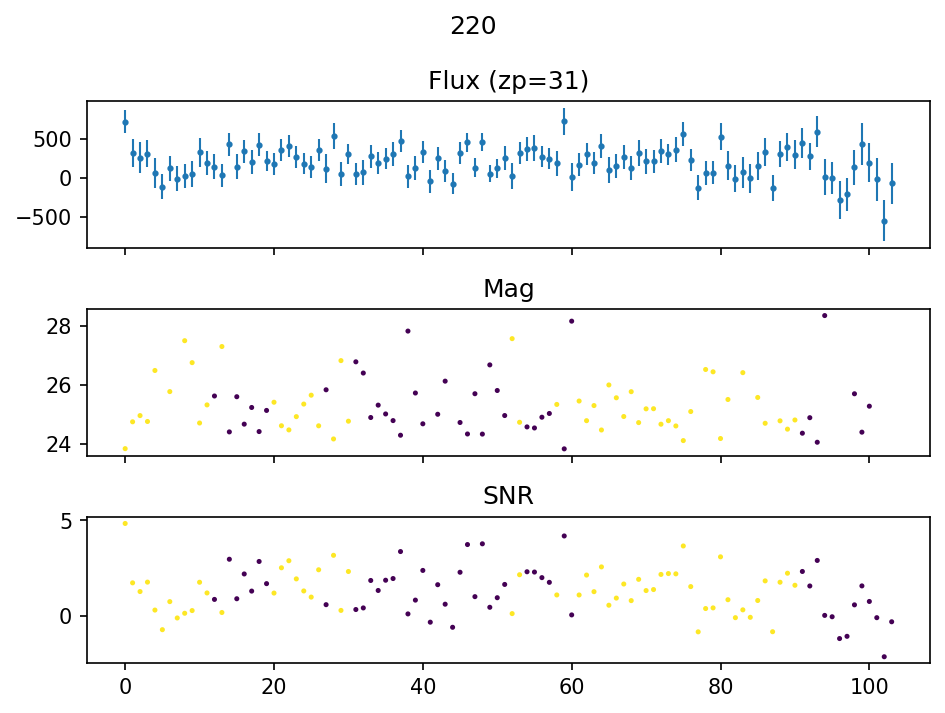

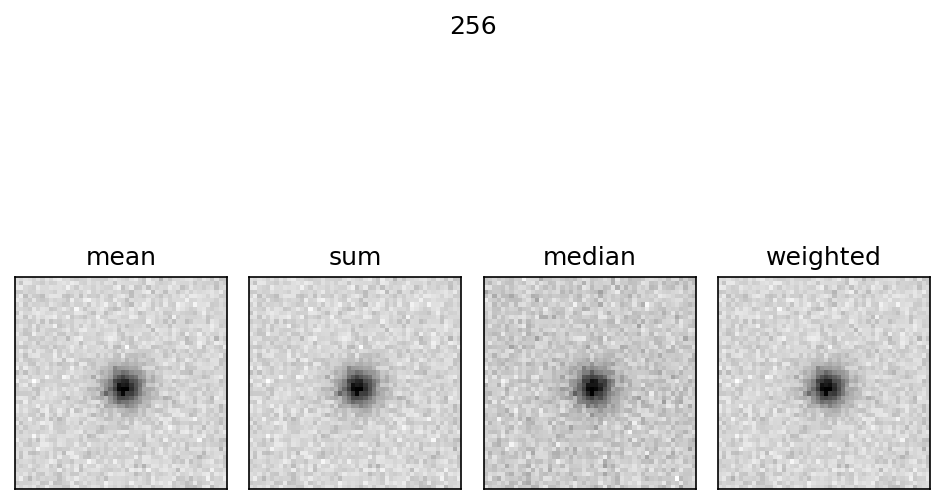

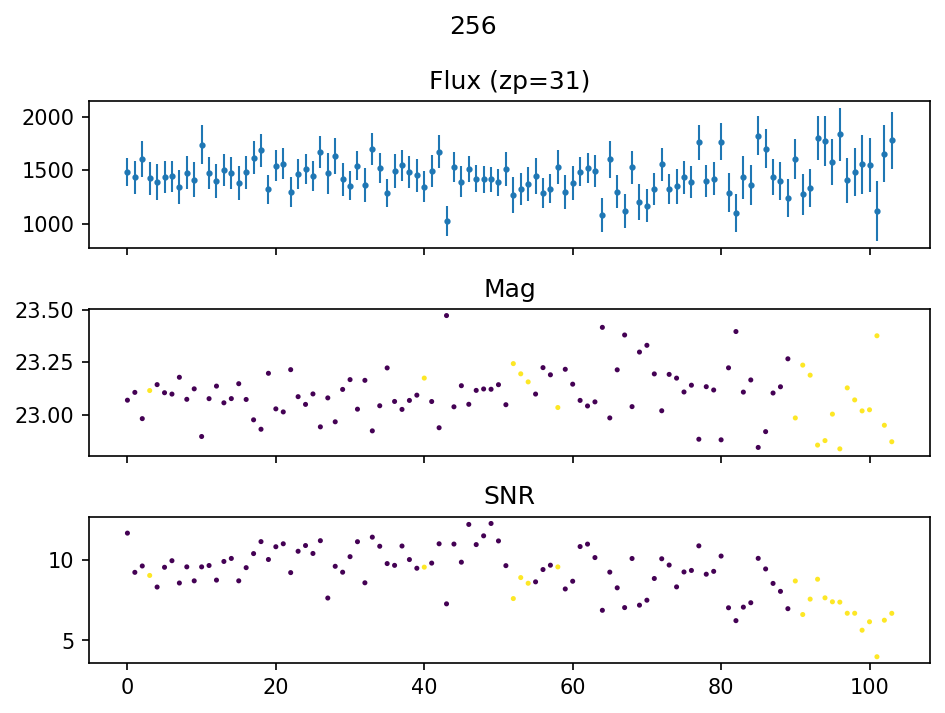

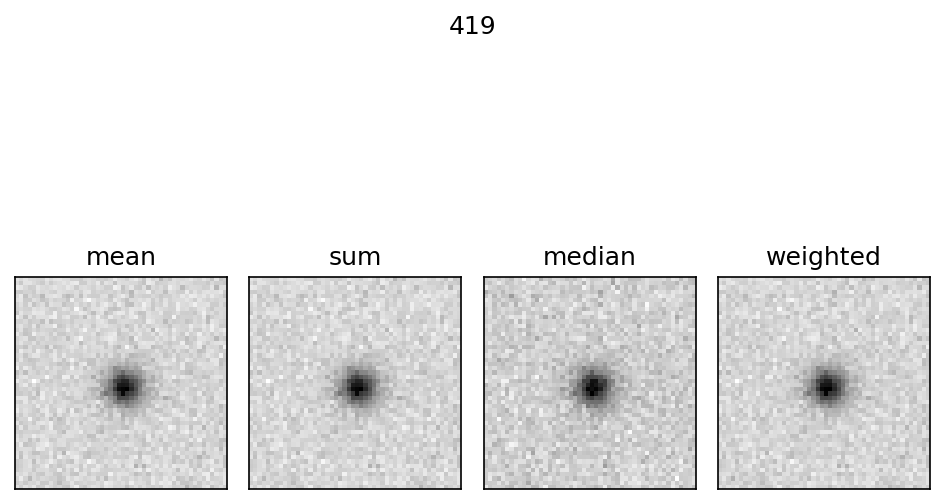

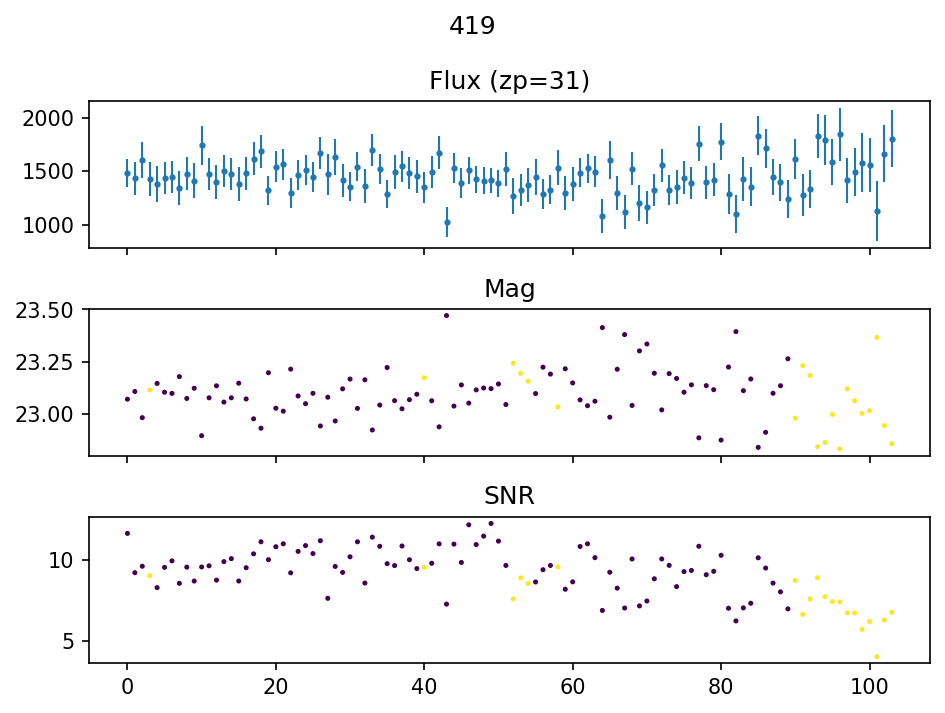

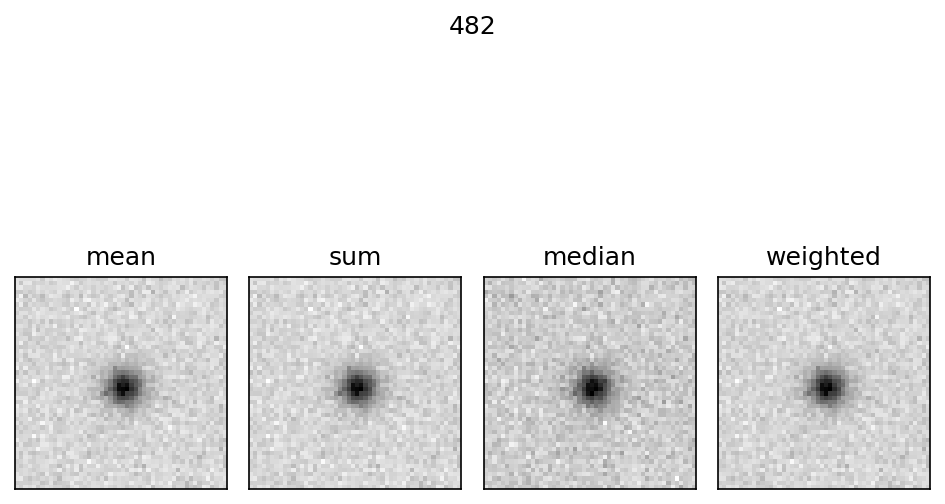

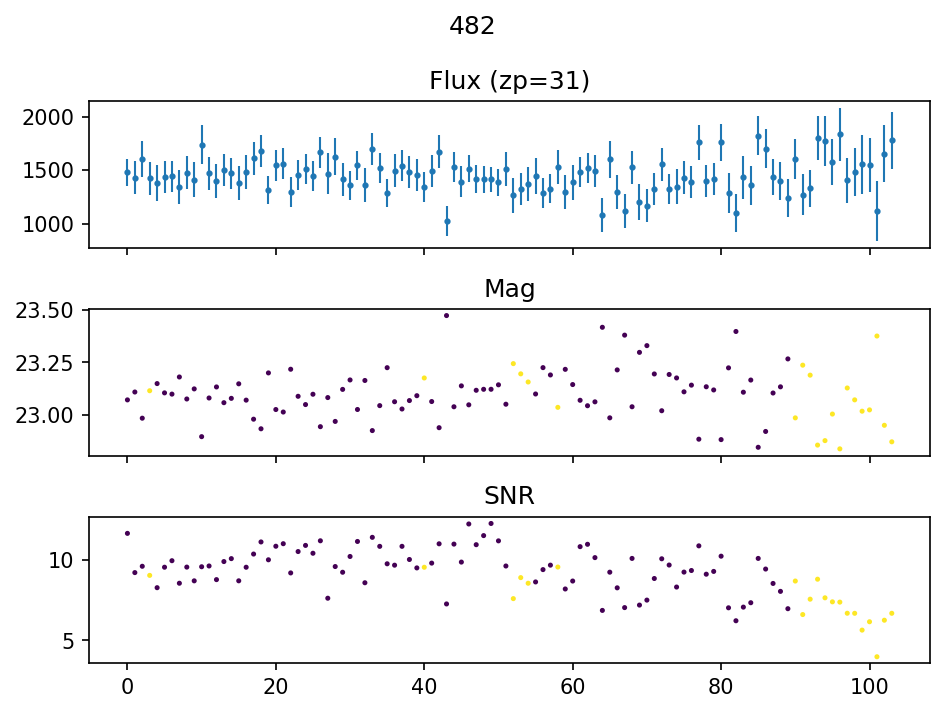

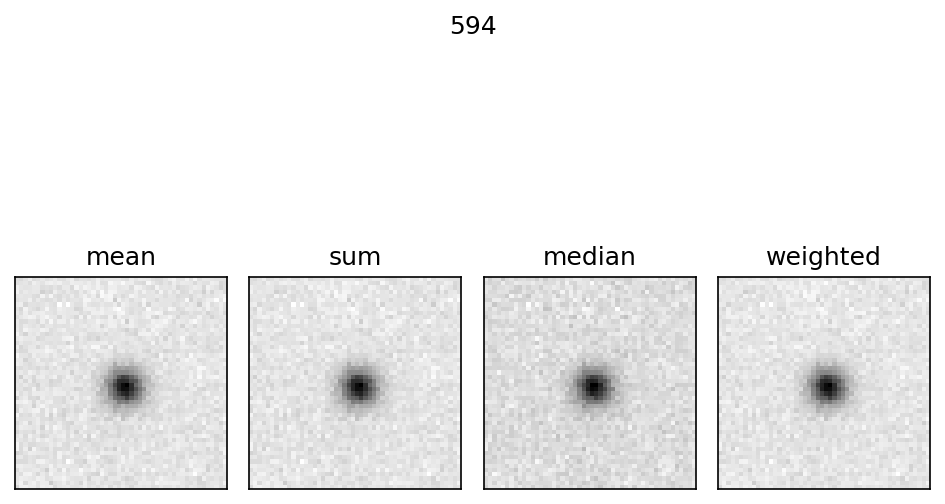

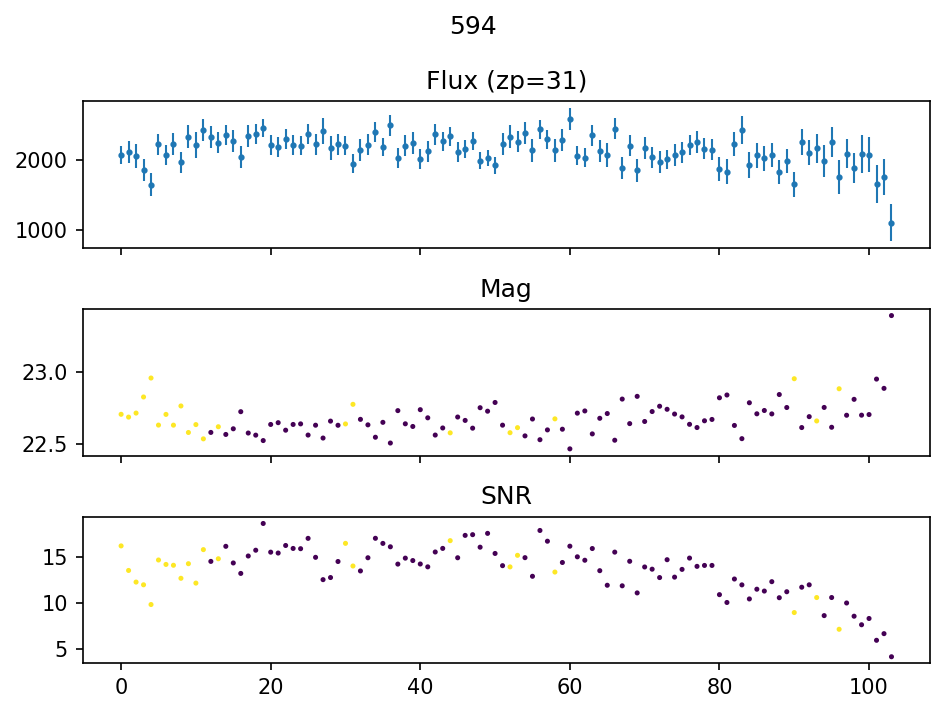

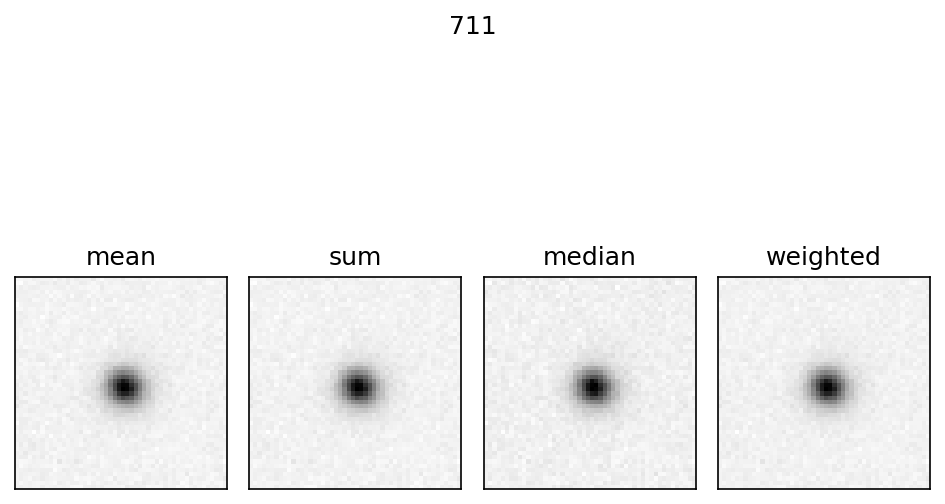

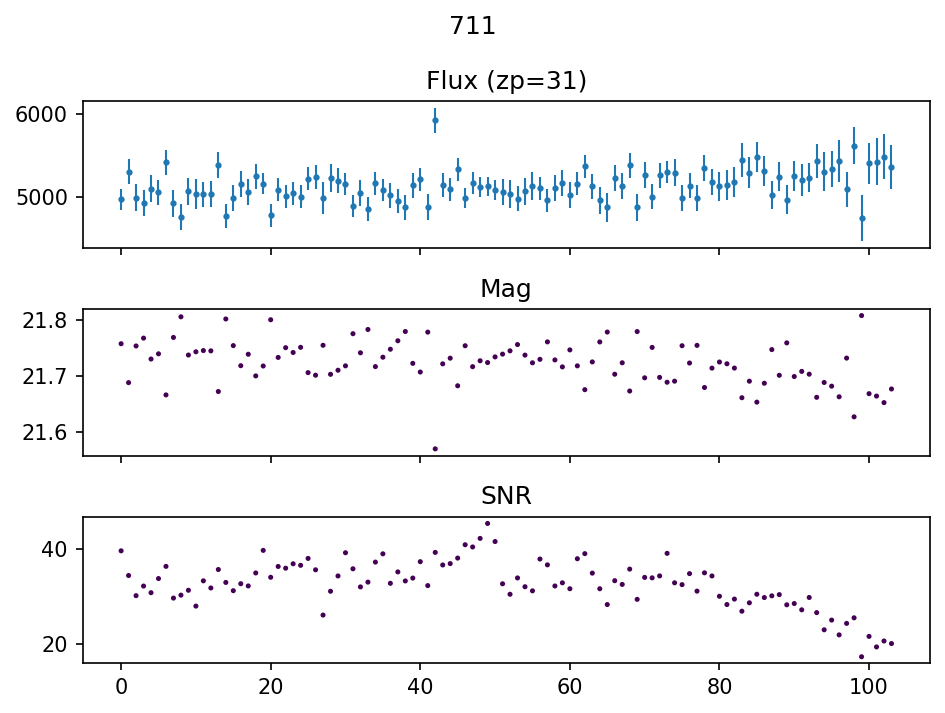

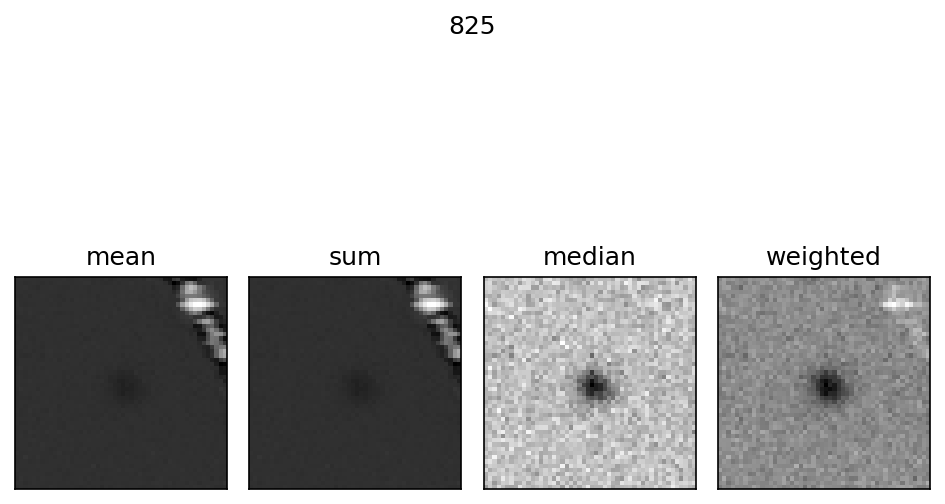

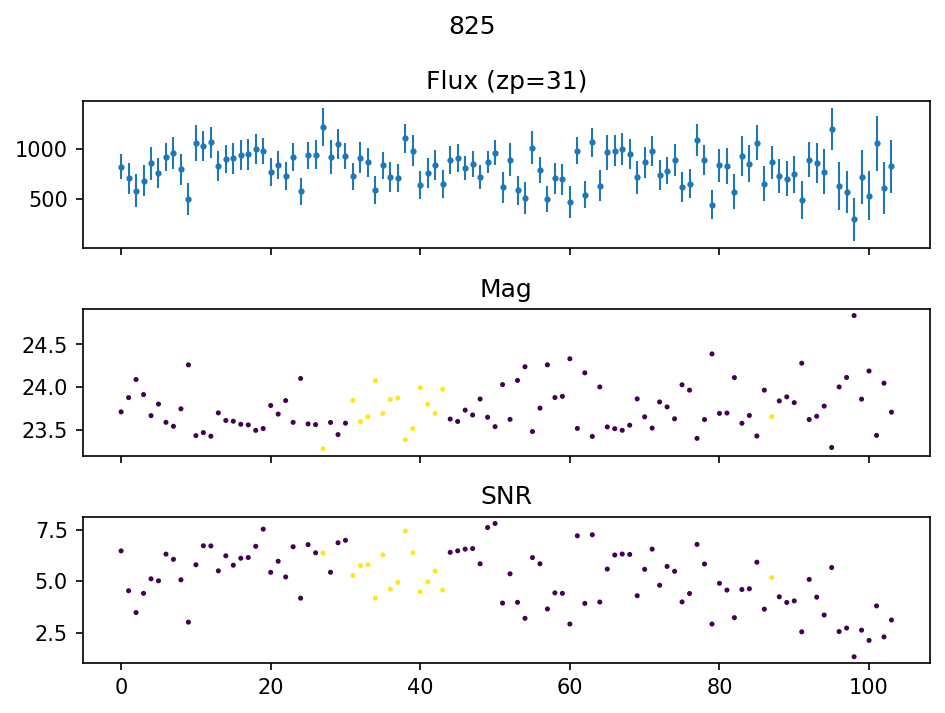

In [245]:
c = filtered[4]
for k in c:
    plot_summary_coadds(c[k].summary)
    fig = plt.gcf()
    fig.suptitle(k)
    fig.tight_layout()
    plt.show()
    plot_summary_light_curve(c[k].summary)
    fig = plt.gcf()
    fig.suptitle(k)
    fig.tight_layout()    
    plt.show()

In [ ]:
find_matches()

In [229]:
dedup = deduplicate(filtered[4])
len(dedup)

25

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 15, 14: 19, 15: 25, 16: 27, 17: 31, 18: 45, 19: 103, 20: 106, 21: 116, 22: 144, 23: 181, 24: 220, 25: 256, 26: 419, 27: 482, 28: 594, 29: 711, 30: 825}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 15: 13, 19: 14, 25: 15, 27: 16, 31: 17, 45: 18, 103: 19, 106: 20, 116: 21, 144: 22, 181: 23, 220: 24, 256: 25, 419: 26, 482: 27, 594: 28, 711: 29, 825: 30}


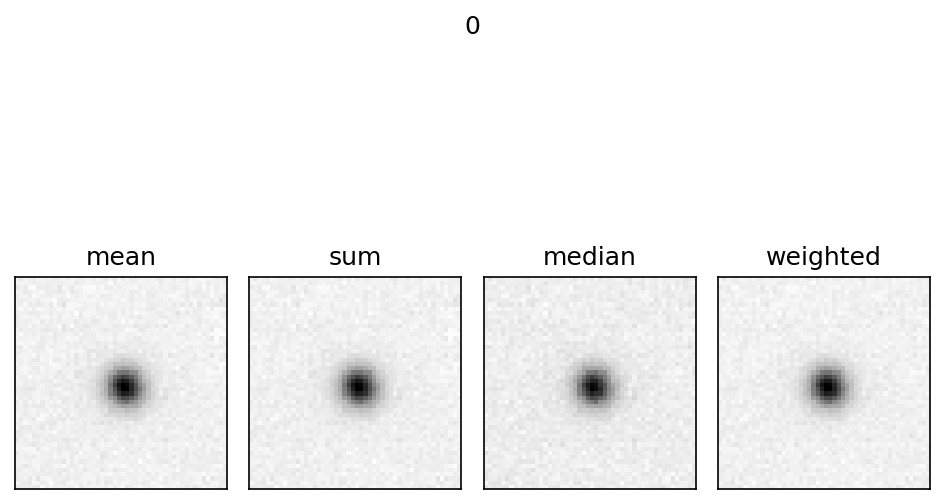

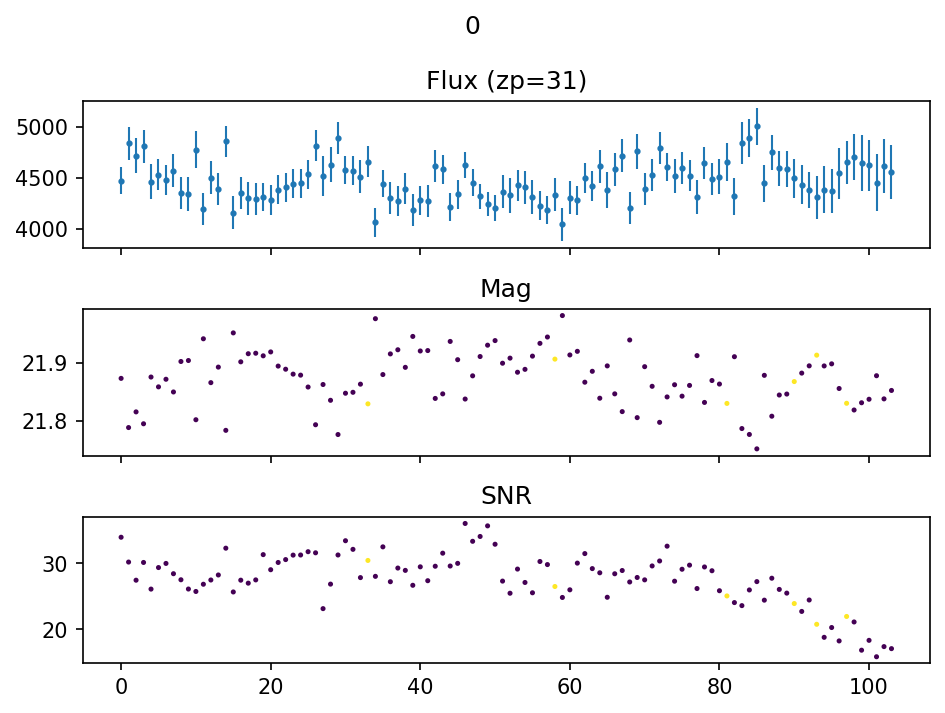

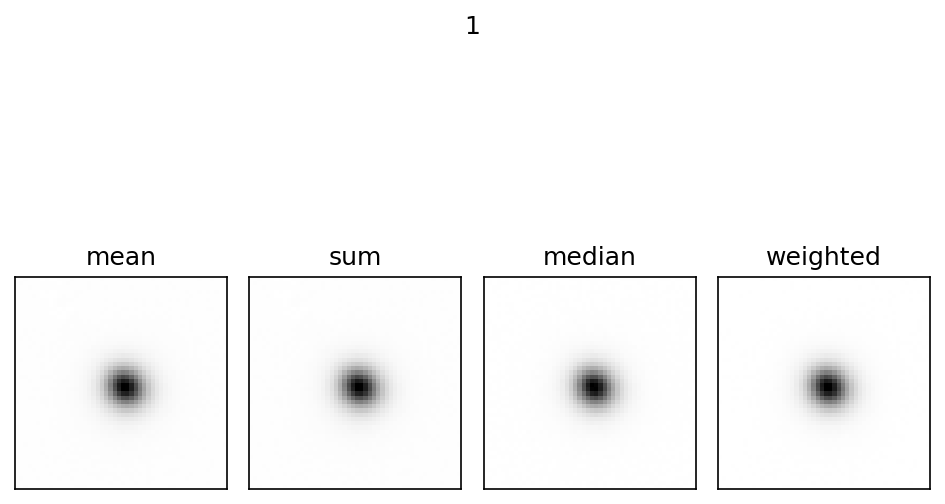

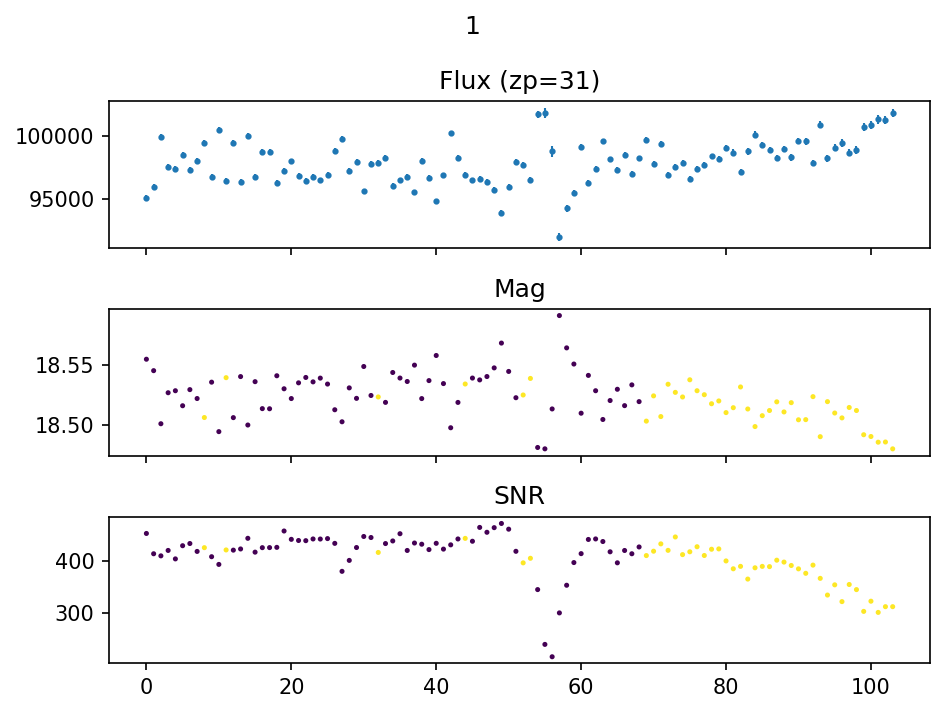

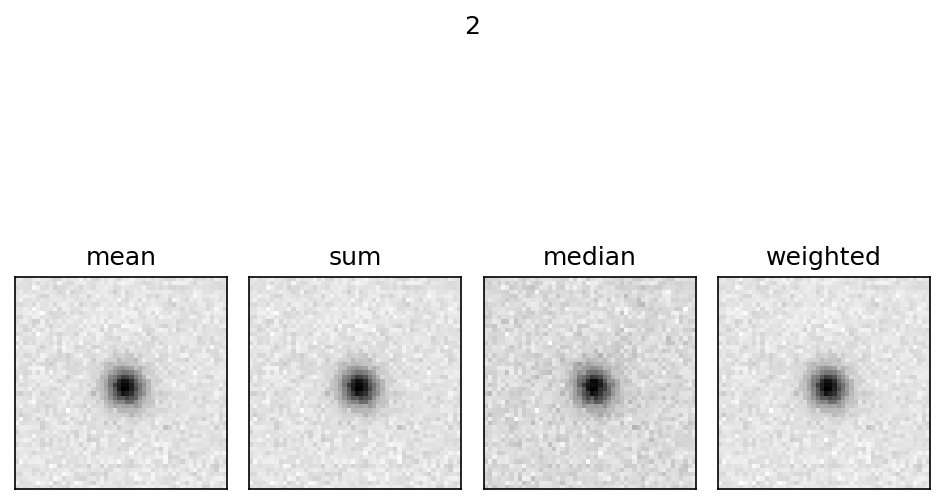

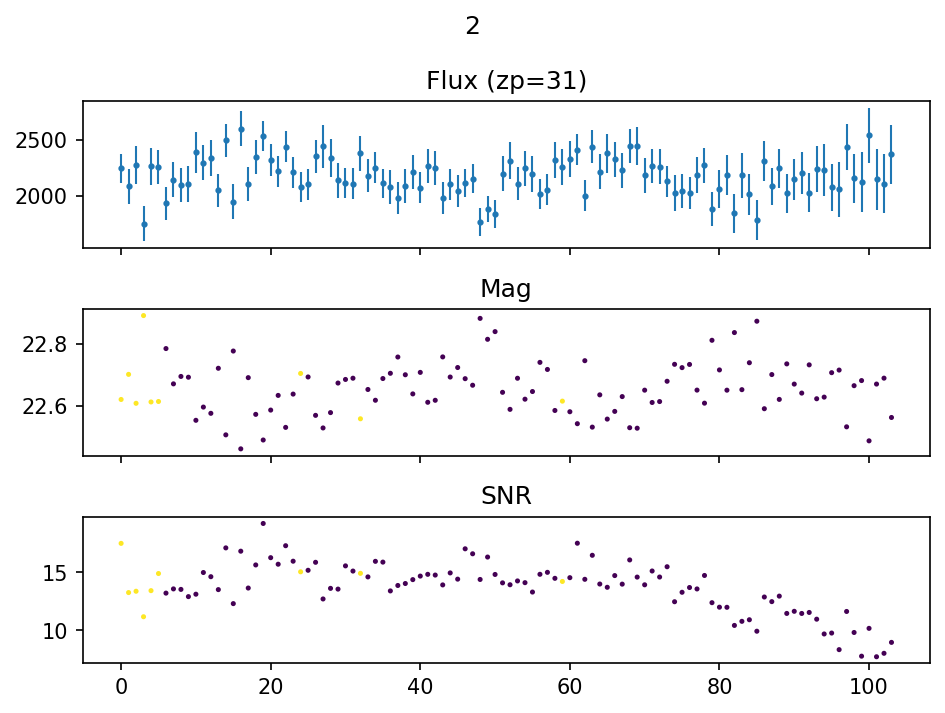

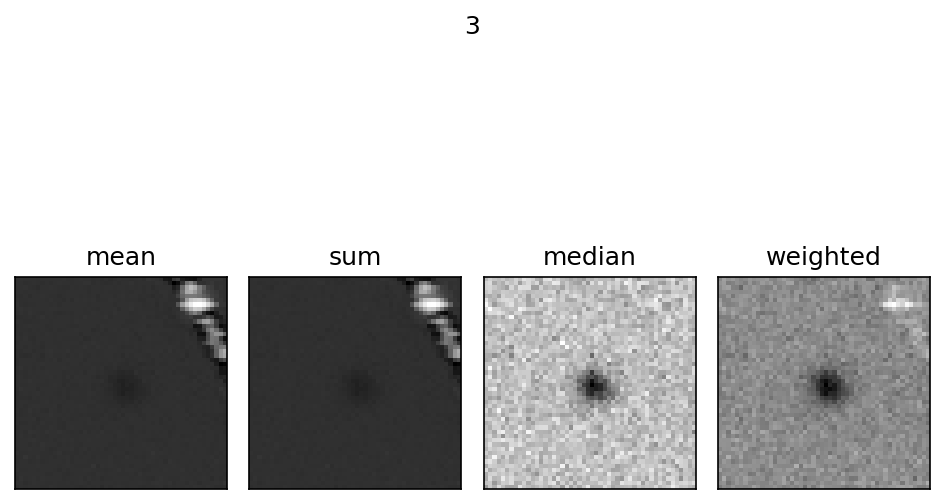

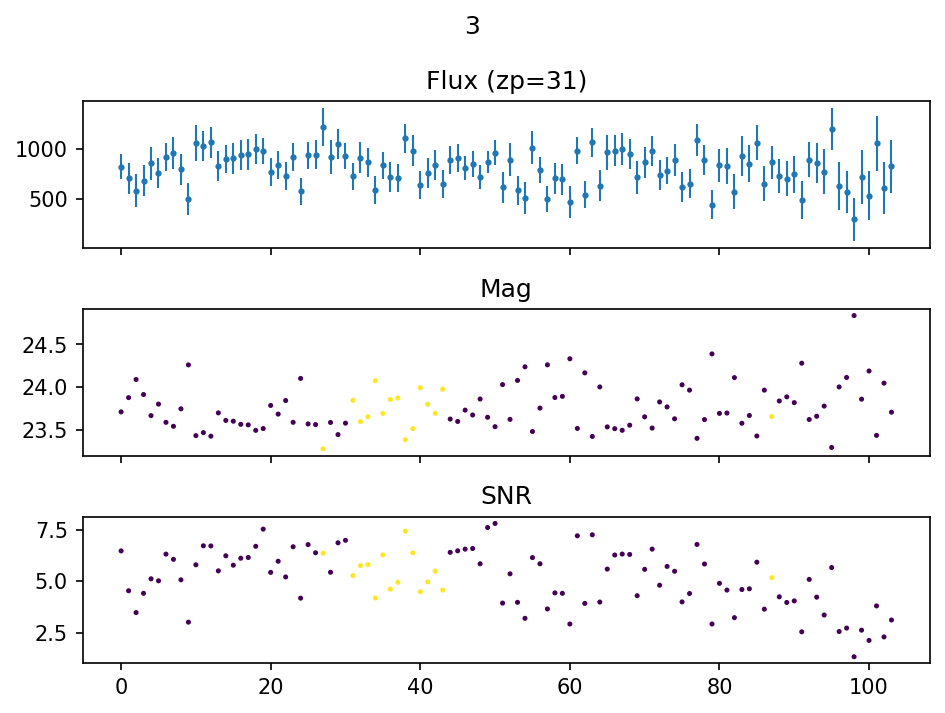

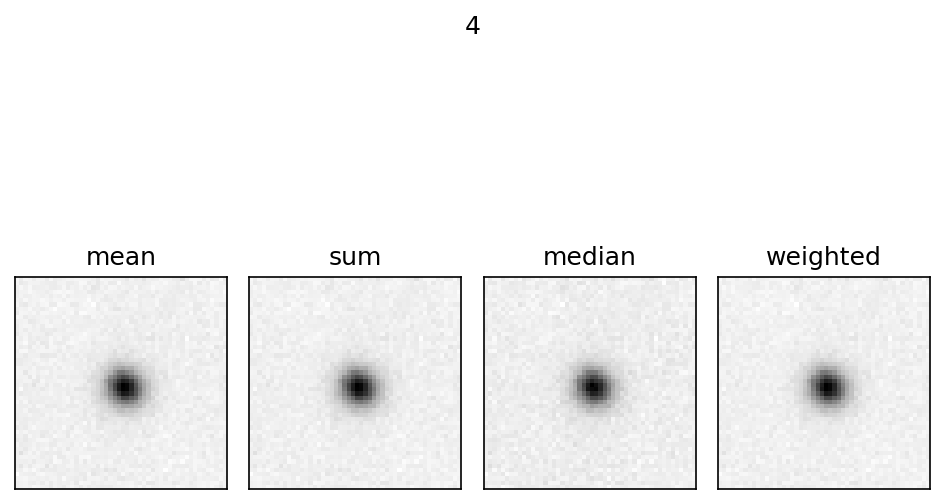

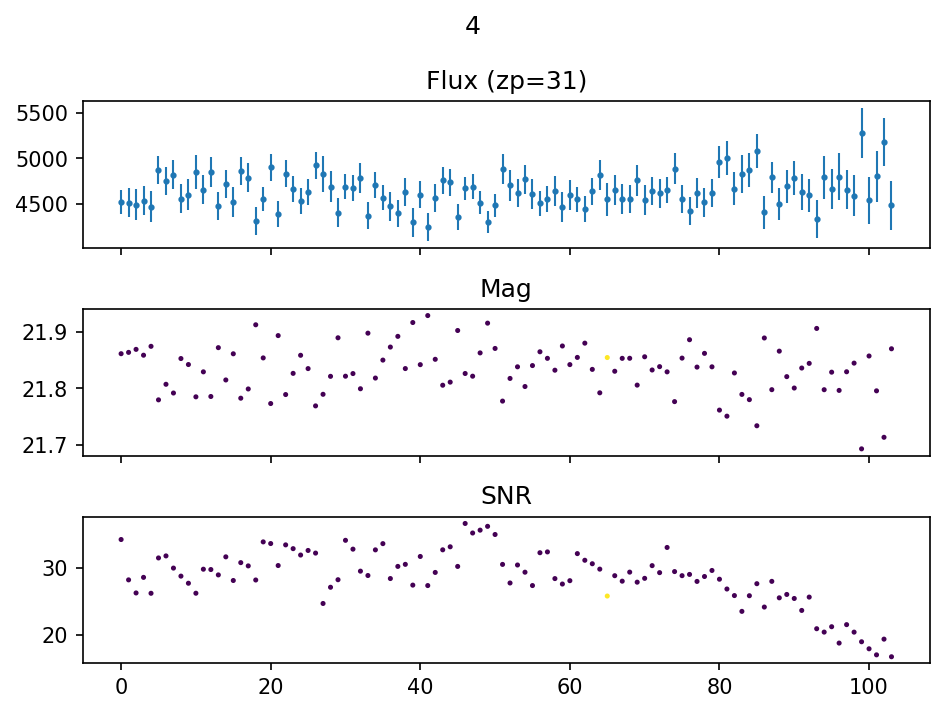

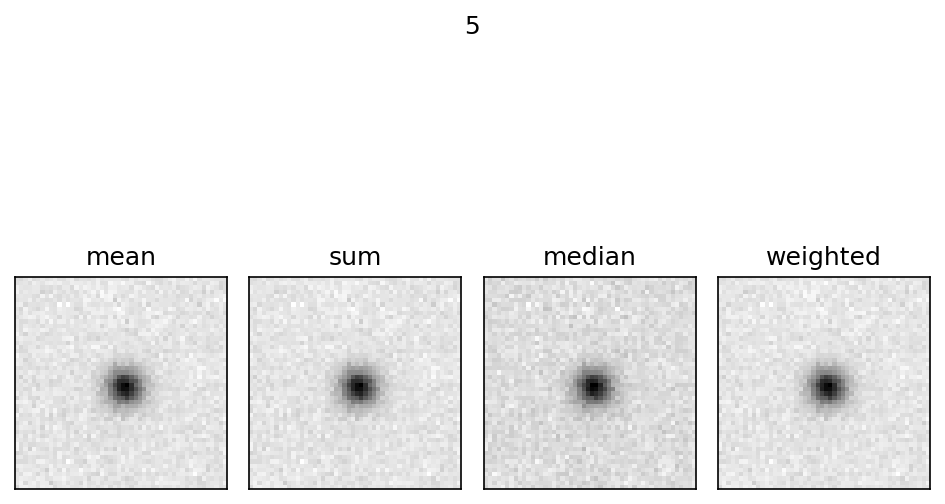

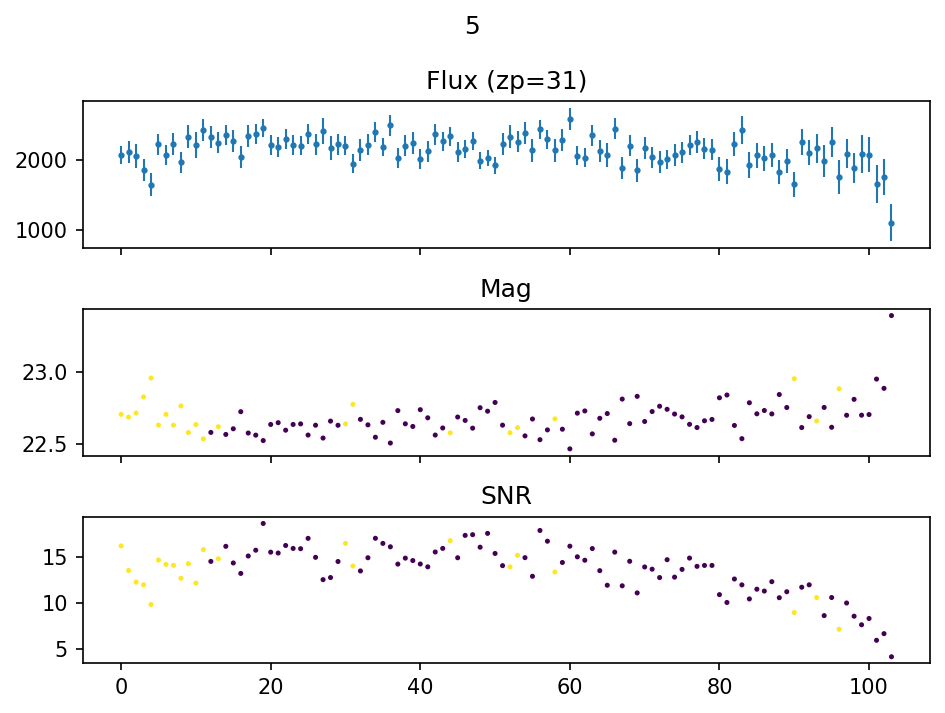

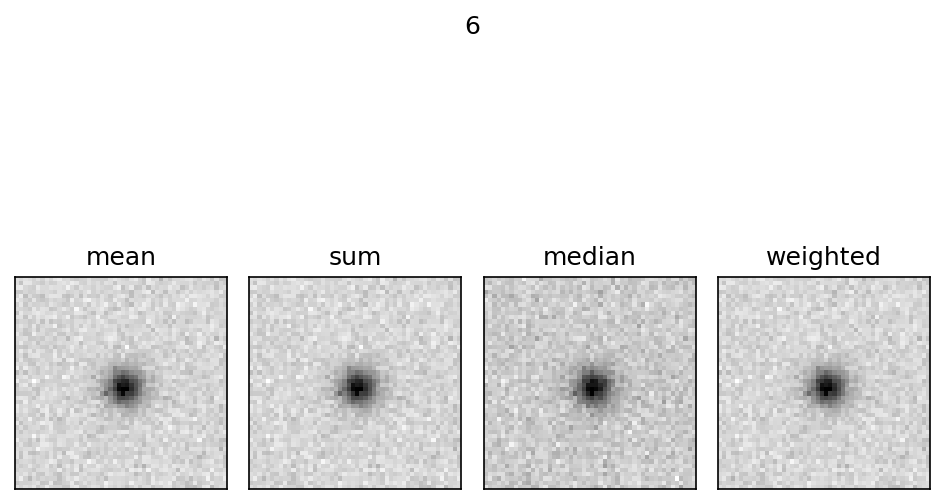

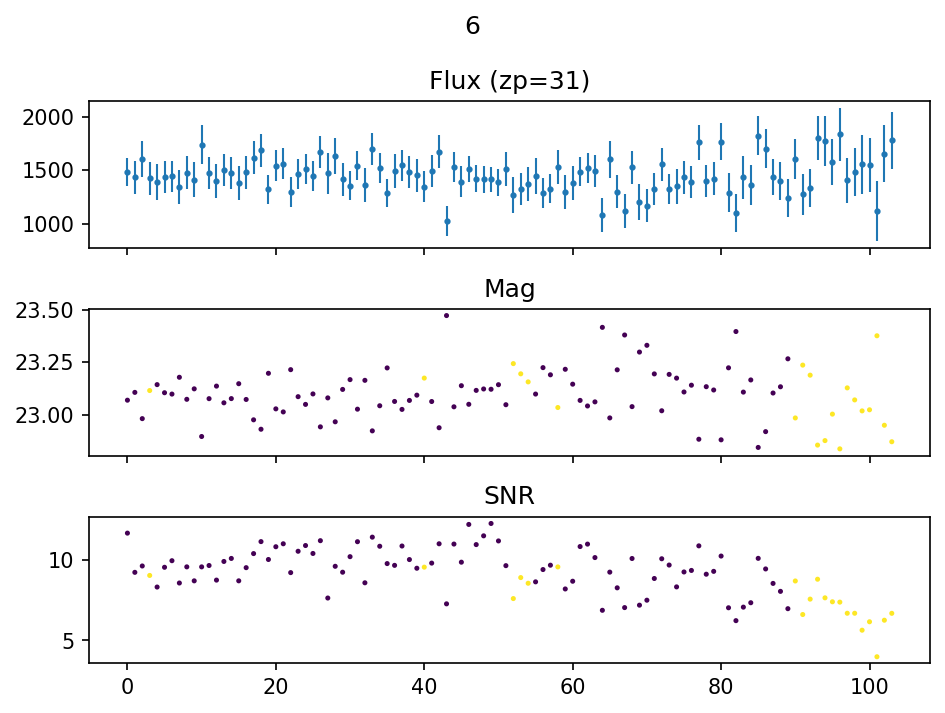

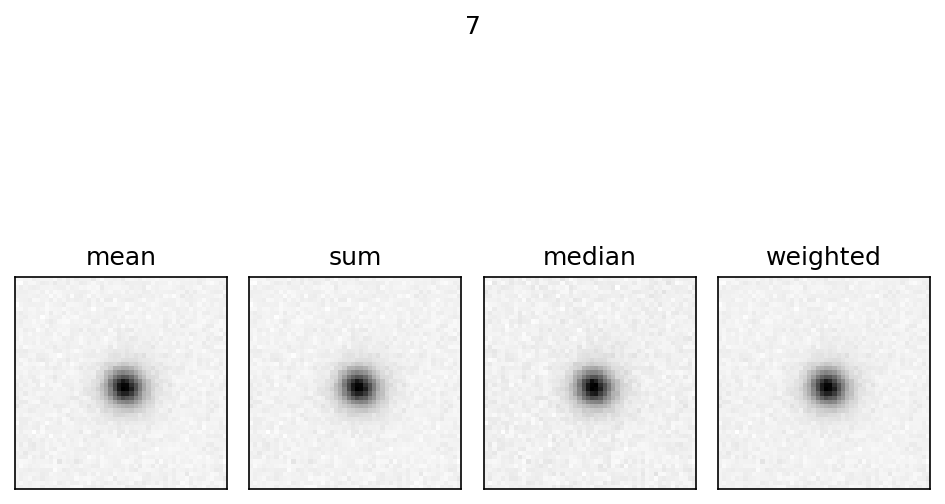

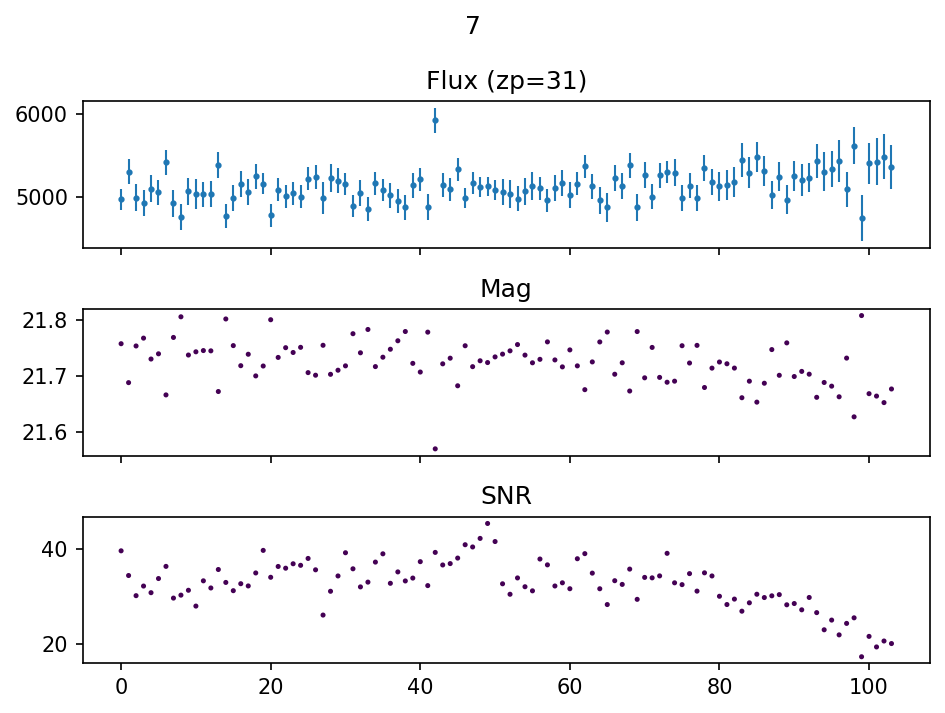

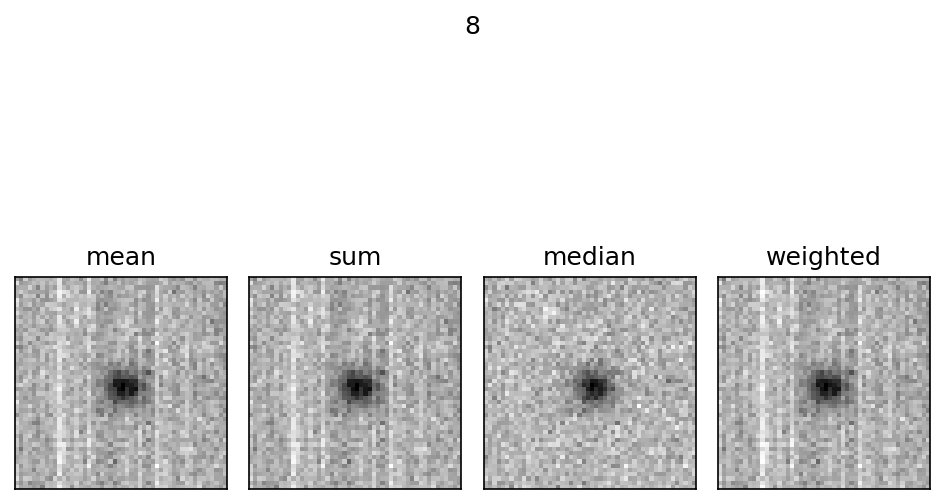

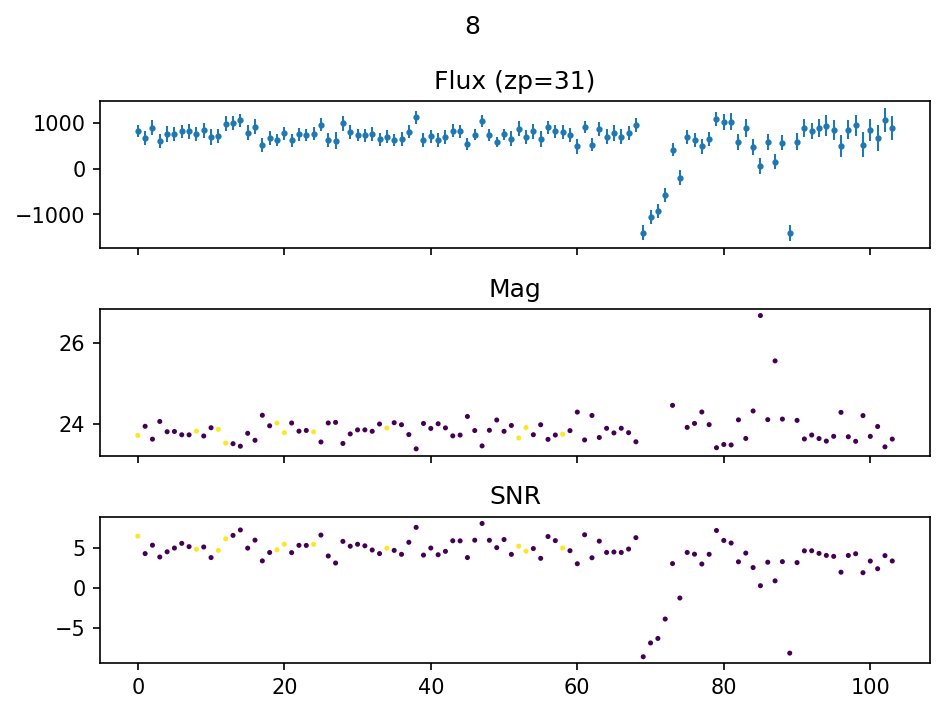

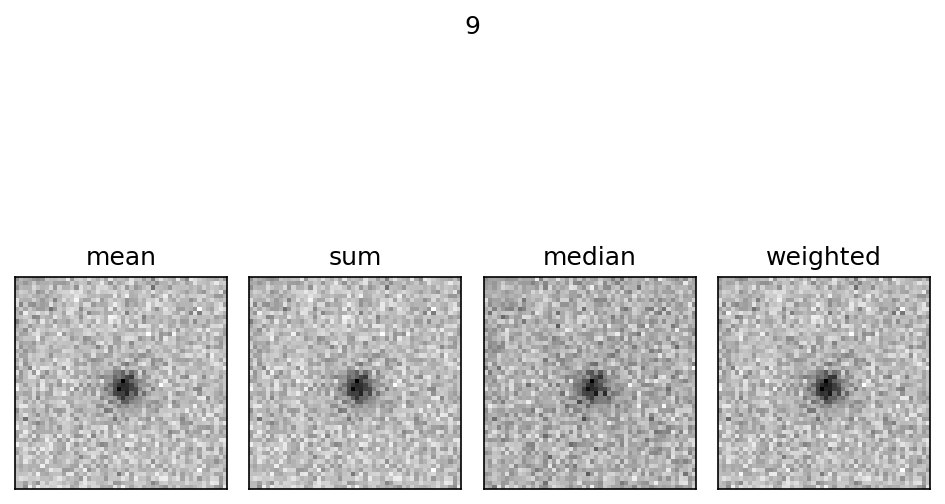

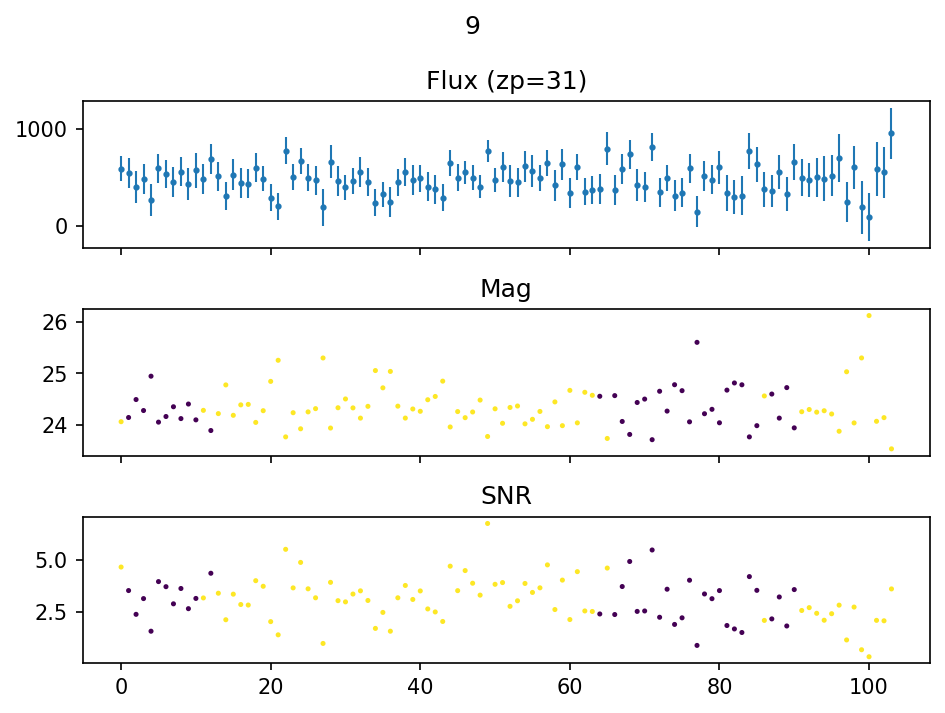

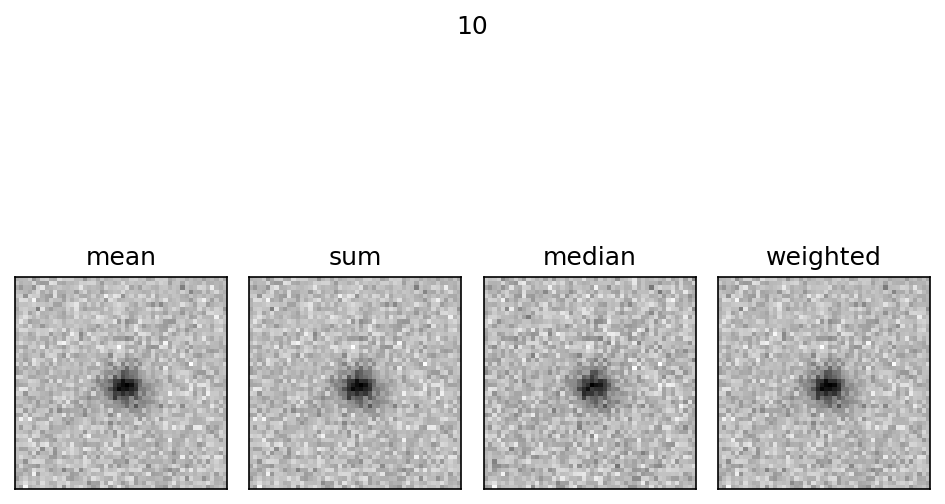

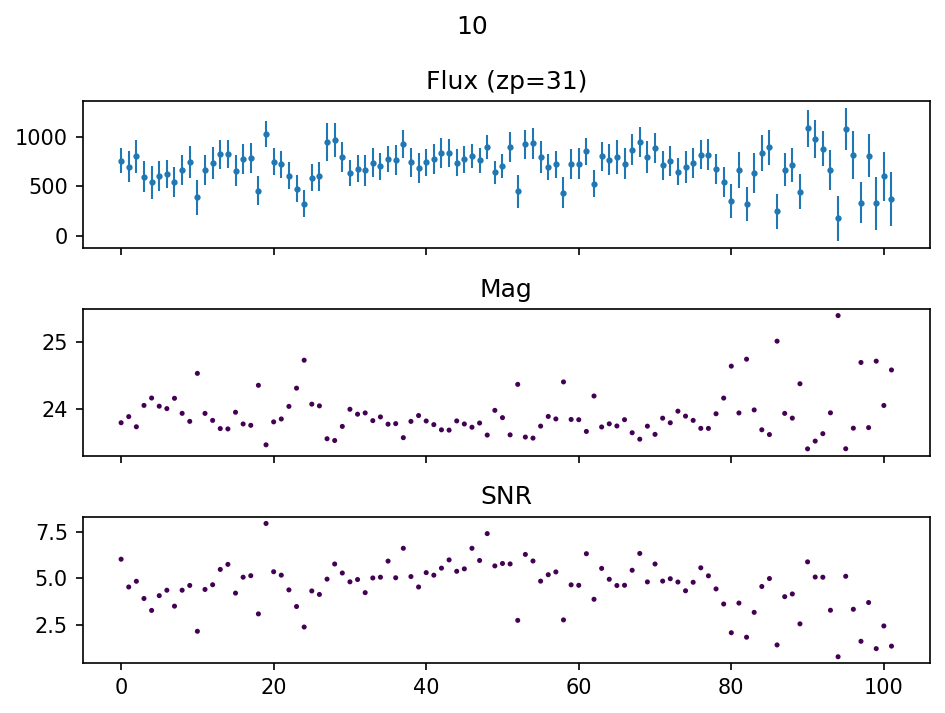

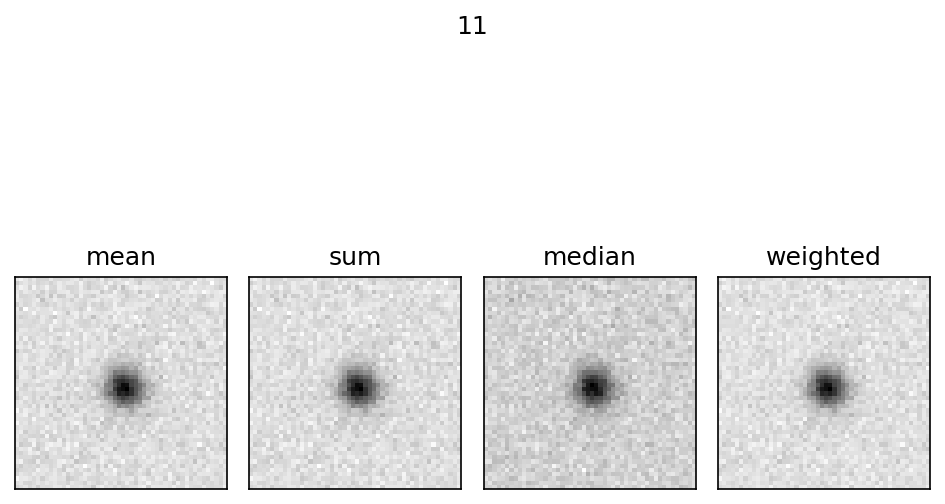

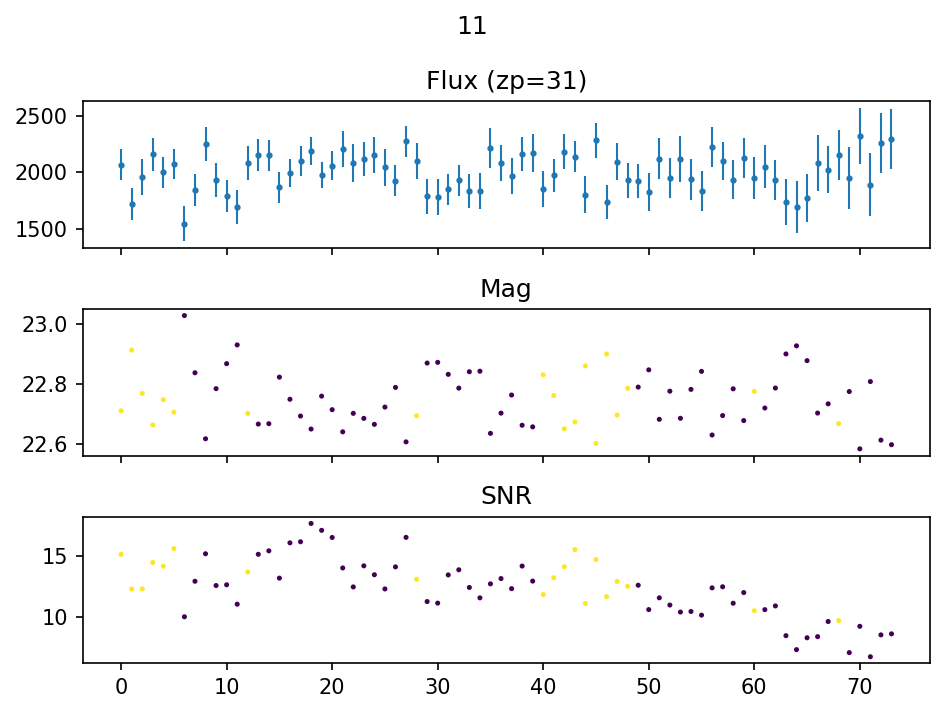

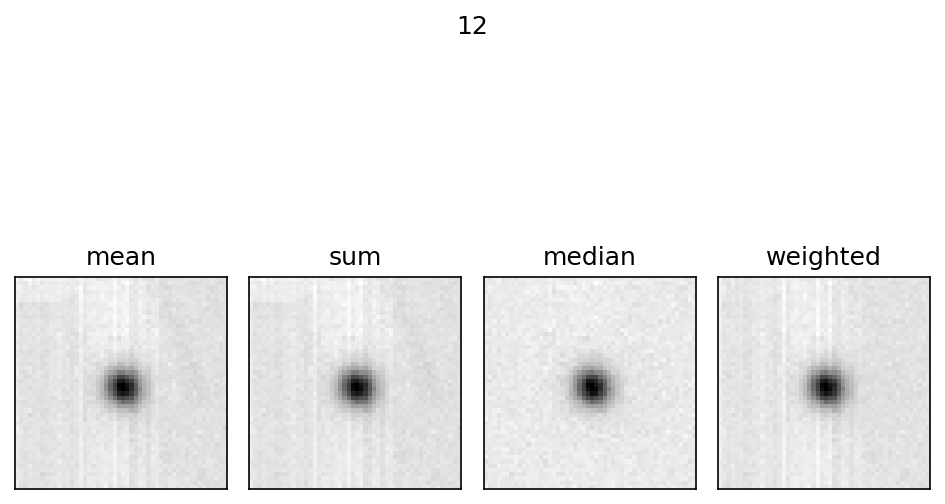

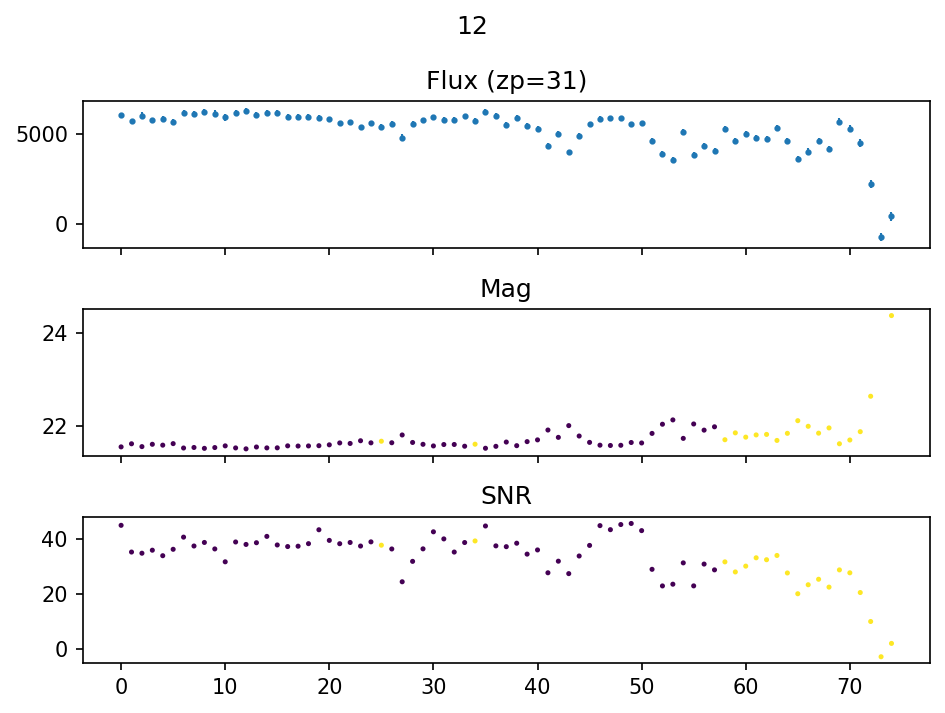

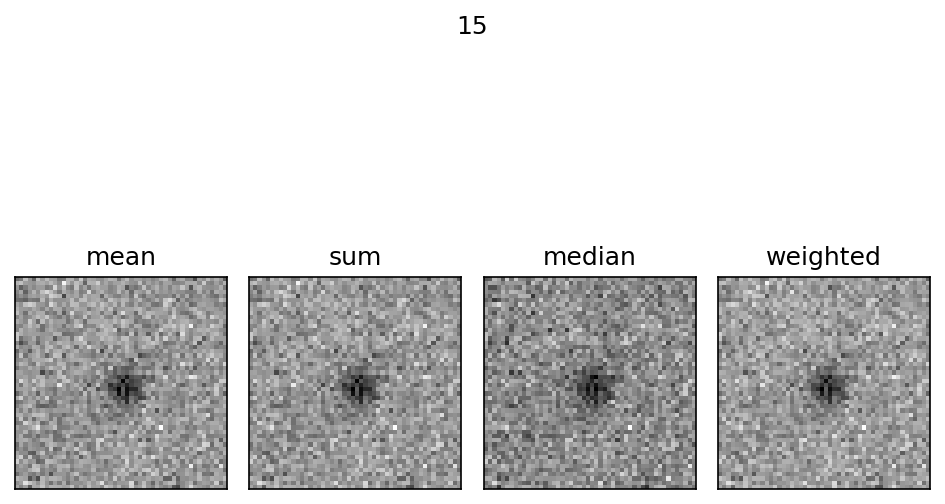

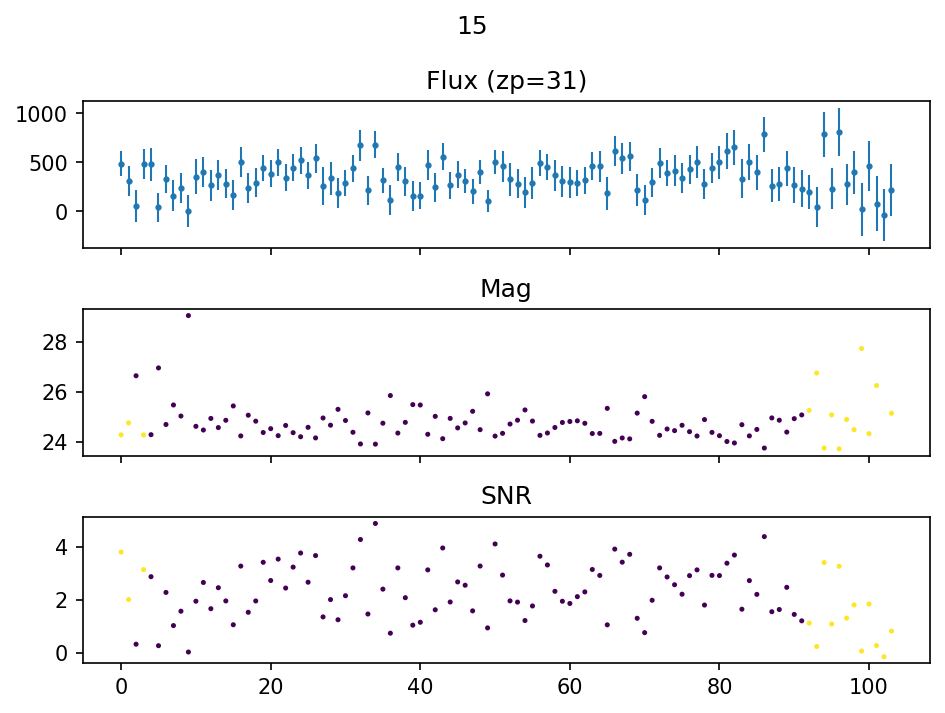

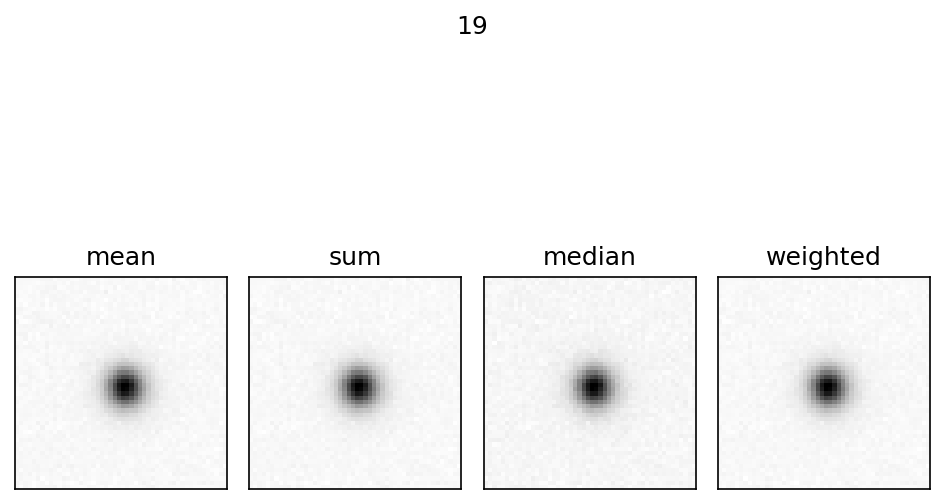

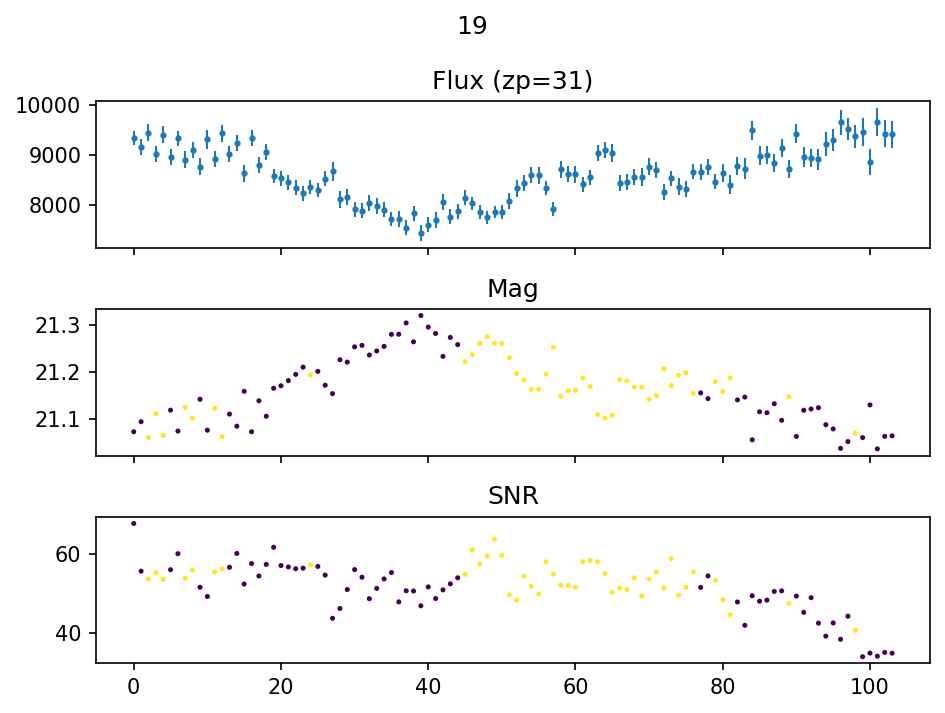

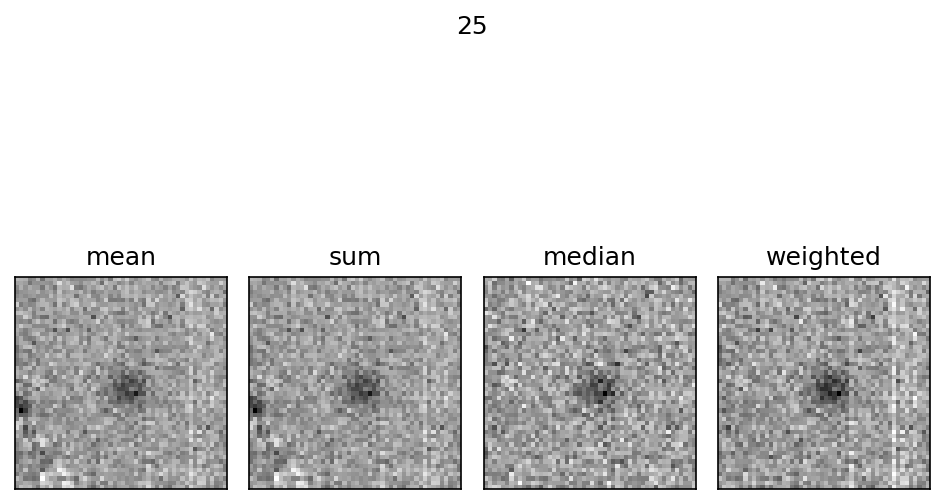

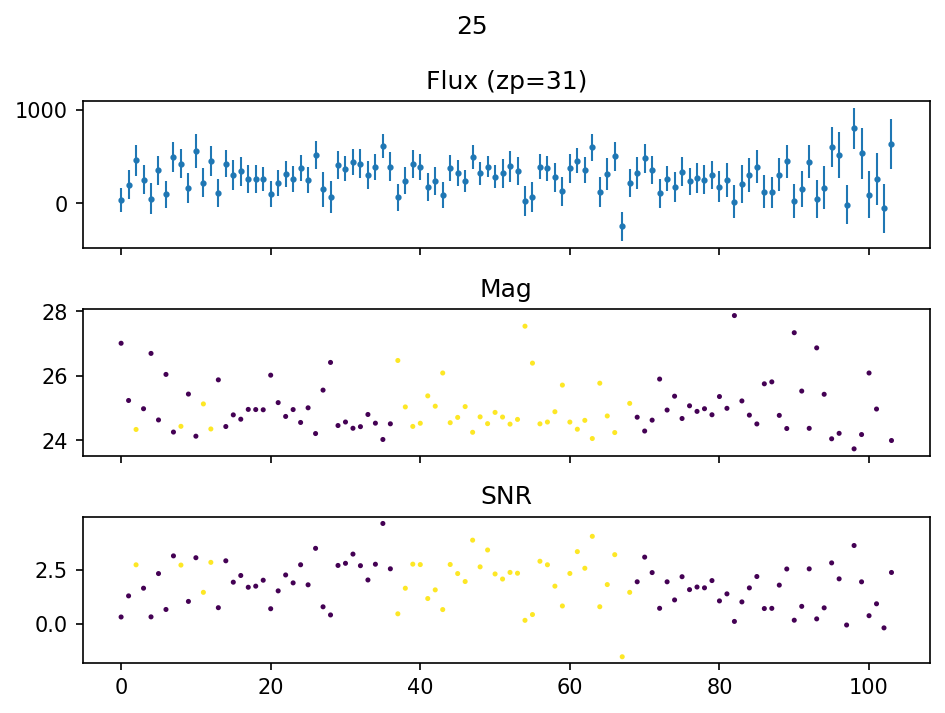

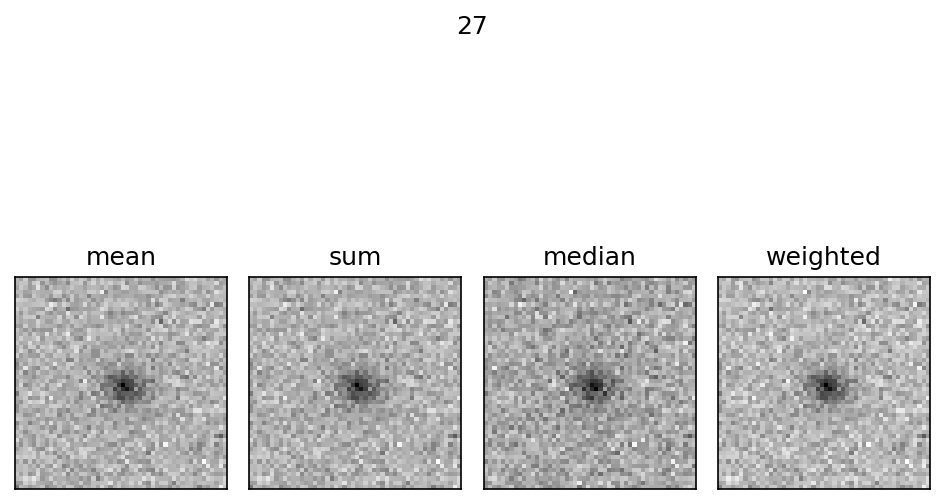

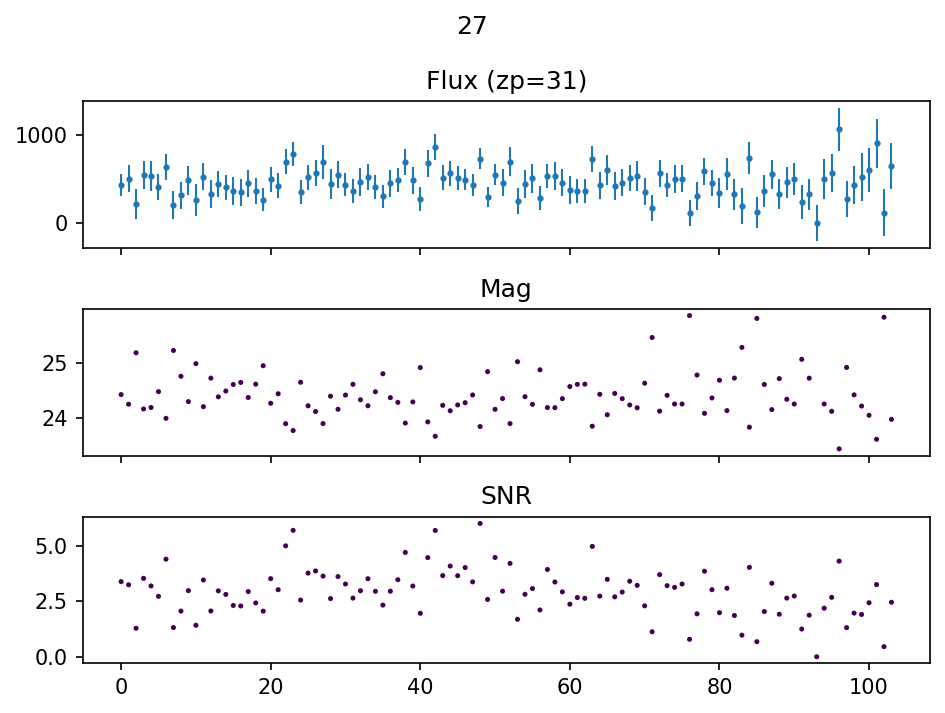

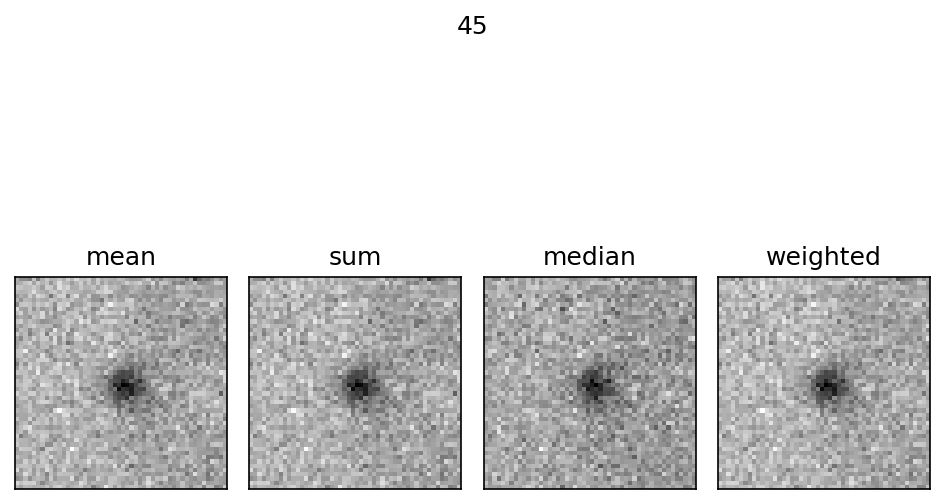

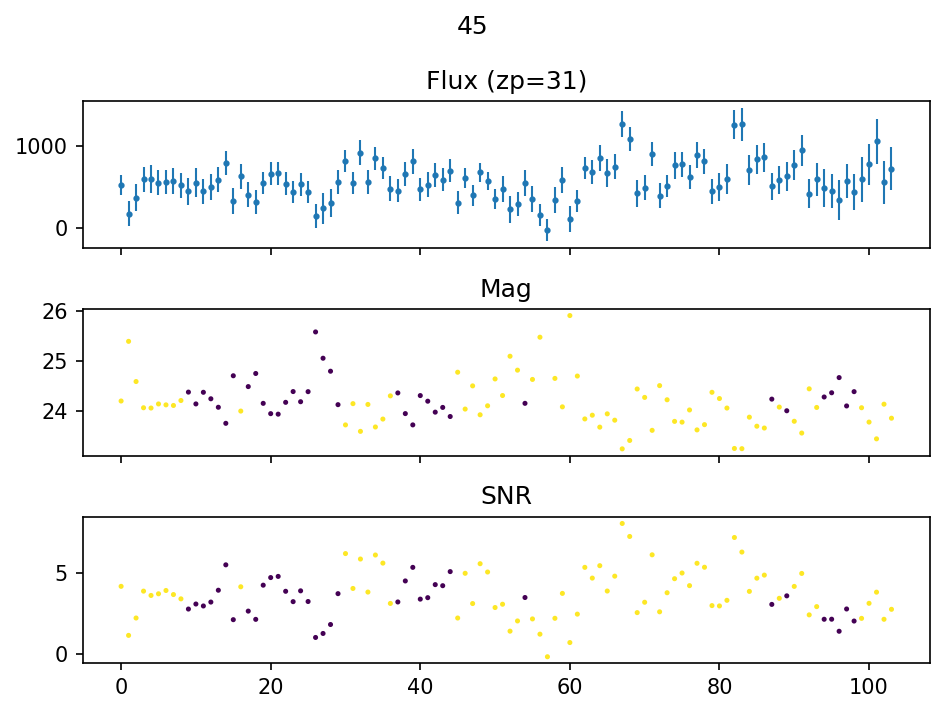

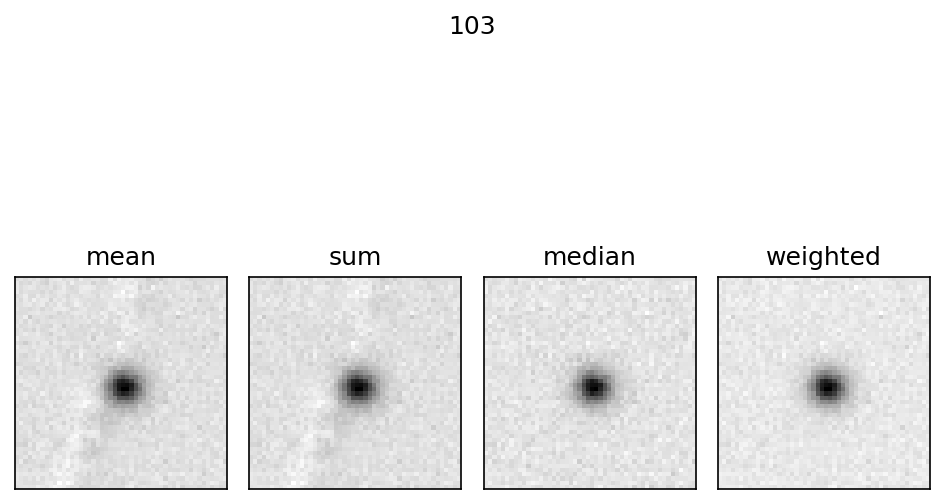

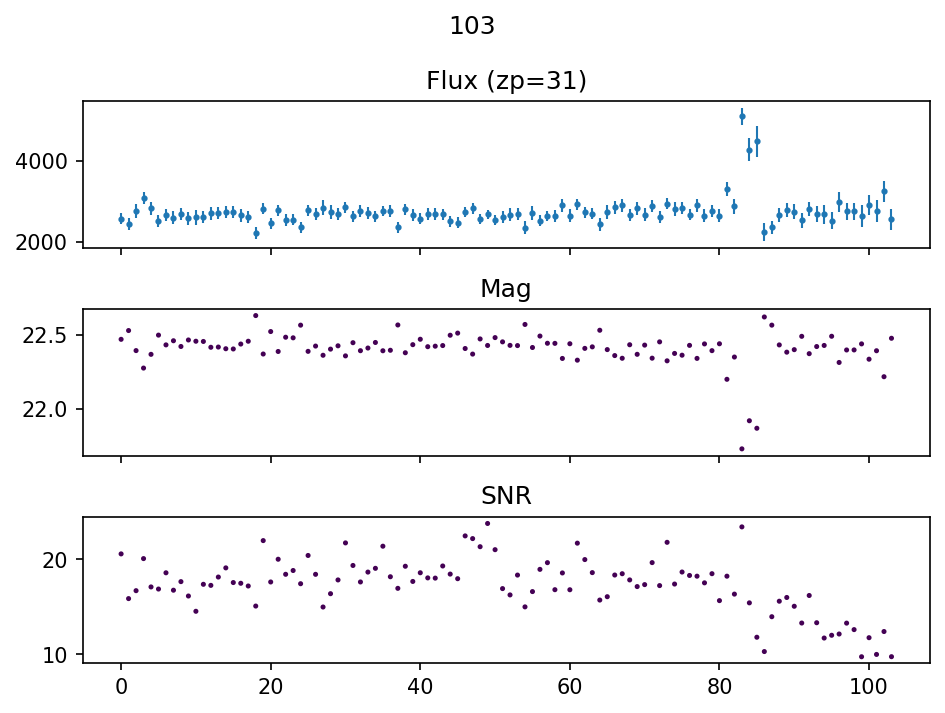

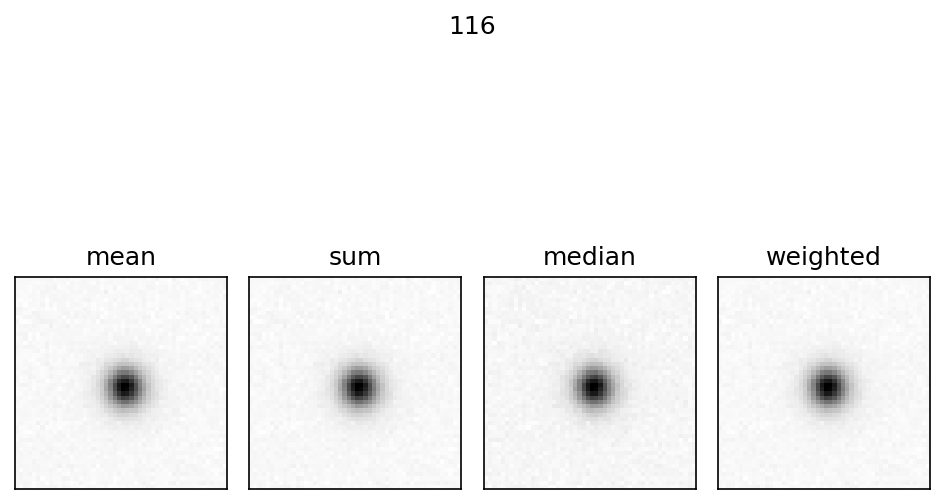

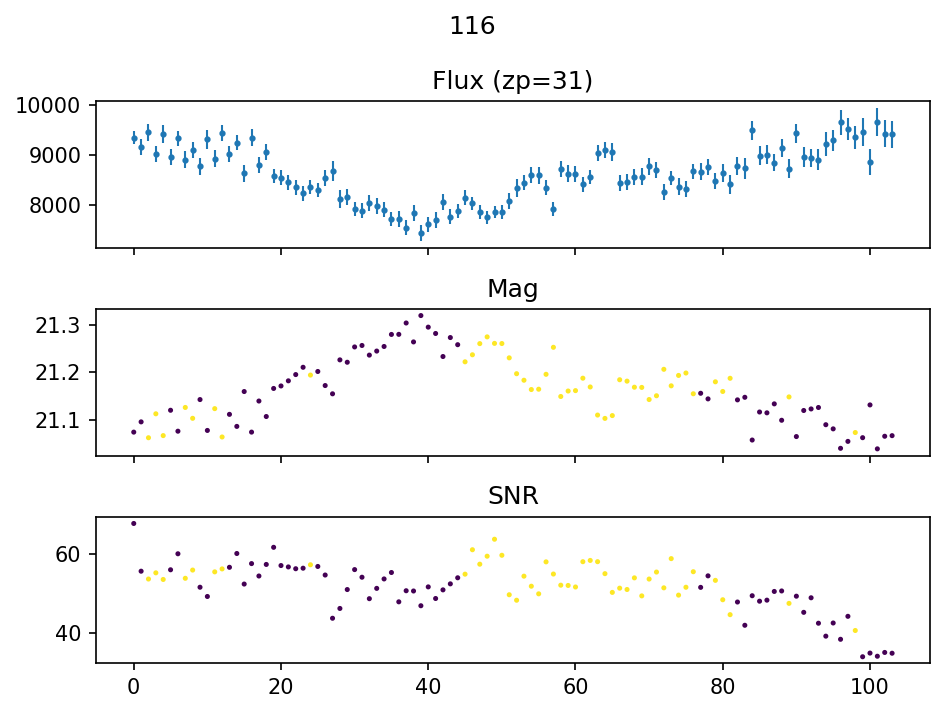

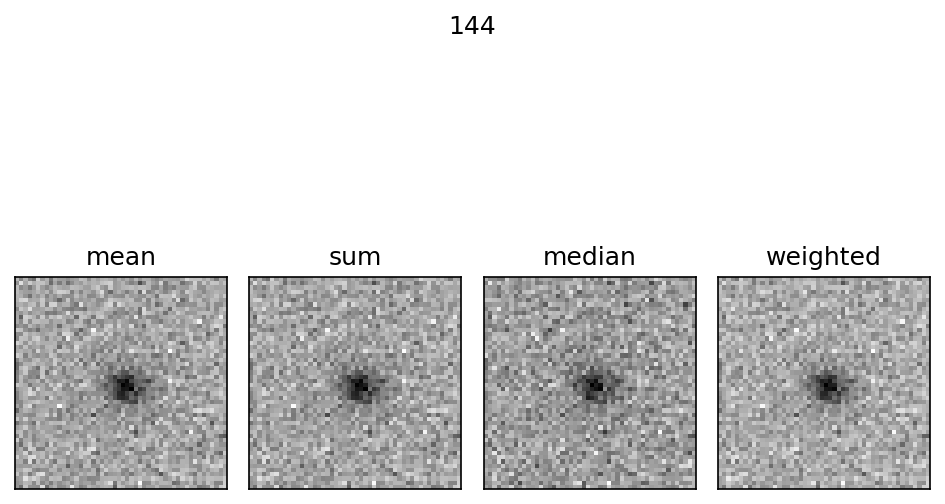

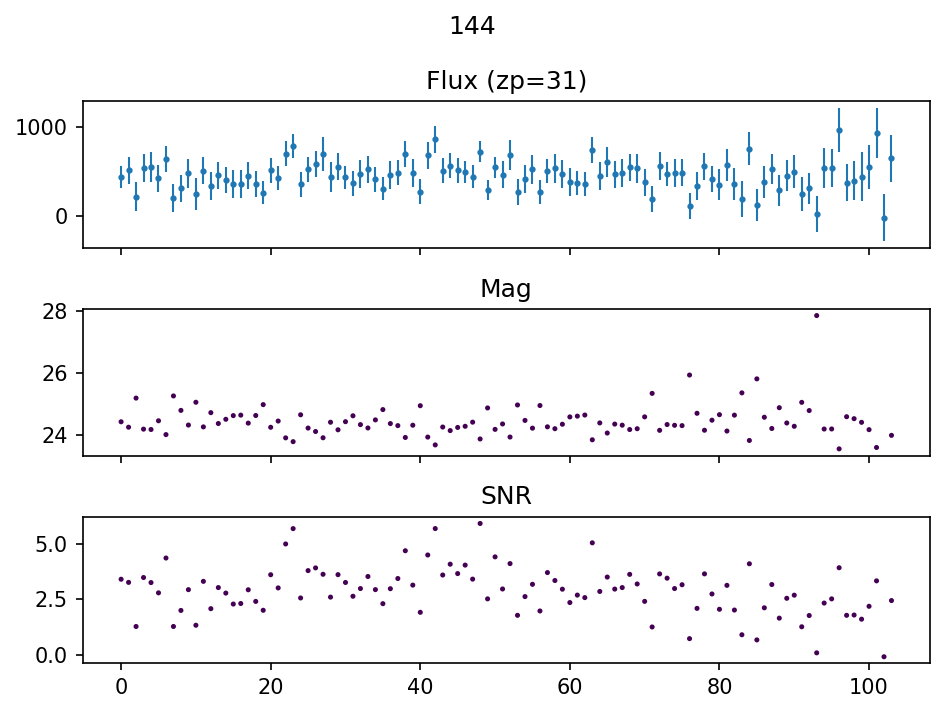

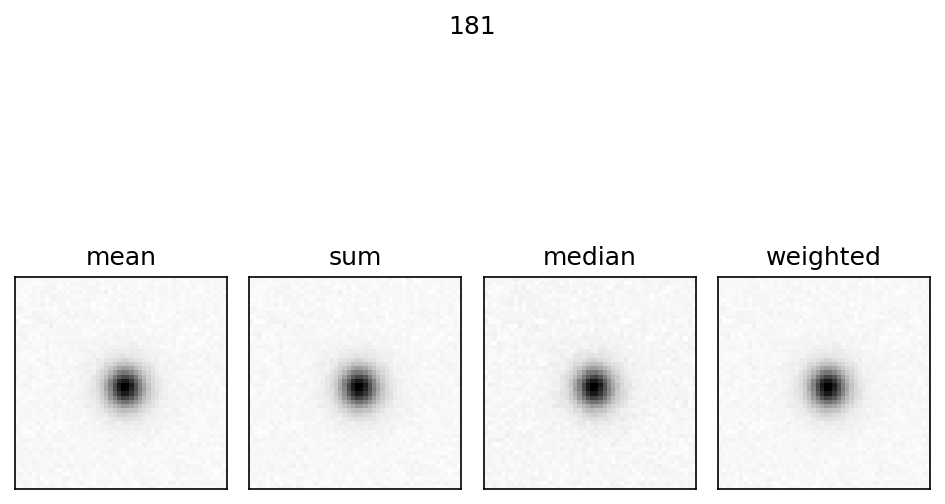

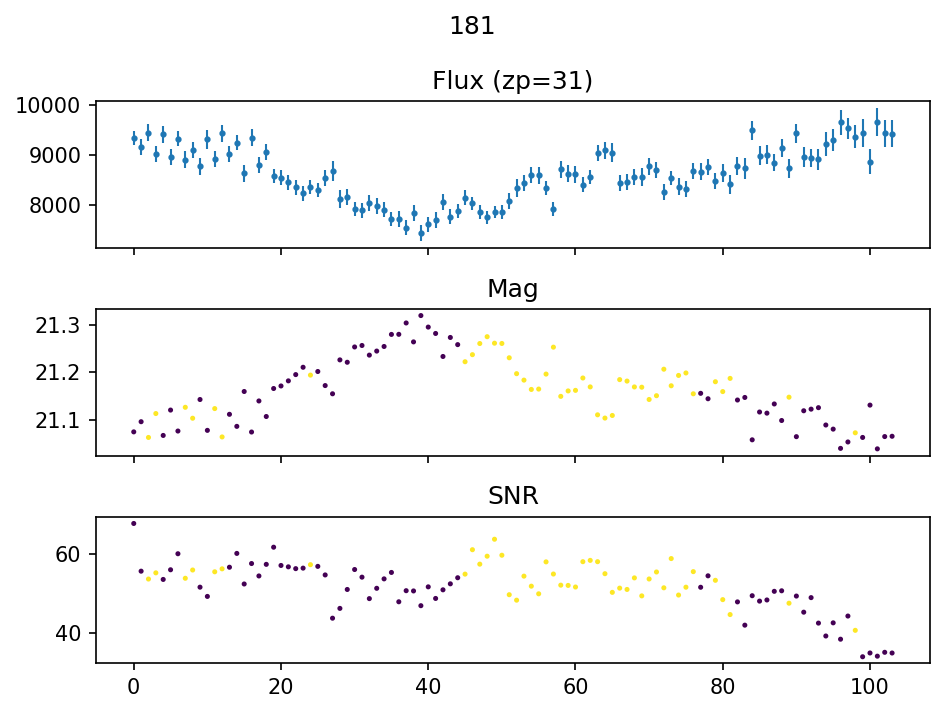

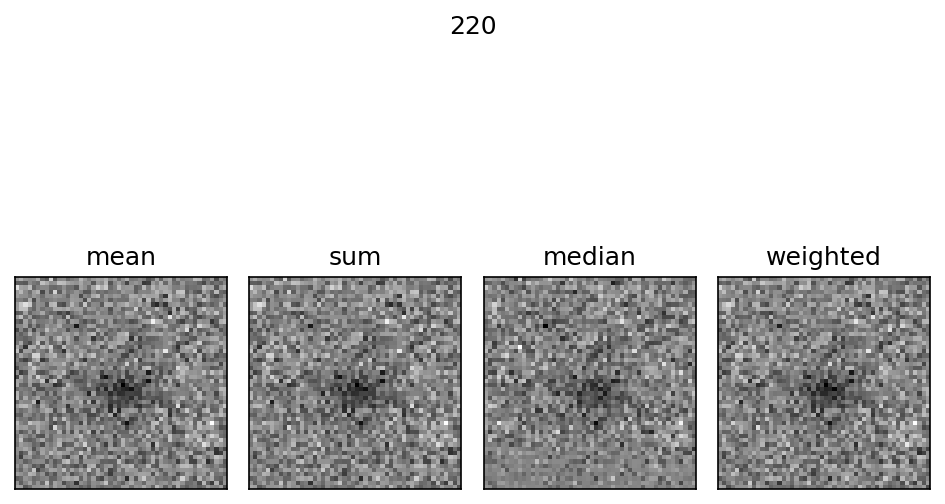

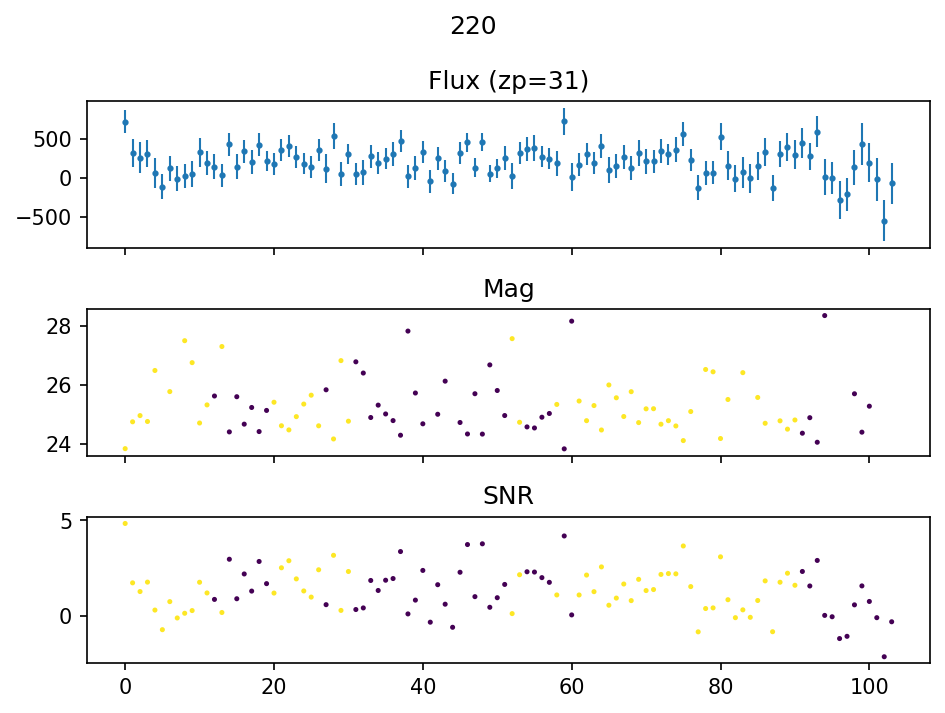

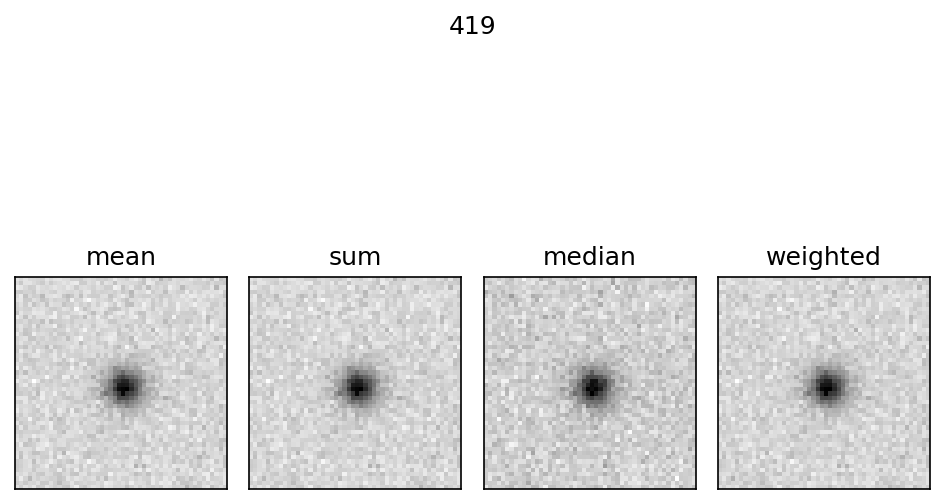

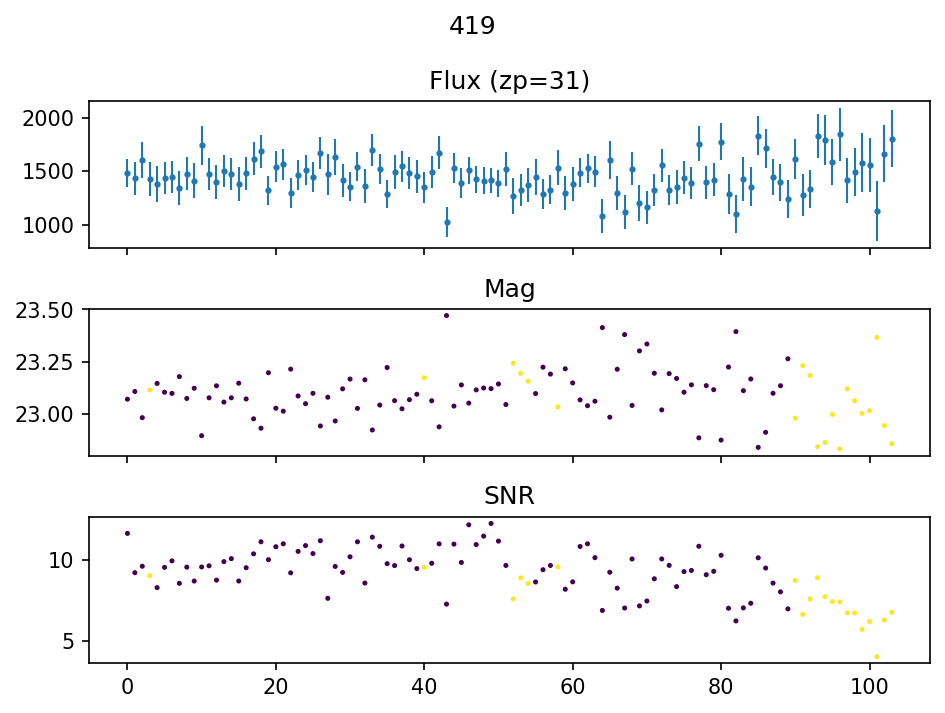

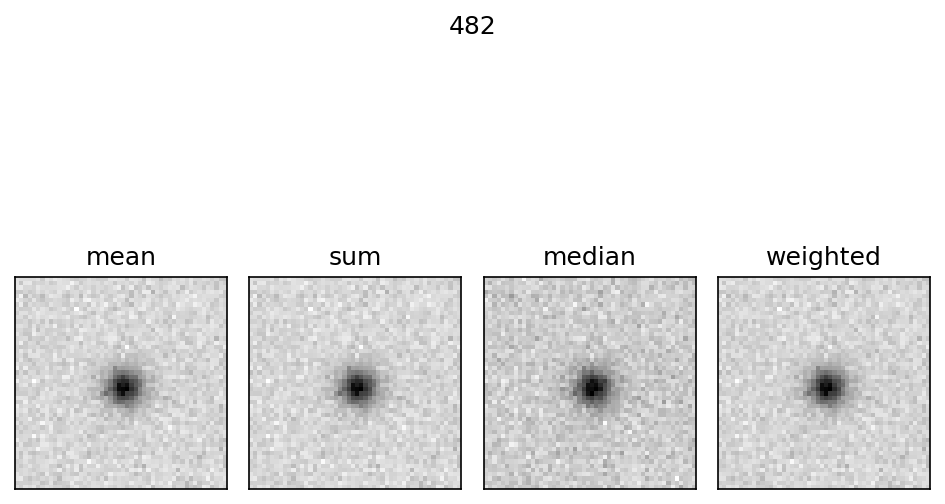

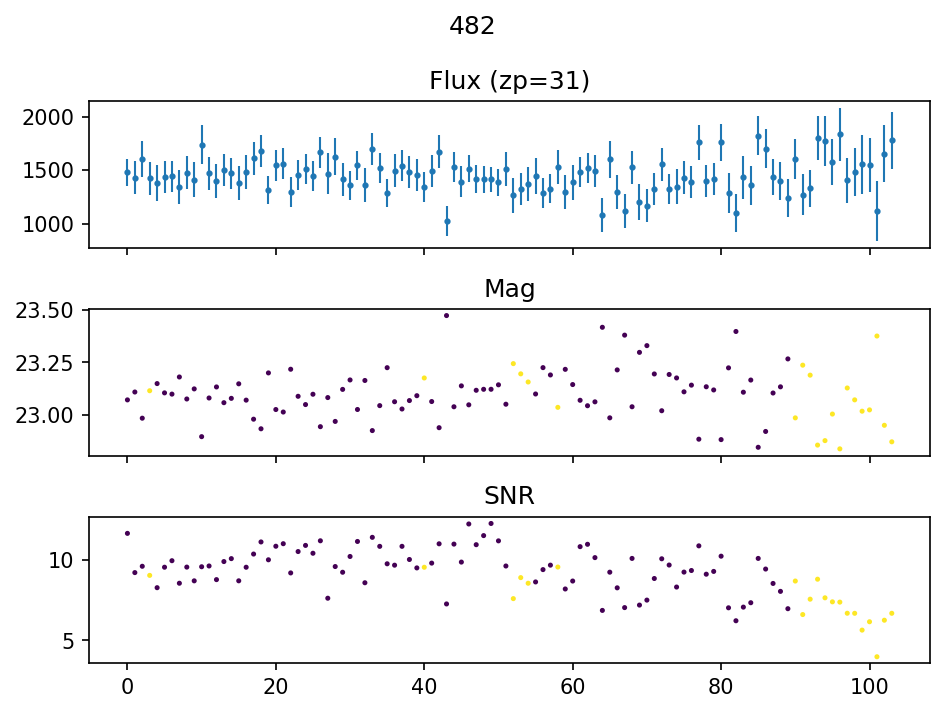

In [189]:
dedup = deduplicate(filtered[4])
for k in dedup:
    plot_summary_coadds(dedup[k].summary)
    fig = plt.gcf()
    fig.suptitle(k)
    fig.tight_layout()
    plt.show()
    plot_summary_light_curve(dedup[k].summary)
    fig = plt.gcf()
    fig.suptitle(k)
    fig.tight_layout()    
    plt.show()

In [209]:
betas

array([[-0.18406865,  0.04179513],
       [-0.15846679,  0.09632855],
       [-0.16490386,  0.05540959],
       [-0.16562331,  0.09495806],
       [-0.15009557,  0.10374602],
       [-0.15383169,  0.06128173],
       [-0.16674617,  0.07035569],
       [-0.1489325 ,  0.15267518],
       [-0.16668617,  0.07806182],
       [-0.10611403,  0.04093392],
       [-0.12590543,  0.18457049],
       [-0.2015875 ,  0.07472988],
       [-0.16125579,  0.05360191],
       [-0.16834773,  0.05244326],
       [-0.21847029, -0.02980513],
       [-0.17026792,  0.08798909],
       [-0.16444184, -0.01697457],
       [-0.15846679,  0.09632855],
       [-0.20630521,  0.03601436],
       [-0.29740323, -0.09622517],
       [-0.29740323, -0.09622517],
       [-0.2184958 , -0.02980308],
       [-0.16419297, -0.01650813],
       [-0.21850254, -0.02976576],
       [-0.16420604,  0.06413675],
       [-0.16674617,  0.07035569],
       [-0.16669352,  0.0704106 ],
       [-0.16670949,  0.07037207],
       [-0.15383169,

In [203]:
find_matches(alphas)

{1: [17], 3: [30], 5: [28], 6: [25], 7: [29], 19: [20]}

In [202]:
find_matches(betas)

{1: [17], 3: [30], 5: [28], 6: [25], 7: [29], 19: [20]}

In [195]:
filtered[4][482].line.alpha.value, filtered[4][419].line.alpha.value

(array([ 9981.40183428, -4133.23315089]),
 array([ 9980.46640458, -4135.4901631 ]))

In [196]:
filtered[4][482].line.beta.value, filtered[4][419].line.beta.value

(array([[-0.16670949,  0.07037207]]), array([[-0.16669352,  0.0704106 ]]))

In [224]:
list(filtered[4].keys())[1]

1

In [217]:
d[27]

array([1.95860200e+03, 1.59520939e+03, 8.82735058e+02, 1.44158033e+03,
       2.18377687e+03, 9.23093560e+02, 2.35307529e+00, 4.93225496e+03,
       4.50516626e+02, 3.94597842e+03, 7.10360245e+03, 2.05921726e+03,
       1.03293200e+03, 1.05464289e+03, 6.60509477e+03, 1.05289653e+03,
       5.11827207e+03, 1.59520939e+03, 3.07094916e+03, 1.24034839e+04,
       1.24034839e+04, 6.60567418e+03, 5.09135900e+03, 6.60391355e+03,
       3.93410305e+02, 2.35307529e+00, 2.44318089e+00, 0.00000000e+00,
       9.23093560e+02, 4.93225496e+03, 1.44158033e+03])

In [227]:
d = np.sum(
    np.vstack(
        [
            [np.subtract.outer(betas[:, 0], betas[:, 0])**2],
            [np.subtract.outer(betas[:, 1], betas[:, 1])**2]
        ]
    ), 
    axis=0
)**0.5

d[27]
#     matches = {}
#     for i in range(d.shape[0]):
#         idx = np.where(d[i] < thresh)[0]
#         idx = idx[idx != i]
#         if len(idx) > 0:
#             m = []
#             for j in idx:
#                 if j not in matches:
#                     m.append(j)
#             if len(m) > 0:
#                 matches[i] = m


array([3.34362331e-02, 2.72338245e-02, 1.50710308e-02, 2.46099716e-02,
       3.72805974e-02, 1.57629885e-02, 4.01703801e-05, 8.42010890e-02,
       7.68979098e-03, 6.73677491e-02, 1.21269335e-01, 3.51492031e-02,
       1.76346568e-02, 1.80034980e-02, 1.12759261e-01, 1.79728163e-02,
       8.73760673e-02, 2.72338245e-02, 5.24239787e-02, 2.11743932e-01,
       2.11743932e-01, 1.12769152e-01, 8.69166315e-02, 1.12739096e-01,
       6.71910804e-03, 4.01703801e-05, 4.17087531e-05, 0.00000000e+00,
       1.57629885e-02, 8.42010890e-02, 2.46099716e-02])

In [199]:
((-0.16670949 - -0.16669352)**2 + (0.07037207 - 0.0704106)**2)**0.5

4.170853389895074e-05

In [87]:
from sklearn.cluster import DBSCAN
import numpy as np

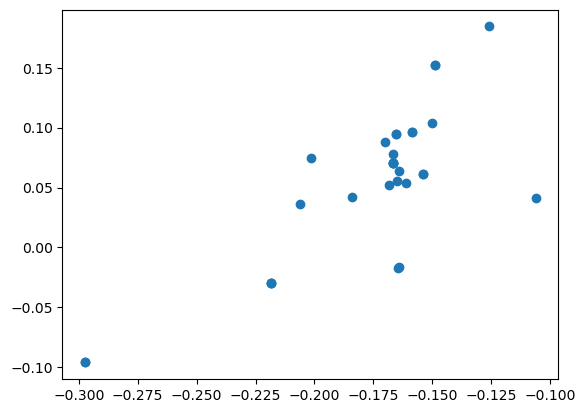

In [97]:
plt.scatter(betas[:, 0], betas[:, 1])
plt.show()

In [88]:
DBSCAN(eps=0.01).fit(np.array(alphas)).labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [89]:
alphas

[array([10998.31625394, -2459.31353914]),
 array([ 9498.76357015, -5653.67824763]),
 array([ 9875.65161844, -3256.85533571]),
 array([ 9917.94754884, -5573.41626844]),
 array([ 9008.30703506, -6088.21856042]),
 array([ 9227.31318845, -3600.83101499]),
 array([ 9983.55058057, -4132.27406137]),
 array([ 8940.07755229, -8954.31008056]),
 array([ 9980.26990559, -4583.74835506]),
 array([ 6432.14895655, -2408.83479109]),
 array([  7591.24023312, -10822.64981132]),
 array([12024.73198638, -4388.53218093]),
 array([ 9661.918822  , -3150.95054471]),
 array([10077.61684065, -3082.98827091]),
 array([13013.4405252 ,  1734.81749306]),
 array([10190.03420848, -5165.25235796]),
 array([9848.76034745,  983.31990968]),
 array([ 9498.76357015, -5653.67824763]),
 array([12300.94109365, -2120.65610359]),
 array([17637.29276612,  5625.54476477]),
 array([17637.29276612,  5625.54476477]),
 array([13014.9347888,  1734.697422 ]),
 array([9834.18270129,  955.99695108]),
 array([13015.32957901,  1732.51118573